## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    #plot_confusion_matrix,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount =True)

Mounted at /content/drive


#### Loading the Test Data

In [ ]:
path=('/content/drive/MyDrive/Model Tuning/Project/Test.csv')
TeData=pd.read_csv(path)

#### Loading the Training Data

In [ ]:
path=('/content/drive/MyDrive/Model Tuning/Project/Train.csv')
TrData=pd.read_csv(path)

## Data Overview

- Observations
- Sanity checks

In [ ]:
TeData.head()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0 -0.613 -3.820  2.202  1.300 -1.185 -4.496 -1.836  4.723  1.206 -0.342   
1  0.390 -0.512  0.527 -2.577 -1.017  2.235 -0.441 -4.406 -0.333  1.967   
2 -0.875 -0.641  4.084 -1.590  0.526 -1.958 -0.695  1.347 -1.732  0.466   
3  0.238  1.459  4.015  2.534  1.197 -3.117 -0.924  0.269  1.322  0.702   
4  5.828  2.768 -1.235  2.809 -1.642 -1.407  0.569  0.965  1.918 -2.775   

     V11    V12    V13    V14    V15    V16    V17    V18    V19    V20  \
0 -5.123  1.017  4.819  3.269 -2.984  1.387  2.032 -0.512 -1.023  7.339   
1  1.797  0.410  0.638 -1.390 -1.883 -5.018 -3.827  2.418  1.762 -3.242   
2 -4.928  3.565 -0.449 -0.656 -0.167 -1.630  2.292  2.396  0.601  1.794   
3 -5.578 -0.851  2.591  0.767 -2.391 -2.342  0.572 -0.934  0.509  1.211   
4 -0.530  1.375 -0.651 -1.679 -0.379 -4.443  3.894 -0.608  2.945  0.367   

     V21   V22    V23    V24    V25    V26    V27    V28    V29    V30    V31  \
0 -2.242 0.155  2.054 -2.772  1.851 -1.789 -0.277 -1.255 -3.833 -1.505  1.587   
1 -3.193 1.857 -1.708  0.633 -0.588  0.084  3.014 -0.182  0.224  0.865 -1.782   
2 -2.120 0.482 -0.841  1.790  1.874  0.364 -0.169 -0.484 -2.119 -2.157  2.907   
3 -3.260 0.105 -0.659  1.498  1.100  4.143 -0.248 -1.137 -5.356 -4.546  3.809   
4 -5.789 4.598  4.450  3.225  0.397  0.248 -2.362  1.079 -0.473  2.243 -3.591   

     V32    V33    V34   V35    V36    V37     V38    V39    V40  Target  
0  2.291 -5.411  0.870 0.574  4.157  1.428 -10.511  0.455 -1.448       0  
1 -2.475  2.494  0.315 2.059  0.684 -0.485   5.128  1.721 -1.488       0  
2 -1.319 -2.997  0.460 0.620  5.632  1.324  -1.752  1.808  1.676       0  
3  3.518 -3.074 -0.284 0.955  3.029 -1.367  -3.412  0.906 -2.451       0  
4  1.774 -1.502 -2.227 4.777 -6.560 -0.806  -0.276 -3.858 -0.538       0

In [ ]:
TeData.shape

(5000, 41)

#### Observations

 - Test data loaded correctly with 5000 rows and 41 columns as indicated in the problem description, together with the Target

In [ ]:
TeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

Observations
  - All data types are floats and integer, no object data type.

In [ ]:
TeData.describe().T

count   mean   std     min    25%    50%    75%    max
V1     4995.000 -0.278 3.466 -12.382 -2.744 -0.765  1.831 13.504
V2     4994.000  0.398 3.140 -10.716 -1.649  0.427  2.444 14.079
V3     5000.000  2.552 3.327  -9.238  0.315  2.260  4.587 15.315
V4     5000.000 -0.049 3.414 -14.682 -2.293 -0.146  2.166 12.140
V5     5000.000 -0.080 2.111  -7.712 -1.615 -0.132  1.341  7.673
V6     5000.000 -1.042 2.005  -8.924 -2.369 -1.049  0.308  5.068
V7     5000.000 -0.908 1.769  -8.124 -2.054 -0.940  0.212  7.616
V8     5000.000 -0.575 3.332 -12.253 -2.642 -0.358  1.713 10.415
V9     5000.000  0.030 2.174  -6.785 -1.456 -0.080  1.450  8.851
V10    5000.000  0.019 2.145  -8.171 -1.353  0.166  1.511  6.599
V11    5000.000 -2.009 3.112 -13.152 -4.050 -2.043  0.044  9.956
V12    5000.000  1.576 2.907  -8.164 -0.450  1.488  3.563 12.984
V13    5000.000  1.622 2.883 -11.548 -0.126  1.719  3.465 12.620
V14    5000.000 -0.921 1.803  -7.814 -2.111 -0.896  0.272  5.734
V15    5000.000 -2.452 3.387 -15.286 -4.479 -2.417 -0.433 11.673
V16    5000.000 -3.019 4.264 -20.986 -5.648 -2.774 -0.178 13.976
V17    5000.000 -0.104 3.337 -13.418 -2.228  0.047  2.112 19.777
V18    5000.000  1.196 2.586 -12.214 -0.409  0.881  2.604 13.642
V19    5000.000  1.210 3.385 -14.170 -1.026  1.296  3.526 12.428
V20    5000.000  0.138 3.657 -13.720 -2.325  0.193  2.540 13.871
V21    5000.000 -3.664 3.578 -16.341 -5.944 -3.663 -1.330 11.047
V22    5000.000  0.962 1.640  -6.740 -0.048  0.986  2.029  7.505
V23    5000.000 -0.422 4.057 -14.422 -3.163 -0.279  2.426 13.181
V24    5000.000  1.089 3.968 -12.316 -1.623  0.913  3.537 17.806
V25    5000.000  0.061 2.010  -6.770 -1.298  0.077  1.428  6.557
V26    5000.000  1.847 3.400 -11.414 -0.242  1.917  4.156 17.528
V27    5000.000 -0.552 4.403 -13.177 -3.663 -0.872  2.247 17.290
V28    5000.000 -0.868 1.926  -7.933 -2.160 -0.931  0.421  7.416
V29    5000.000 -1.096 2.655  -9.988 -2.861 -1.341  0.522 14.039
V30    5000.000 -0.119 3.023 -12.438 -1.997  0.112  1.946 10.315
V31    5000.000  0.469 3.446 -11.263 -1.822  0.486  2.779 12.559
V32    5000.000  0.233 5.586 -17.244 -3.556 -0.077  3.752 26.539
V33    5000.000 -0.080 3.539 -14.904 -2.348 -0.160  2.099 13.324
V34    5000.000 -0.393 3.166 -14.700 -2.010 -0.172  1.465 12.146
V35    5000.000  2.211 2.948 -12.261  0.322  2.112  4.032 13.489
V36    5000.000  1.595 3.775 -12.736 -0.866  1.703  4.104 17.116
V37    5000.000  0.023 1.785  -5.079 -1.241 -0.110  1.238  6.810
V38    5000.000 -0.406 3.969 -15.335 -2.984 -0.381  2.288 13.065
V39    5000.000  0.939 1.717  -5.451 -0.208  0.959  2.131  7.182
V40    5000.000 -0.932 2.978 -10.076 -2.987 -1.003  1.080  8.698
Target 5000.000  0.056 0.231   0.000  0.000  0.000  0.000  1.000

#### Checking for missing values in the test data

In [ ]:
TeData.isna().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

#### Observations

 - Values for both V1 and V2 are missing in 5 and 6 rows in the testing data set respectively

#### Checking for duplicates in the test data

In [ ]:
TeData.duplicated().any()

False

#### Observations

 - There are no duplicates in the testing data set

In [ ]:
TrData.head()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0 -4.465 -4.679  3.102  0.506 -0.221 -2.033 -2.911  0.051 -1.522  3.762   
1  3.366  3.653  0.910 -1.368  0.332  2.359  0.733 -4.332  0.566 -0.101   
2 -3.832 -5.824  0.634 -2.419 -1.774  1.017 -2.099 -3.173 -2.082  5.393   
3  1.618  1.888  7.046 -1.147  0.083 -1.530  0.207 -2.494  0.345  2.119   
4 -0.111  3.872 -3.758 -2.983  3.793  0.545  0.205  4.849 -1.855 -6.220   

     V11    V12    V13    V14    V15    V16    V17    V18    V19    V20  \
0 -5.715  0.736  0.981  1.418 -3.376 -3.047  0.306  2.914  2.270  4.395   
1  1.914 -0.951 -1.255 -2.707  0.193 -4.769 -2.205  0.908  0.757 -5.834   
2 -0.771  1.107  1.144  0.943 -3.164 -4.248 -4.039  3.689  3.311  1.059   
3 -3.053  0.460  2.705 -0.636 -0.454 -3.174 -3.404 -1.282  1.582 -1.952   
4  1.998  4.724  0.709 -1.989 -2.633  4.184  2.245  3.734 -6.313 -5.380   

     V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \
0 -2.388  0.646 -1.191  3.133  0.665 -2.511 -0.037  0.726 -3.982 -1.073   
1 -3.065  1.597 -1.757  1.766 -0.267  3.625  1.500 -0.586  0.783 -0.201   
2 -2.143  1.650 -1.661  1.680 -0.451 -4.551  3.739  1.134 -2.034  0.841   
3 -3.517 -1.206 -5.628 -1.818  2.124  5.295  4.748 -2.309 -3.963 -6.029   
4 -0.887  2.062  9.446  4.490 -3.945  4.582 -8.780 -3.383  5.107  6.788   

     V31    V32    V33     V34   V35    V36    V37    V38    V39    V40  \
0  1.667  3.060 -1.690   2.846 2.235  6.667  0.444 -2.369  2.951 -3.480   
1  0.025 -1.795  3.033  -2.468 1.895 -2.298 -1.731  5.909 -0.386  0.616   
2 -1.600 -0.257  0.804   4.086 2.292  5.361  0.352  2.940  3.839 -4.309   
3  4.949 -3.584 -2.577   1.364 0.623  5.550 -1.527  0.139  3.101 -1.277   
4  2.044  8.266  6.629 -10.069 1.223 -3.230  1.687 -2.164 -3.645  6.510   

   Target  
0       0  
1       0  
2       0  
3       0  
4       0

In [ ]:
TrData.shape

(20000, 41)

#### Observations

 - Train data loaded correctly with 20000 rows and 41 columns as indicated in the problem description, together with the Target

In [ ]:
TrData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

#### Observations

 - All data types are floats and integer, no object data type.

In [ ]:
TrData.describe().T

count   mean   std     min    25%    50%    75%    max
V1     19982.000 -0.272 3.442 -11.876 -2.737 -0.748  1.840 15.493
V2     19982.000  0.440 3.151 -12.320 -1.641  0.472  2.544 13.089
V3     20000.000  2.485 3.389 -10.708  0.207  2.256  4.566 17.091
V4     20000.000 -0.083 3.432 -15.082 -2.348 -0.135  2.131 13.236
V5     20000.000 -0.054 2.105  -8.603 -1.536 -0.102  1.340  8.134
V6     20000.000 -0.995 2.041 -10.227 -2.347 -1.001  0.380  6.976
V7     20000.000 -0.879 1.762  -7.950 -2.031 -0.917  0.224  8.006
V8     20000.000 -0.548 3.296 -15.658 -2.643 -0.389  1.723 11.679
V9     20000.000 -0.017 2.161  -8.596 -1.495 -0.068  1.409  8.138
V10    20000.000 -0.013 2.193  -9.854 -1.411  0.101  1.477  8.108
V11    20000.000 -1.895 3.124 -14.832 -3.922 -1.921  0.119 11.826
V12    20000.000  1.605 2.930 -12.948 -0.397  1.508  3.571 15.081
V13    20000.000  1.580 2.875 -13.228 -0.224  1.637  3.460 15.420
V14    20000.000 -0.951 1.790  -7.739 -2.171 -0.957  0.271  5.671
V15    20000.000 -2.415 3.355 -16.417 -4.415 -2.383 -0.359 12.246
V16    20000.000 -2.925 4.222 -20.374 -5.634 -2.683 -0.095 13.583
V17    20000.000 -0.134 3.345 -14.091 -2.216 -0.015  2.069 16.756
V18    20000.000  1.189 2.592 -11.644 -0.404  0.883  2.572 13.180
V19    20000.000  1.182 3.397 -13.492 -1.050  1.279  3.493 13.238
V20    20000.000  0.024 3.669 -13.923 -2.433  0.033  2.512 16.052
V21    20000.000 -3.611 3.568 -17.956 -5.930 -3.533 -1.266 13.840
V22    20000.000  0.952 1.652 -10.122 -0.118  0.975  2.026  7.410
V23    20000.000 -0.366 4.032 -14.866 -3.099 -0.262  2.452 14.459
V24    20000.000  1.134 3.912 -16.387 -1.468  0.969  3.546 17.163
V25    20000.000 -0.002 2.017  -8.228 -1.365  0.025  1.397  8.223
V26    20000.000  1.874 3.435 -11.834 -0.338  1.951  4.130 16.836
V27    20000.000 -0.612 4.369 -14.905 -3.652 -0.885  2.189 17.560
V28    20000.000 -0.883 1.918  -9.269 -2.171 -0.891  0.376  6.528
V29    20000.000 -0.986 2.684 -12.579 -2.787 -1.176  0.630 10.722
V30    20000.000 -0.016 3.005 -14.796 -1.867  0.184  2.036 12.506
V31    20000.000  0.487 3.461 -13.723 -1.818  0.490  2.731 17.255
V32    20000.000  0.304 5.500 -19.877 -3.420  0.052  3.762 23.633
V33    20000.000  0.050 3.575 -16.898 -2.243 -0.066  2.255 16.692
V34    20000.000 -0.463 3.184 -17.985 -2.137 -0.255  1.437 14.358
V35    20000.000  2.230 2.937 -15.350  0.336  2.099  4.064 15.291
V36    20000.000  1.515 3.801 -14.833 -0.944  1.567  3.984 19.330
V37    20000.000  0.011 1.788  -5.478 -1.256 -0.128  1.176  7.467
V38    20000.000 -0.344 3.948 -17.375 -2.988 -0.317  2.279 15.290
V39    20000.000  0.891 1.753  -6.439 -0.272  0.919  2.058  7.760
V40    20000.000 -0.876 3.012 -11.024 -2.940 -0.921  1.120 10.654
Target 20000.000  0.056 0.229   0.000  0.000  0.000  0.000  1.000

#### Checking for missing values in the Training Data

In [ ]:
TrData.isna().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

#### Observations

 - Values for both V1 and V2 are missing in 18 rows in the training data set

#### Checking for duplicates in the Training Data

In [ ]:
TrData.duplicated().any()

False

#### Observations

 - There are no duplicates in the training data set

## Exploratory Data Analysis (EDA)

In [ ]:
TestD= TeData.copy()

In [ ]:
TrainD=TrData.copy()

### Plotting histograms and boxplots for all the variables

In [ ]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

### Ploting the Features of the Test Data

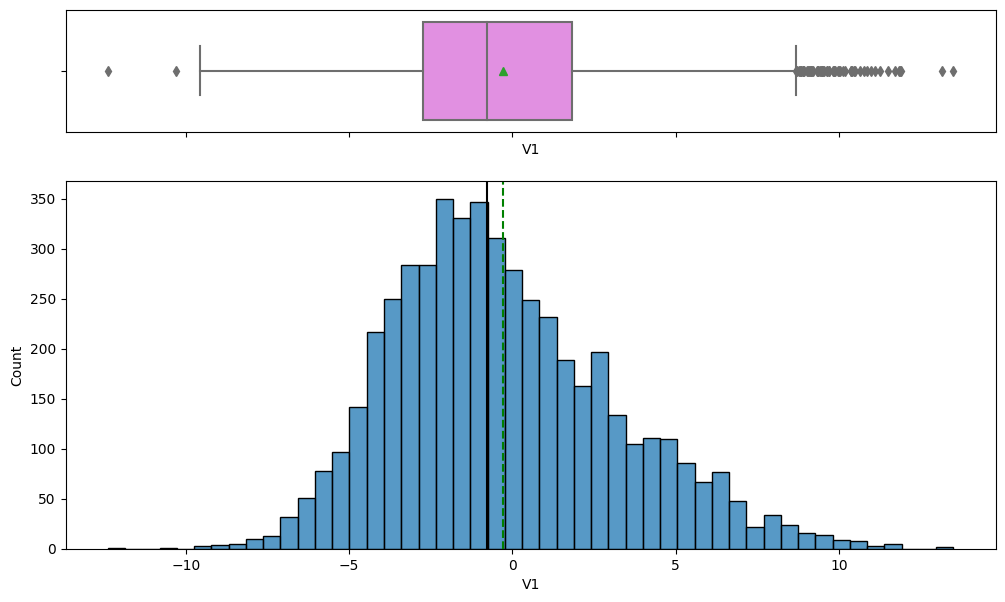

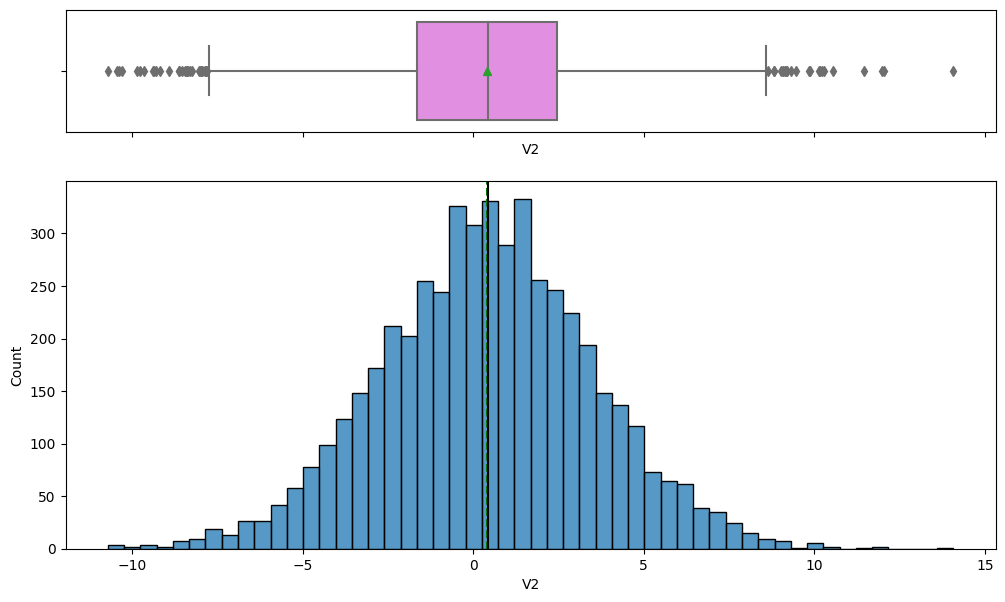

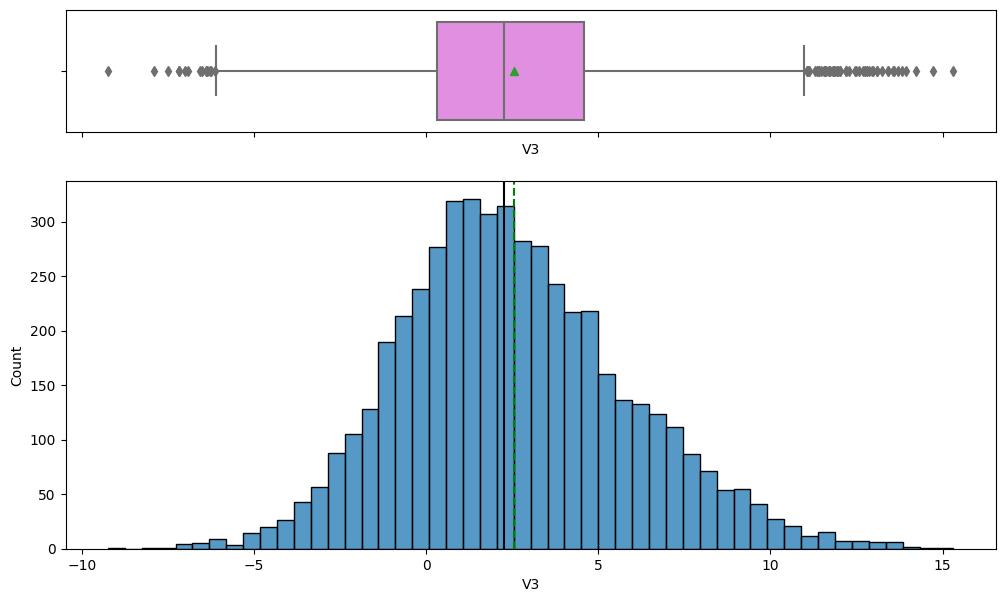

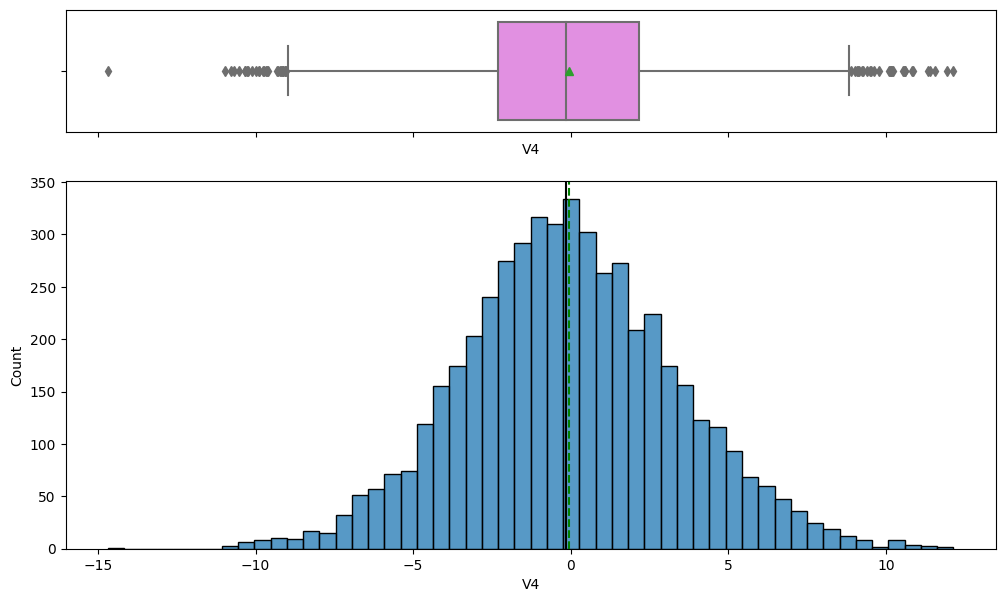

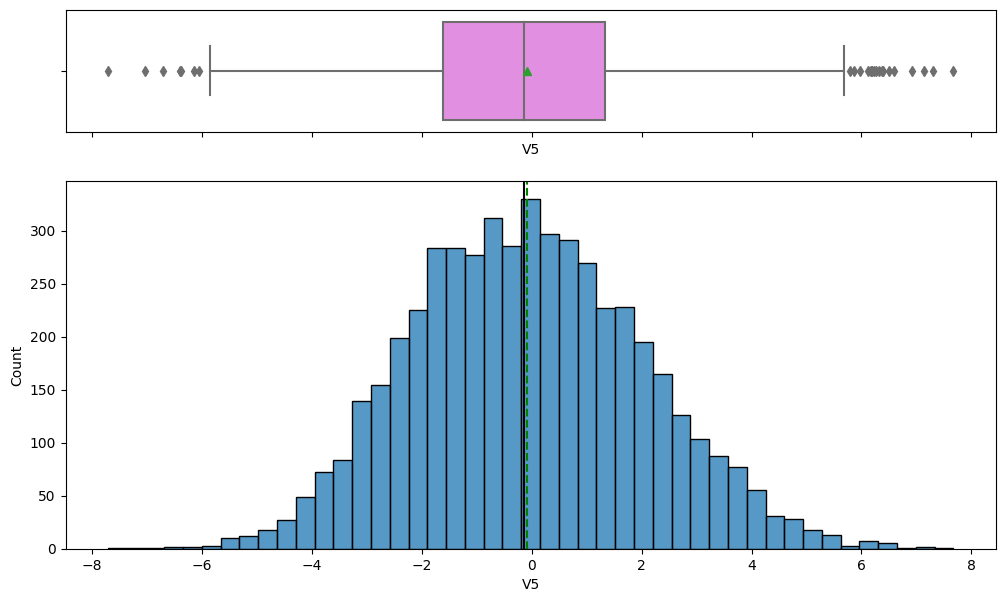

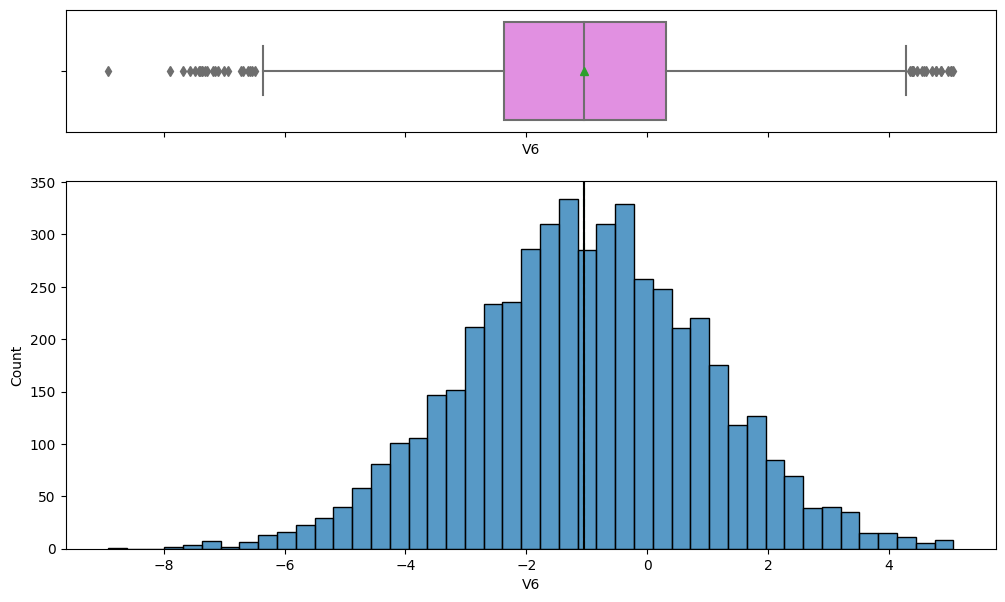

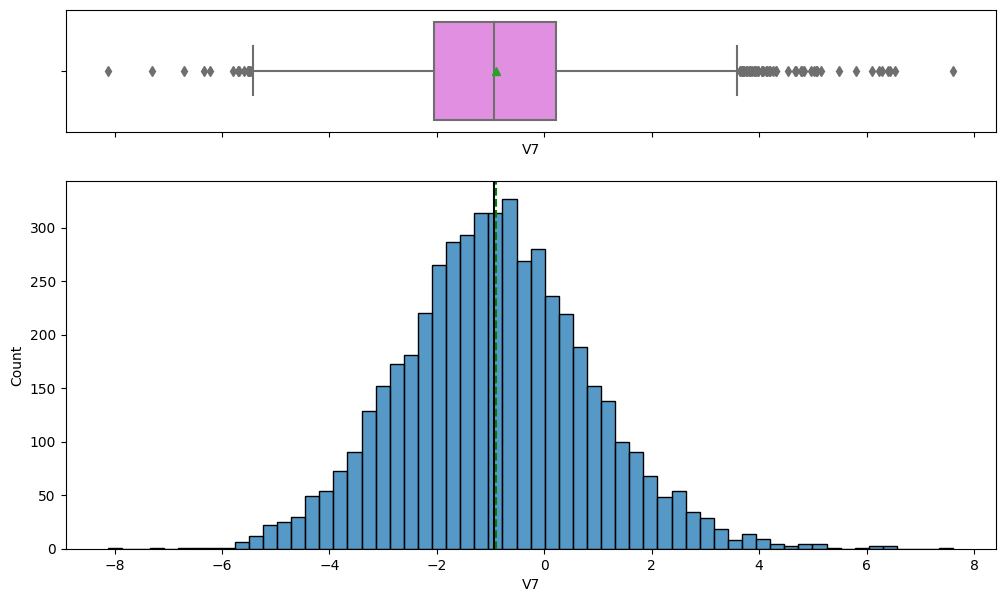

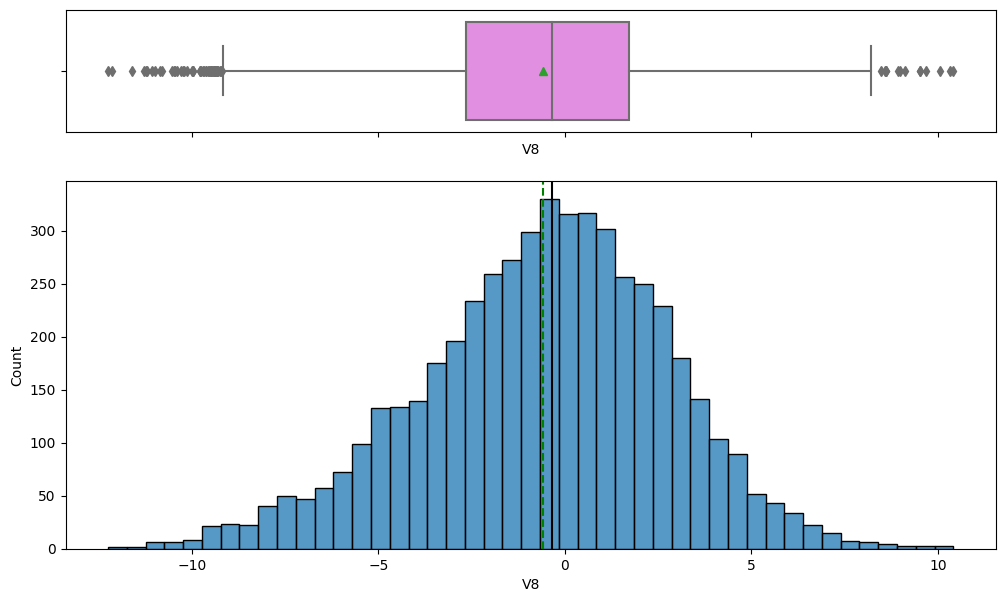

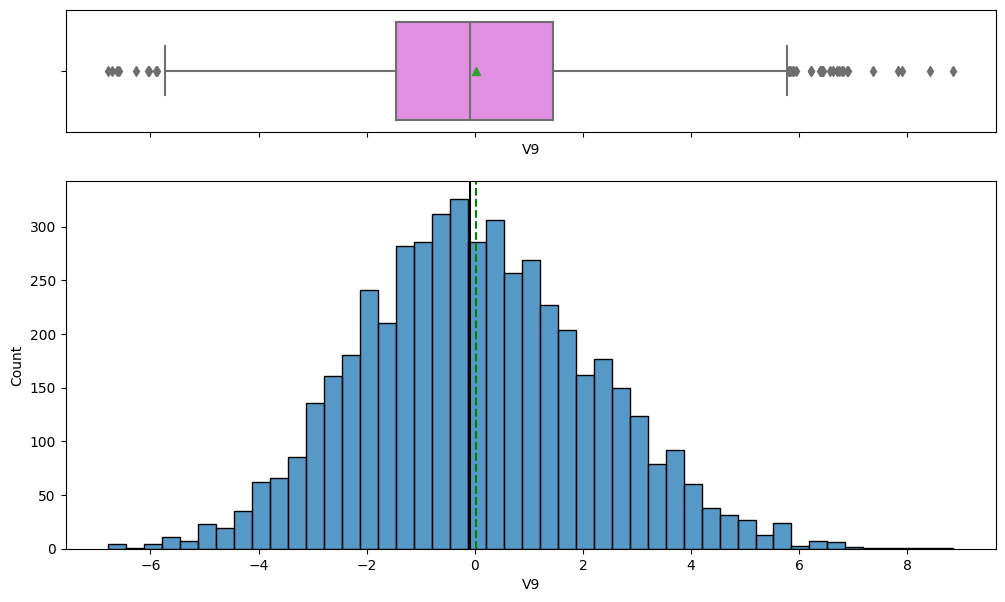

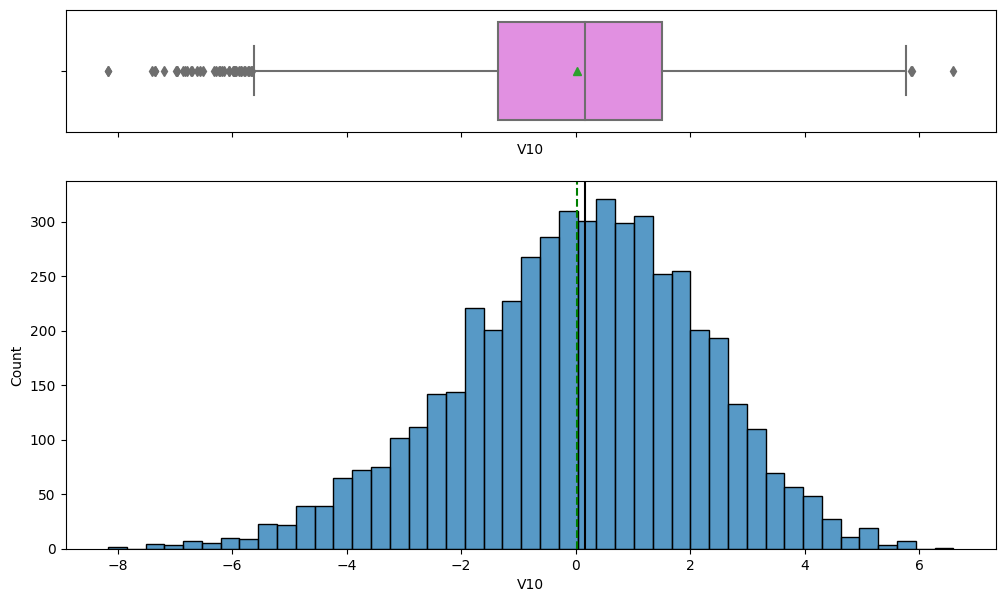

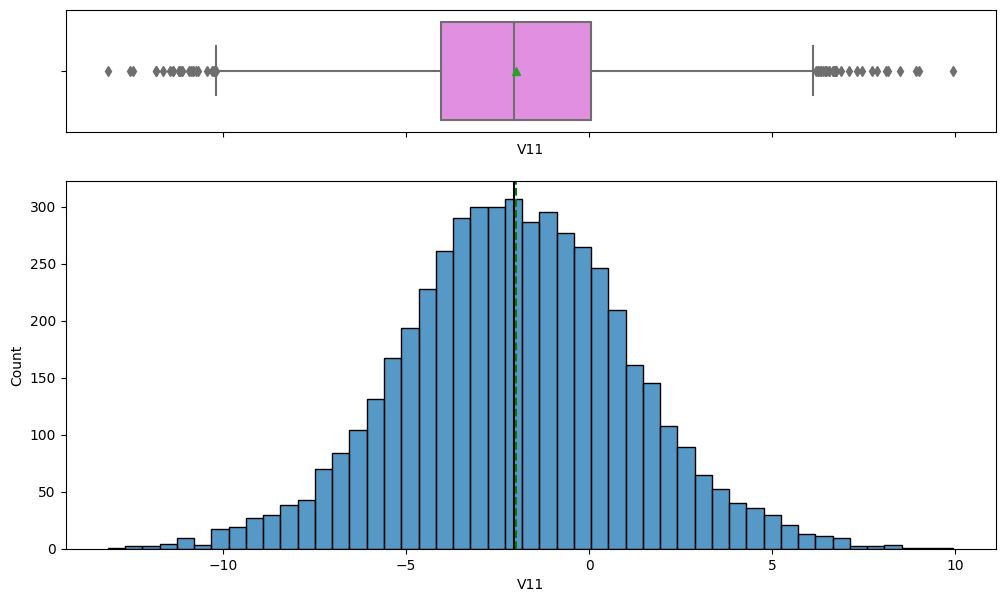

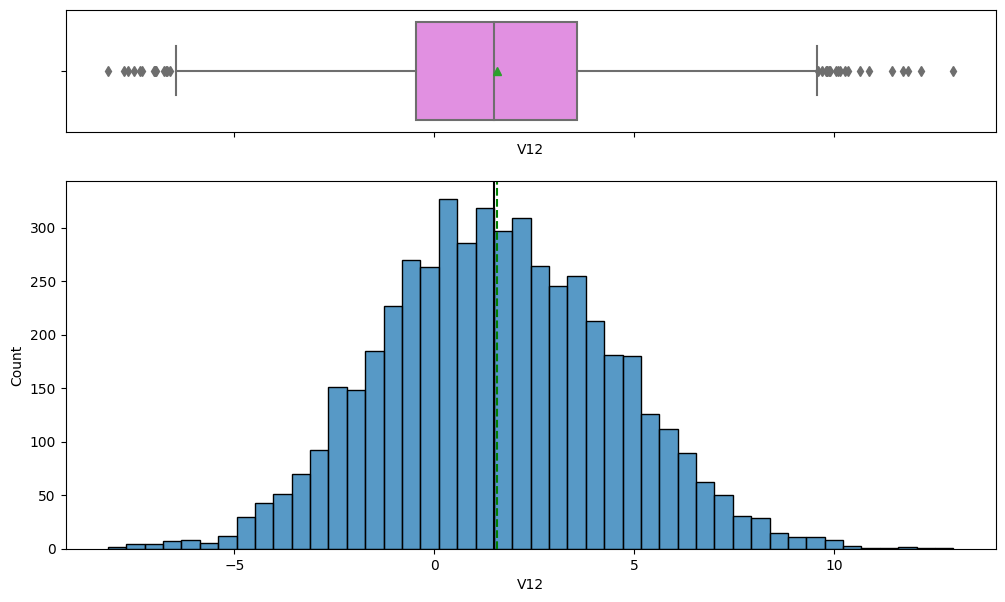

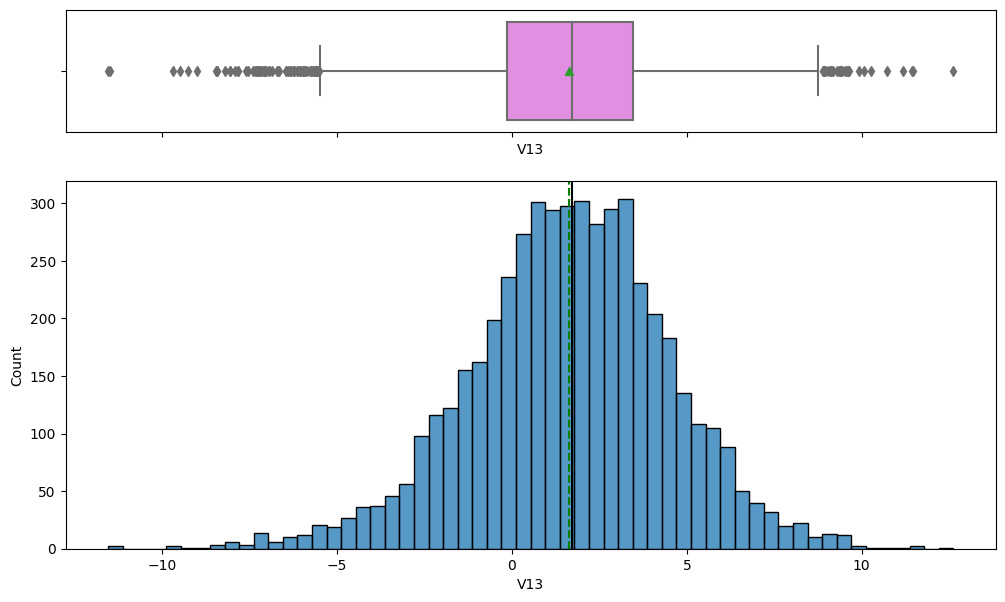

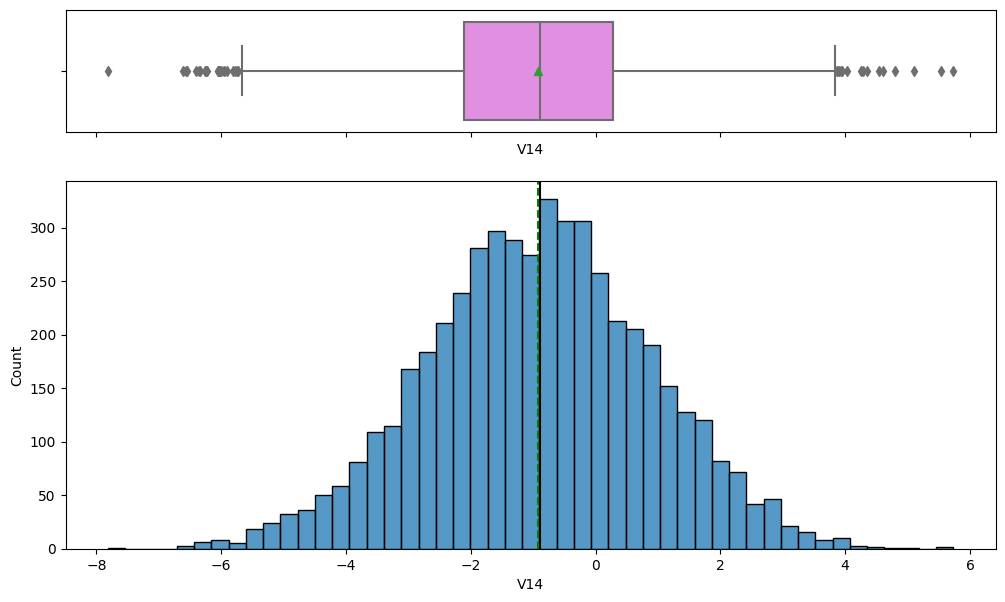

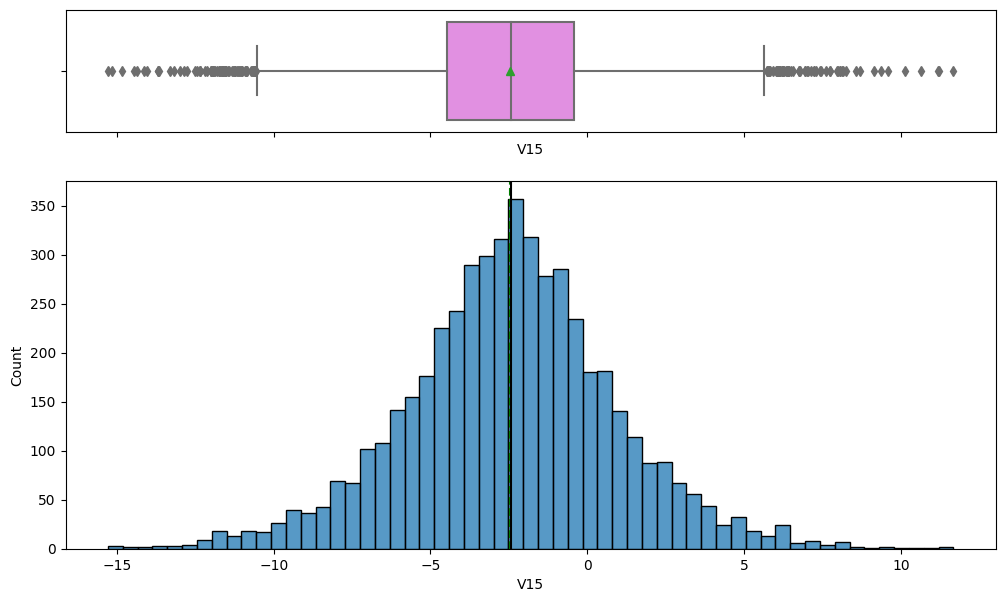

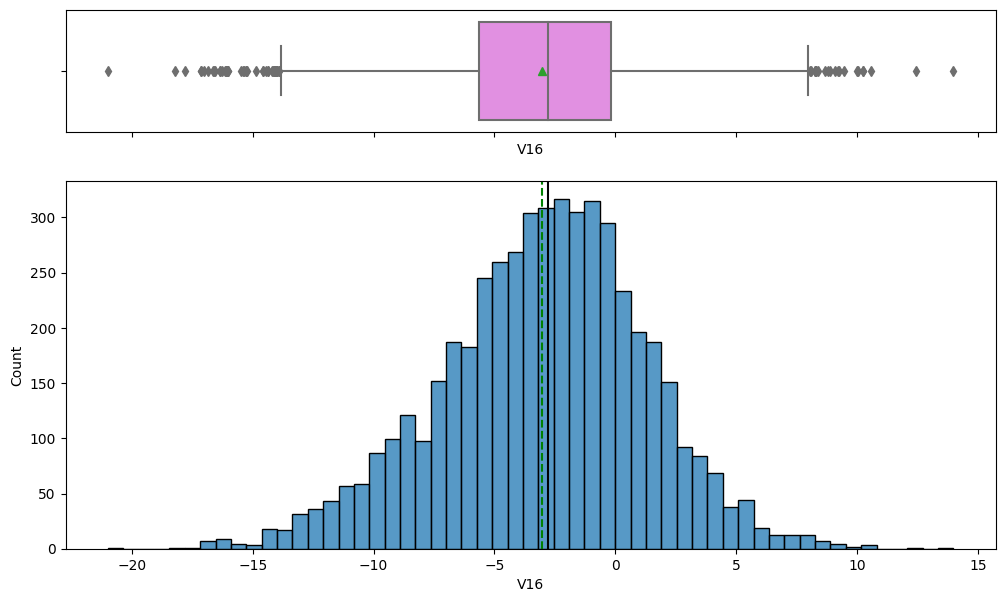

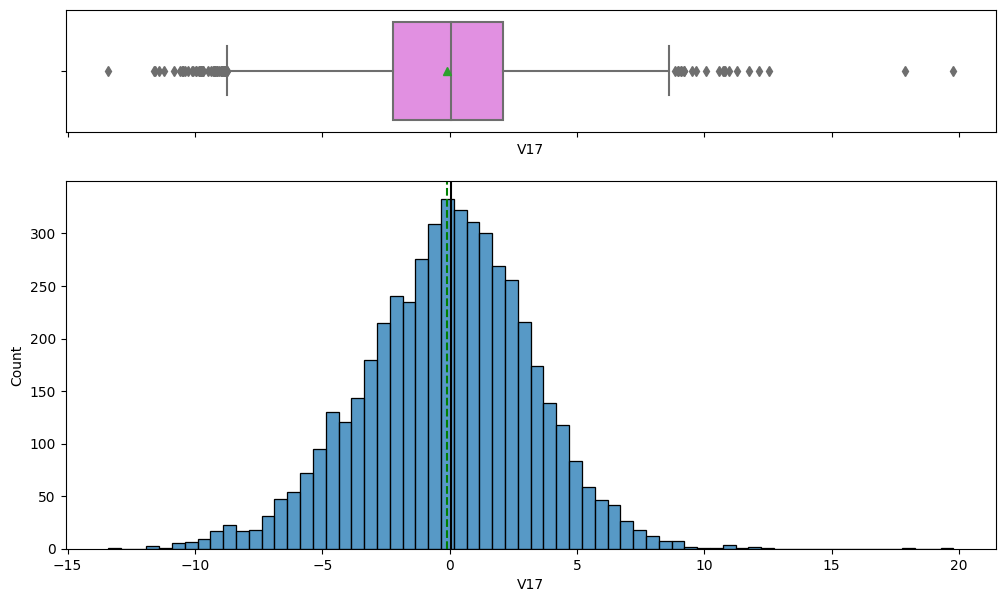

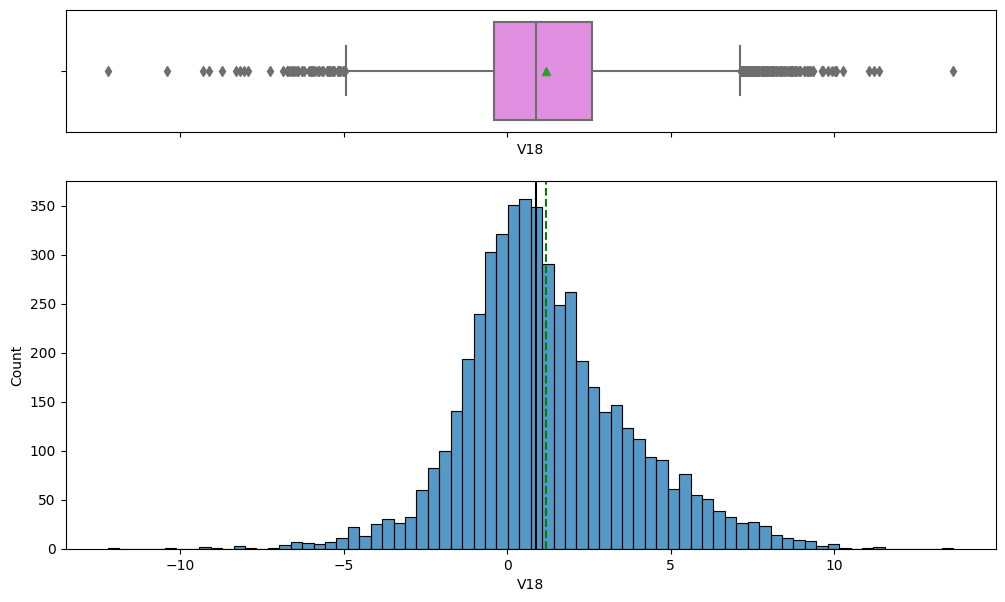

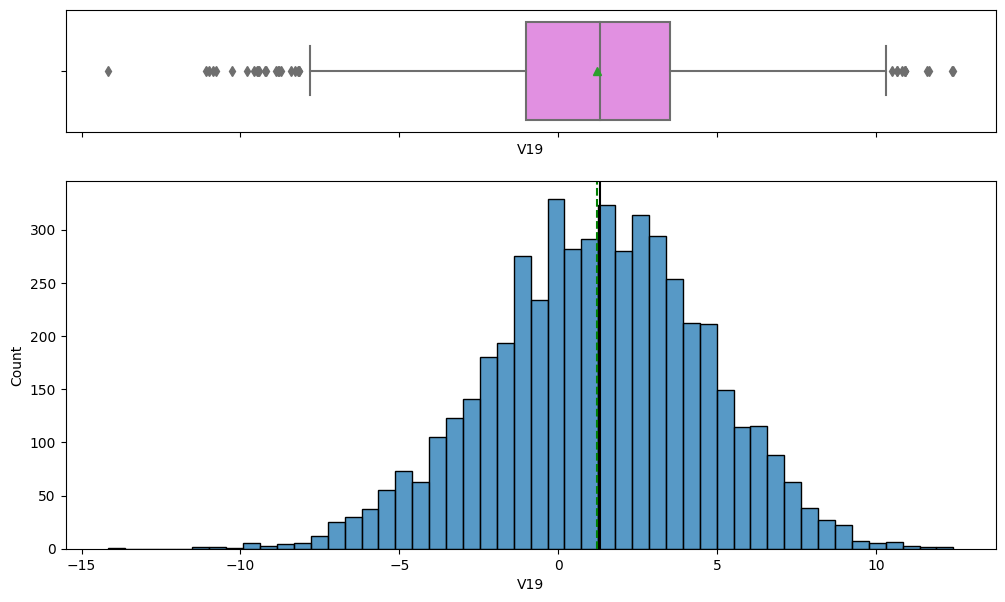

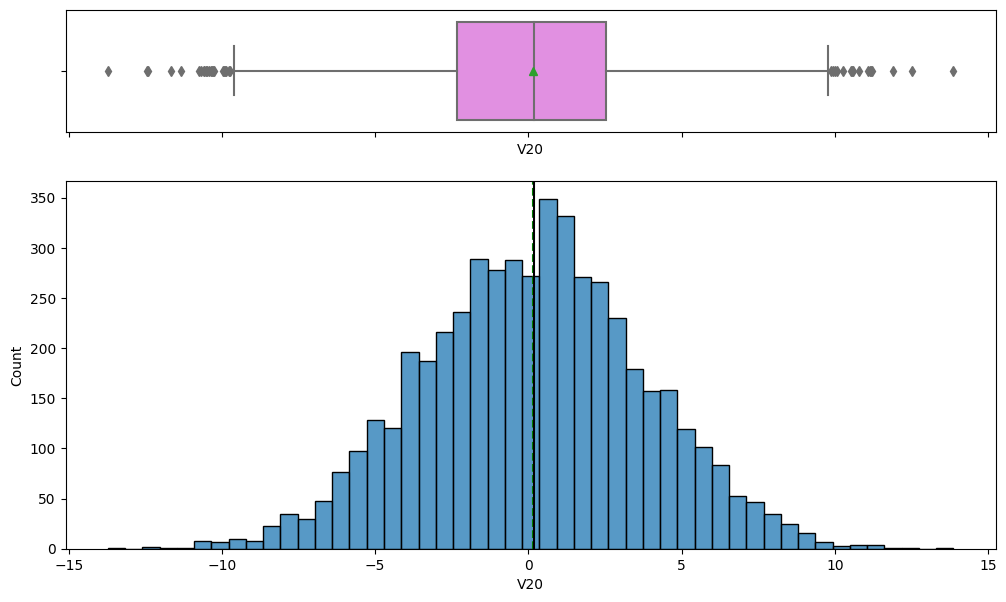

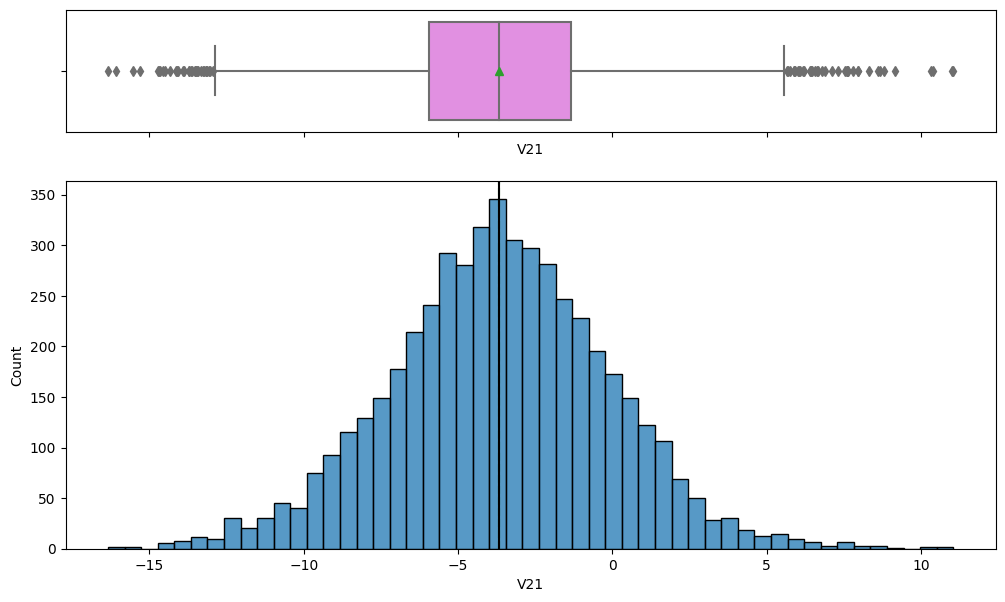

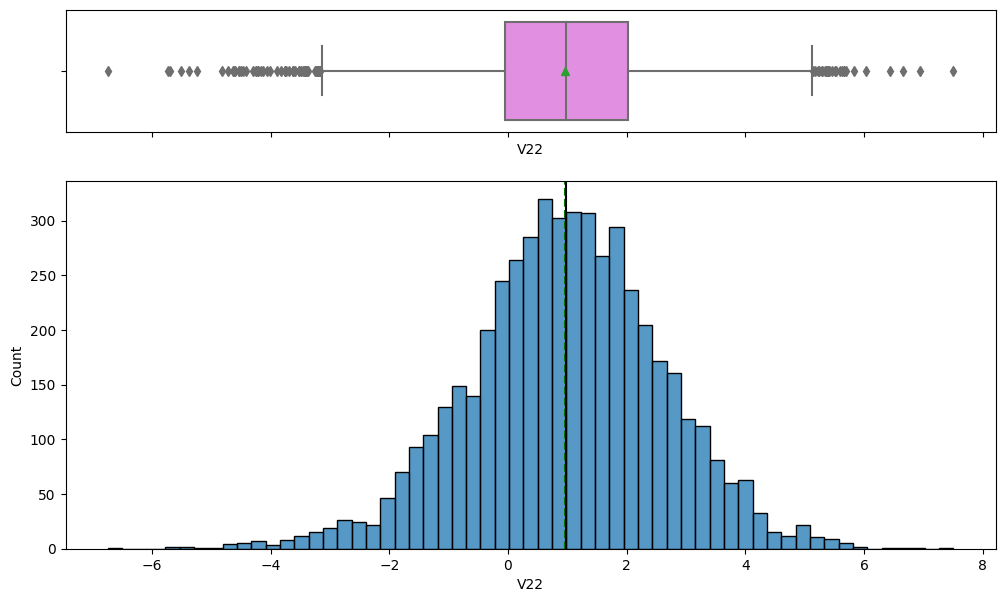

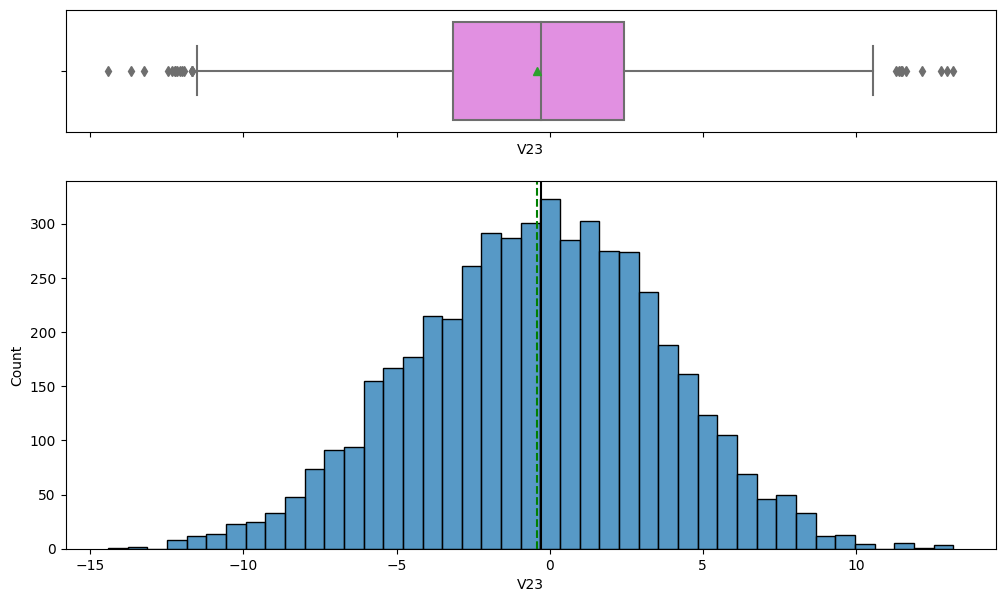

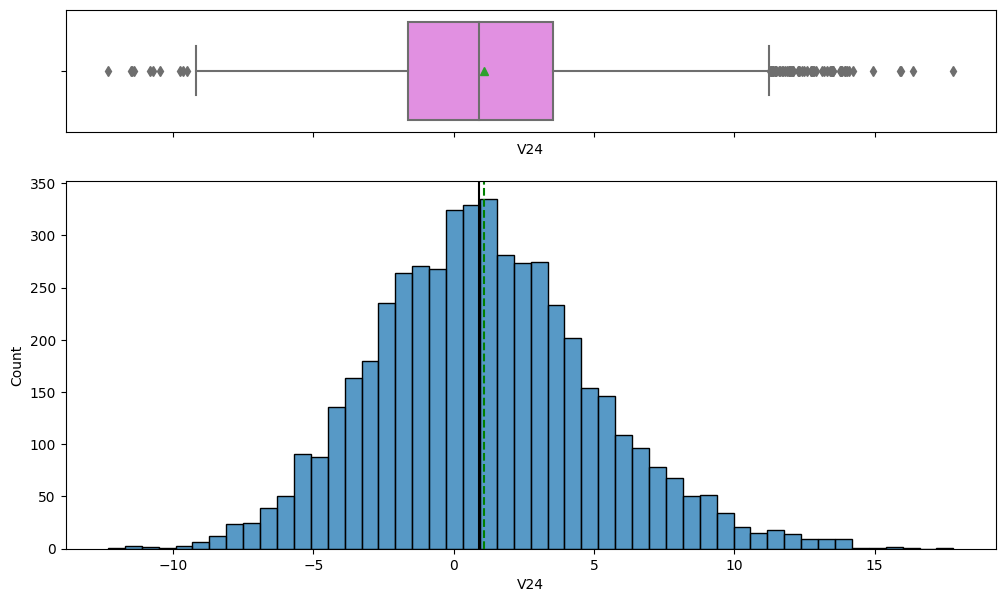

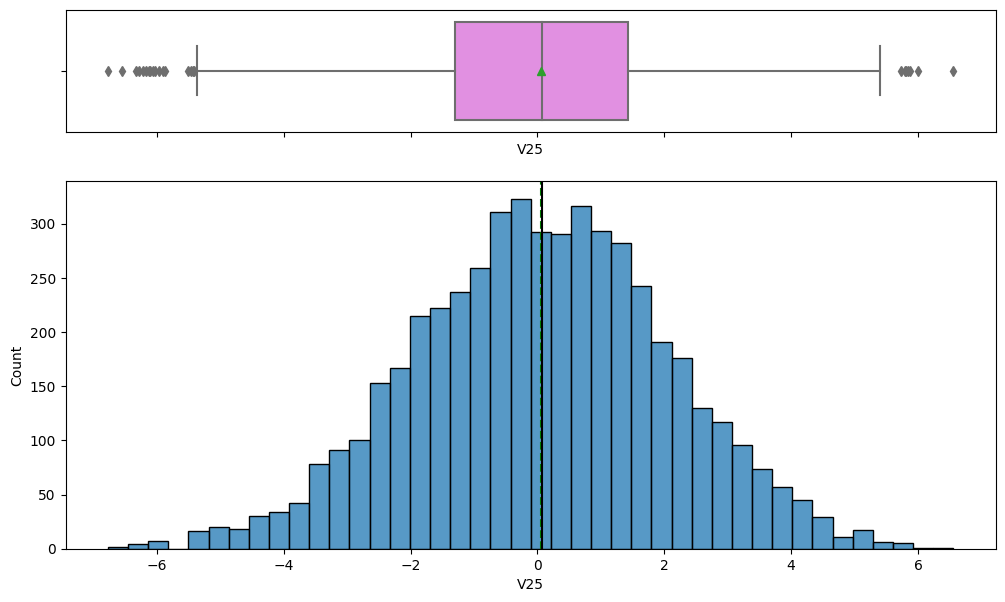

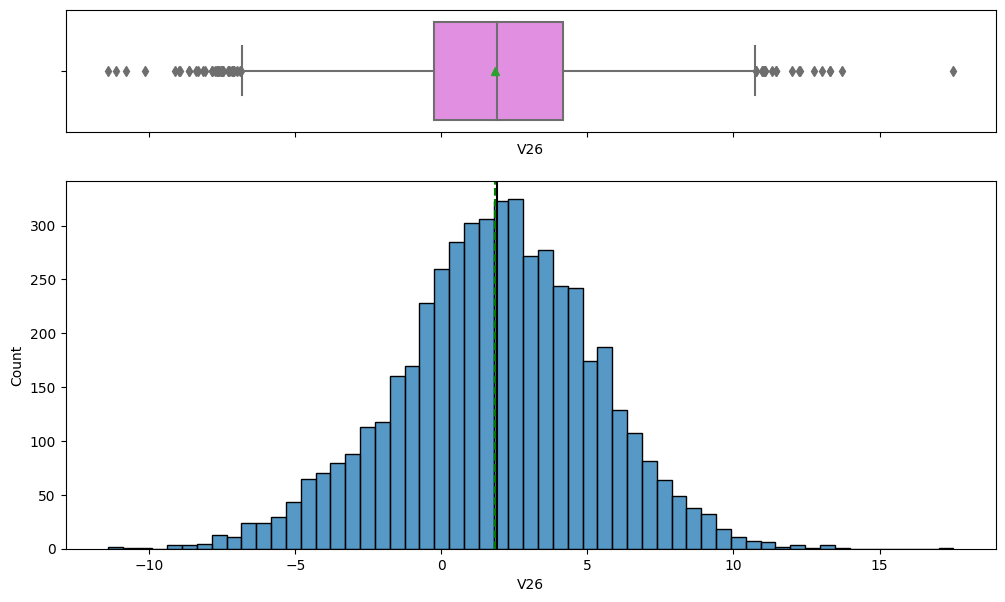

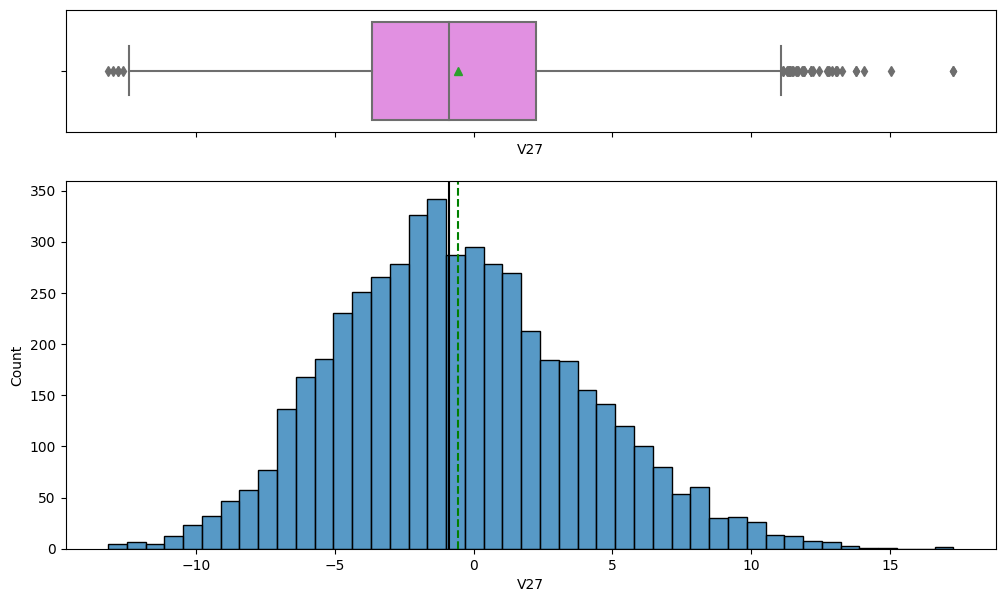

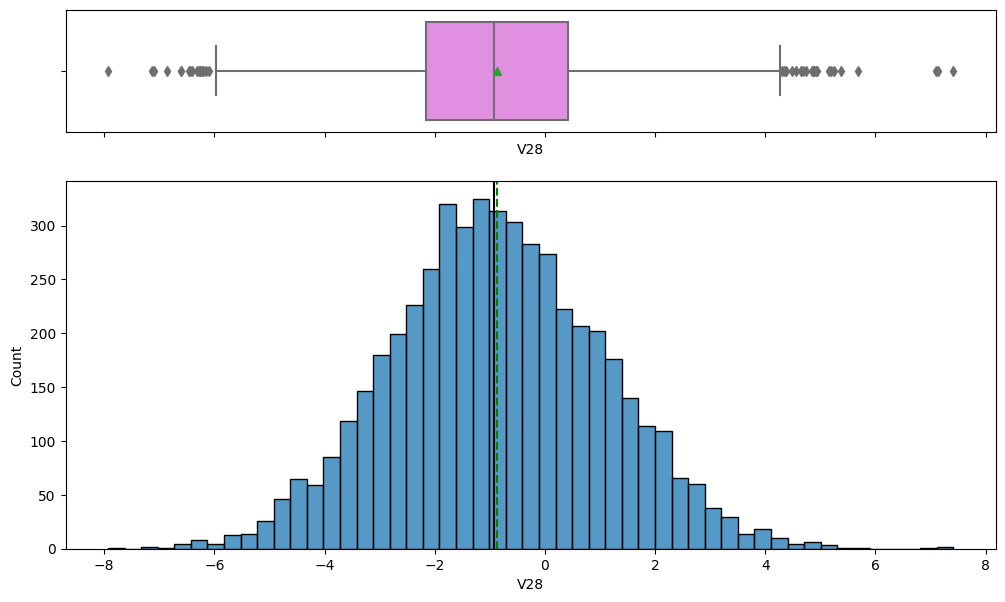

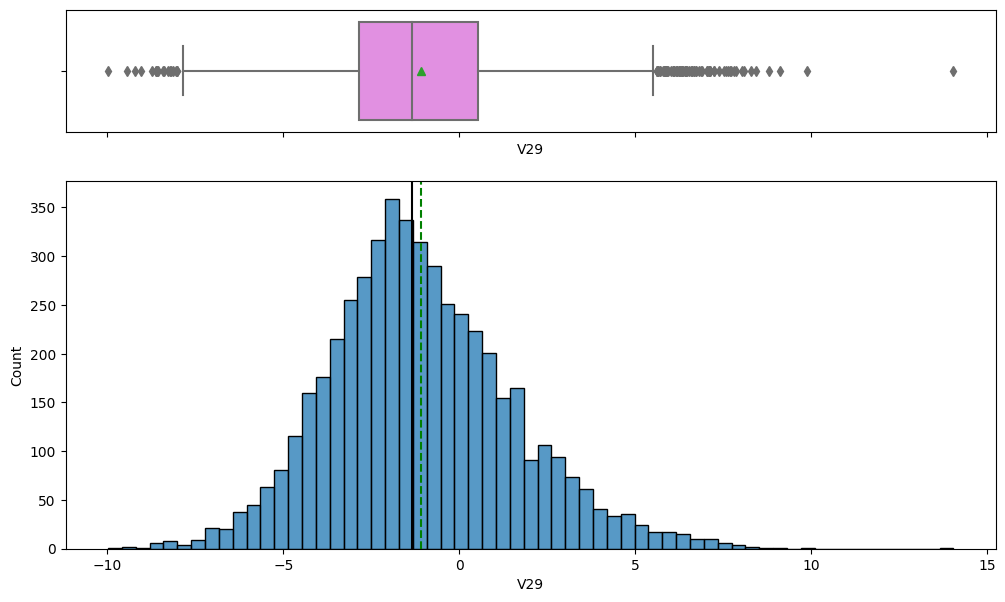

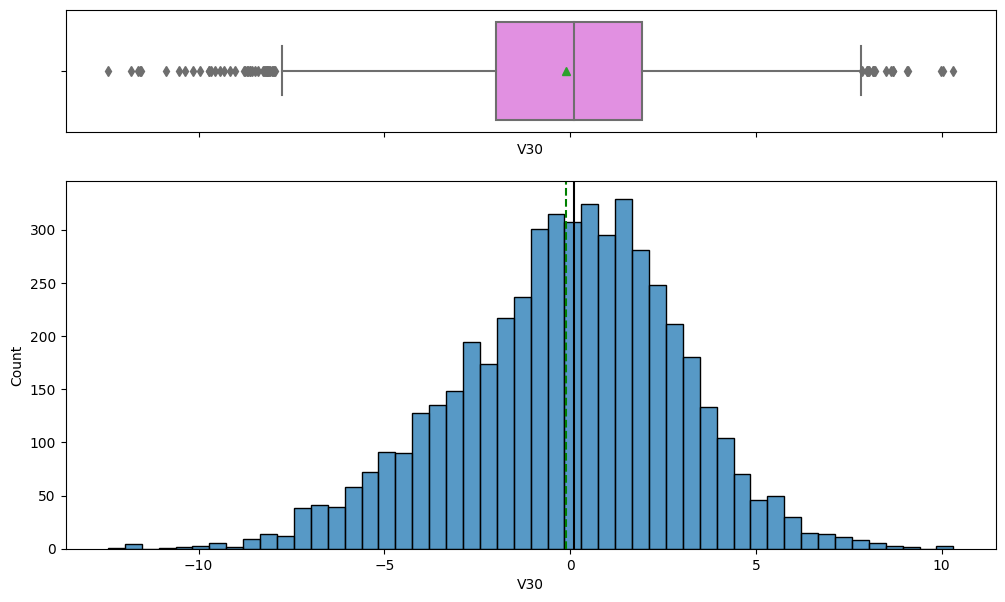

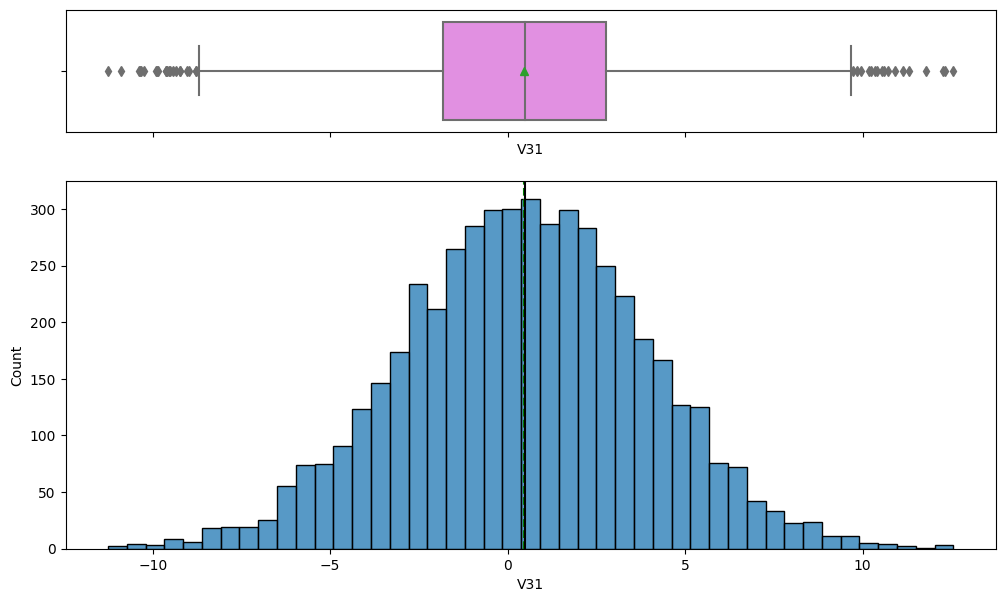

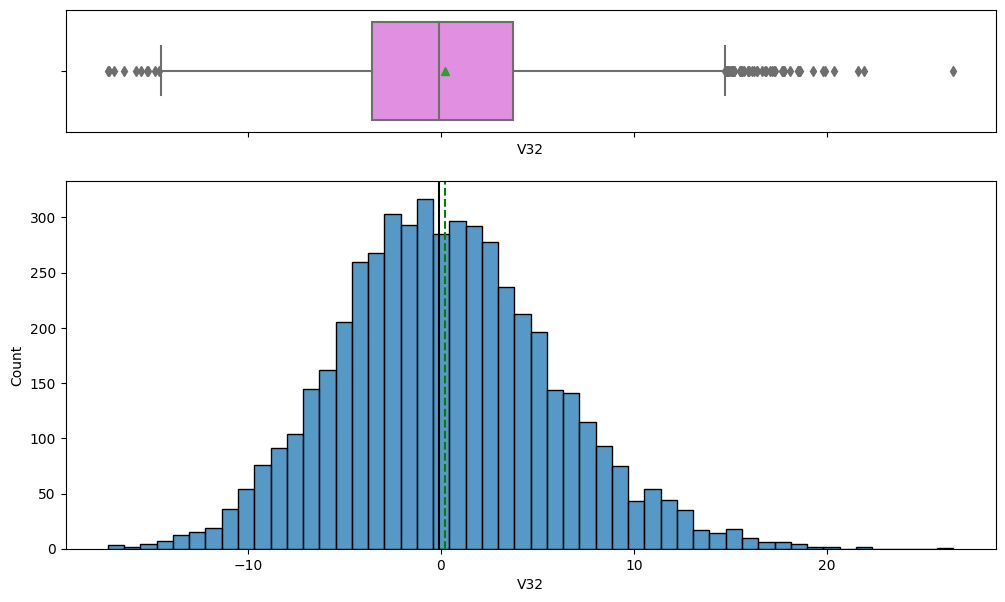

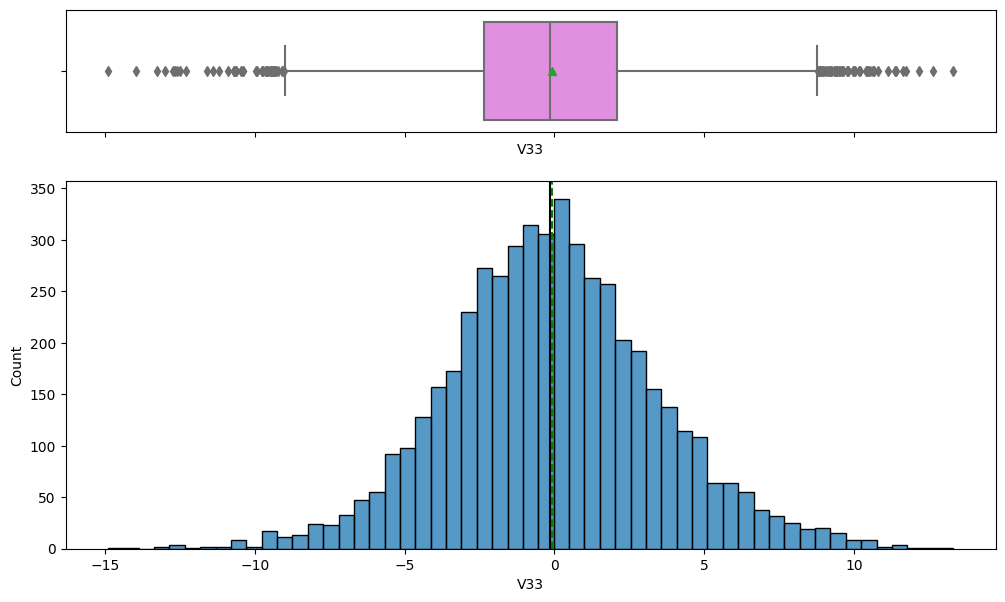

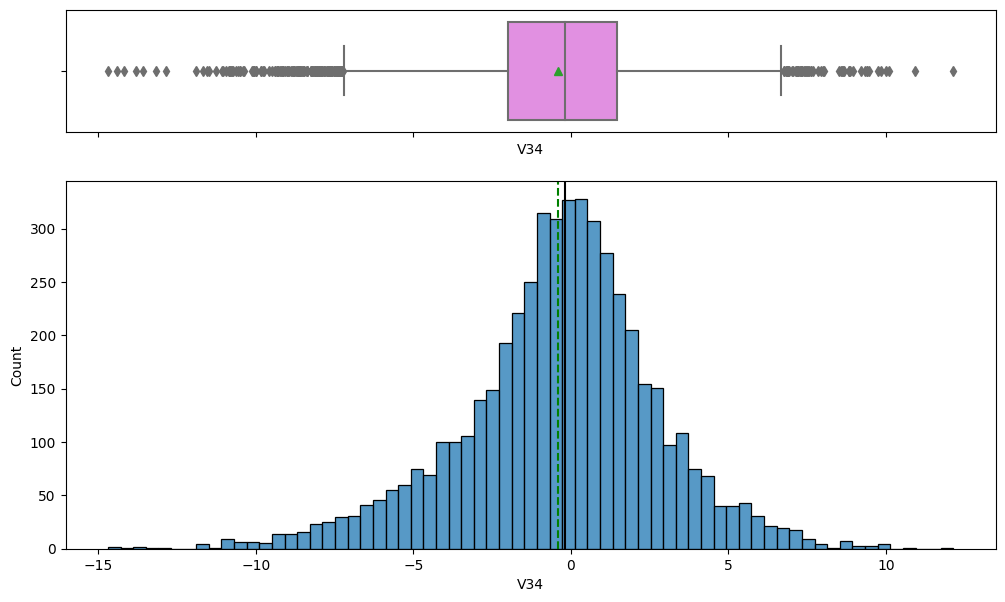

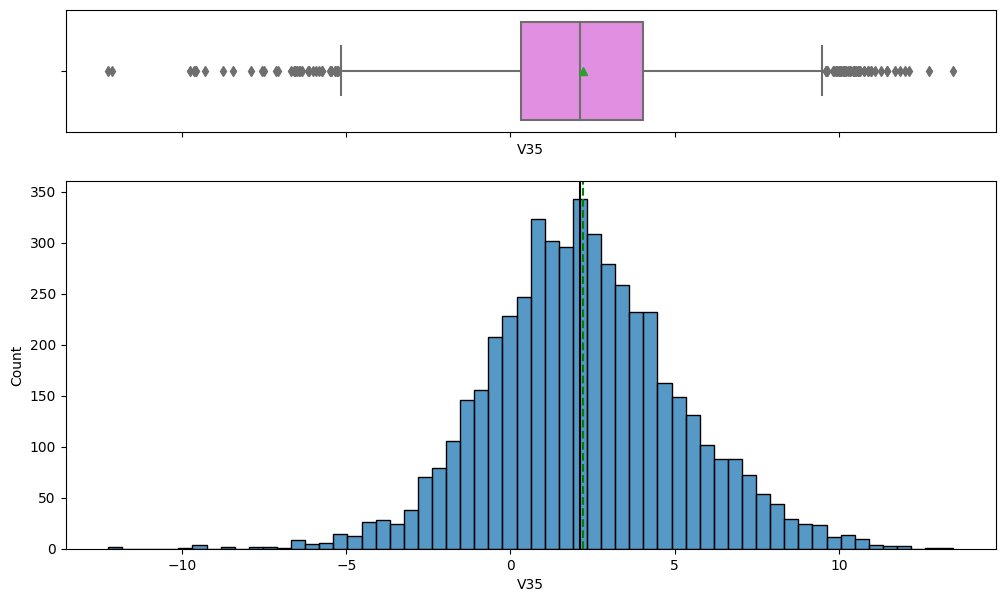

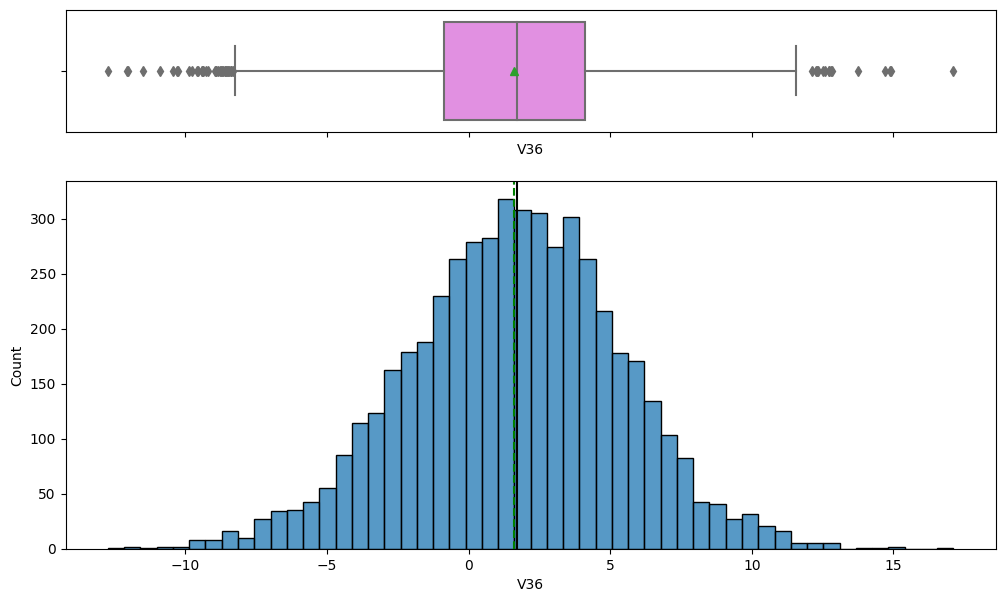

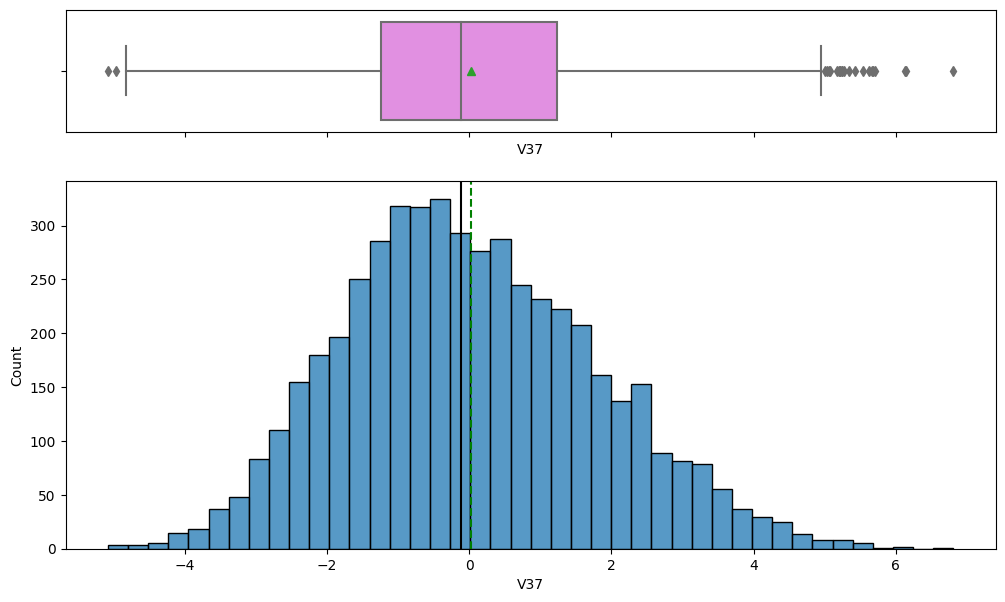

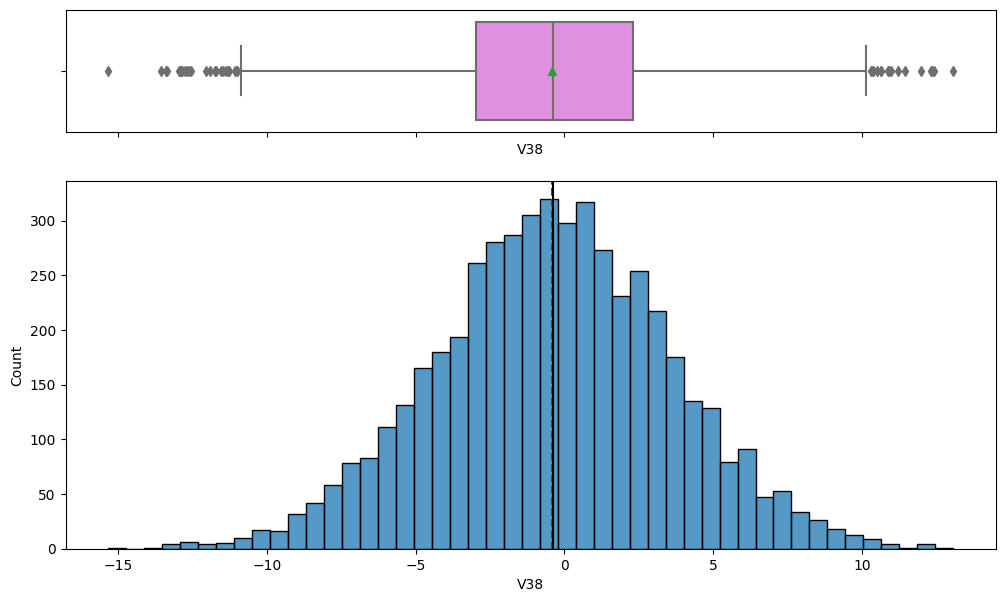

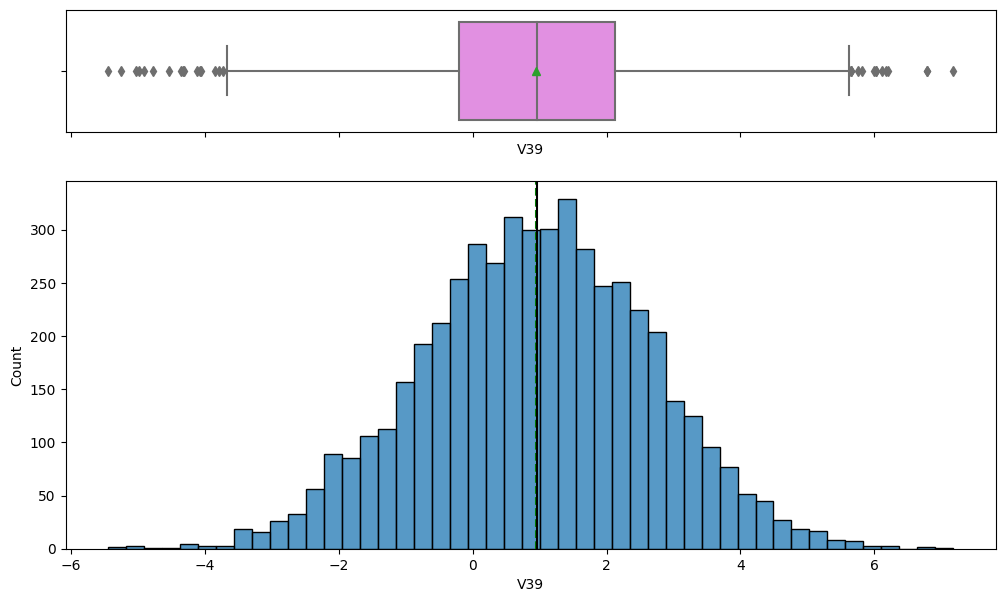

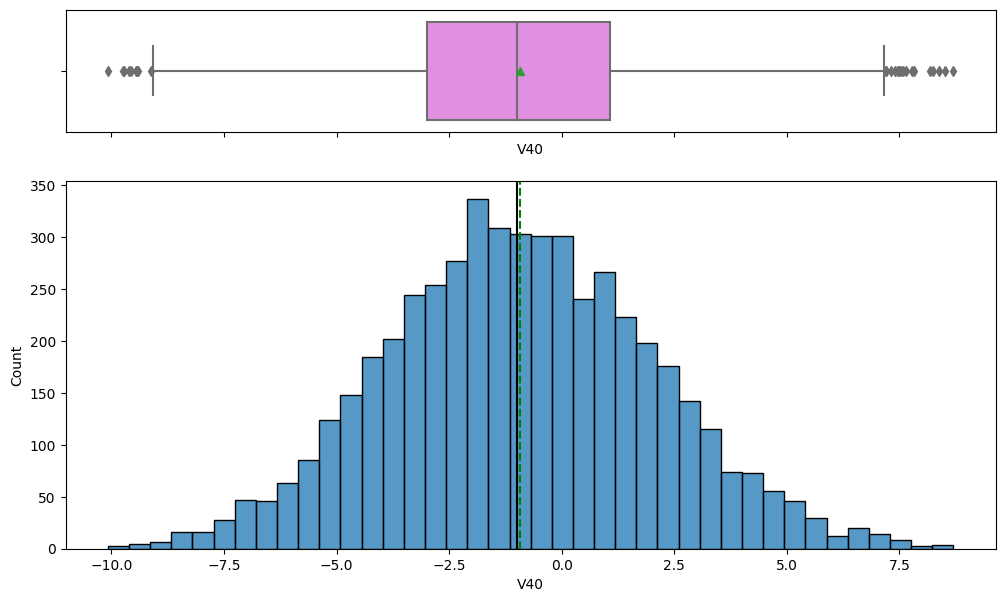

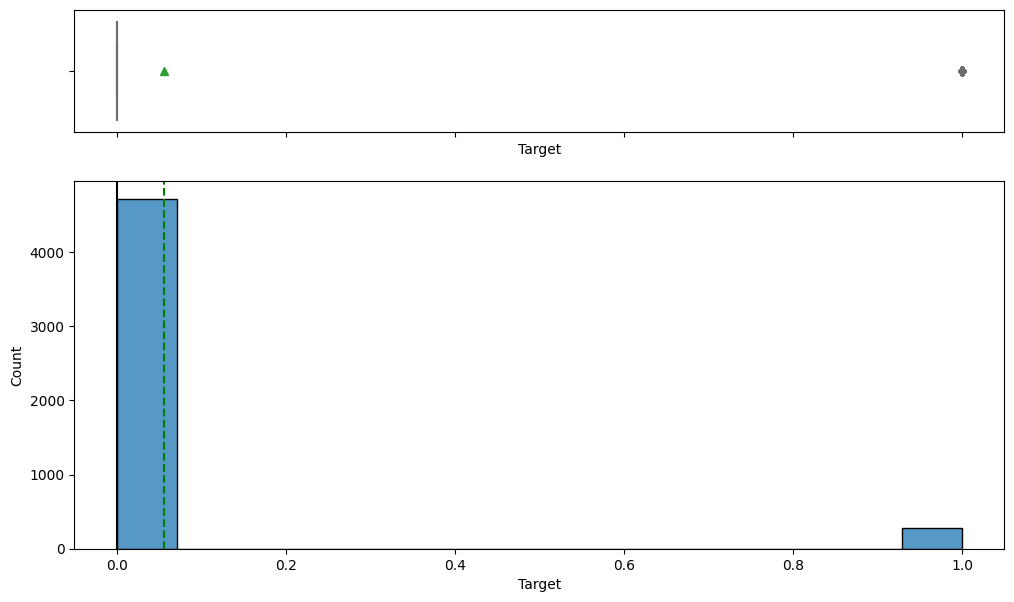

In [ ]:
for feature in TestD.columns:
    histogram_boxplot(TestD, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

### Bivariate Analysis os Test Data

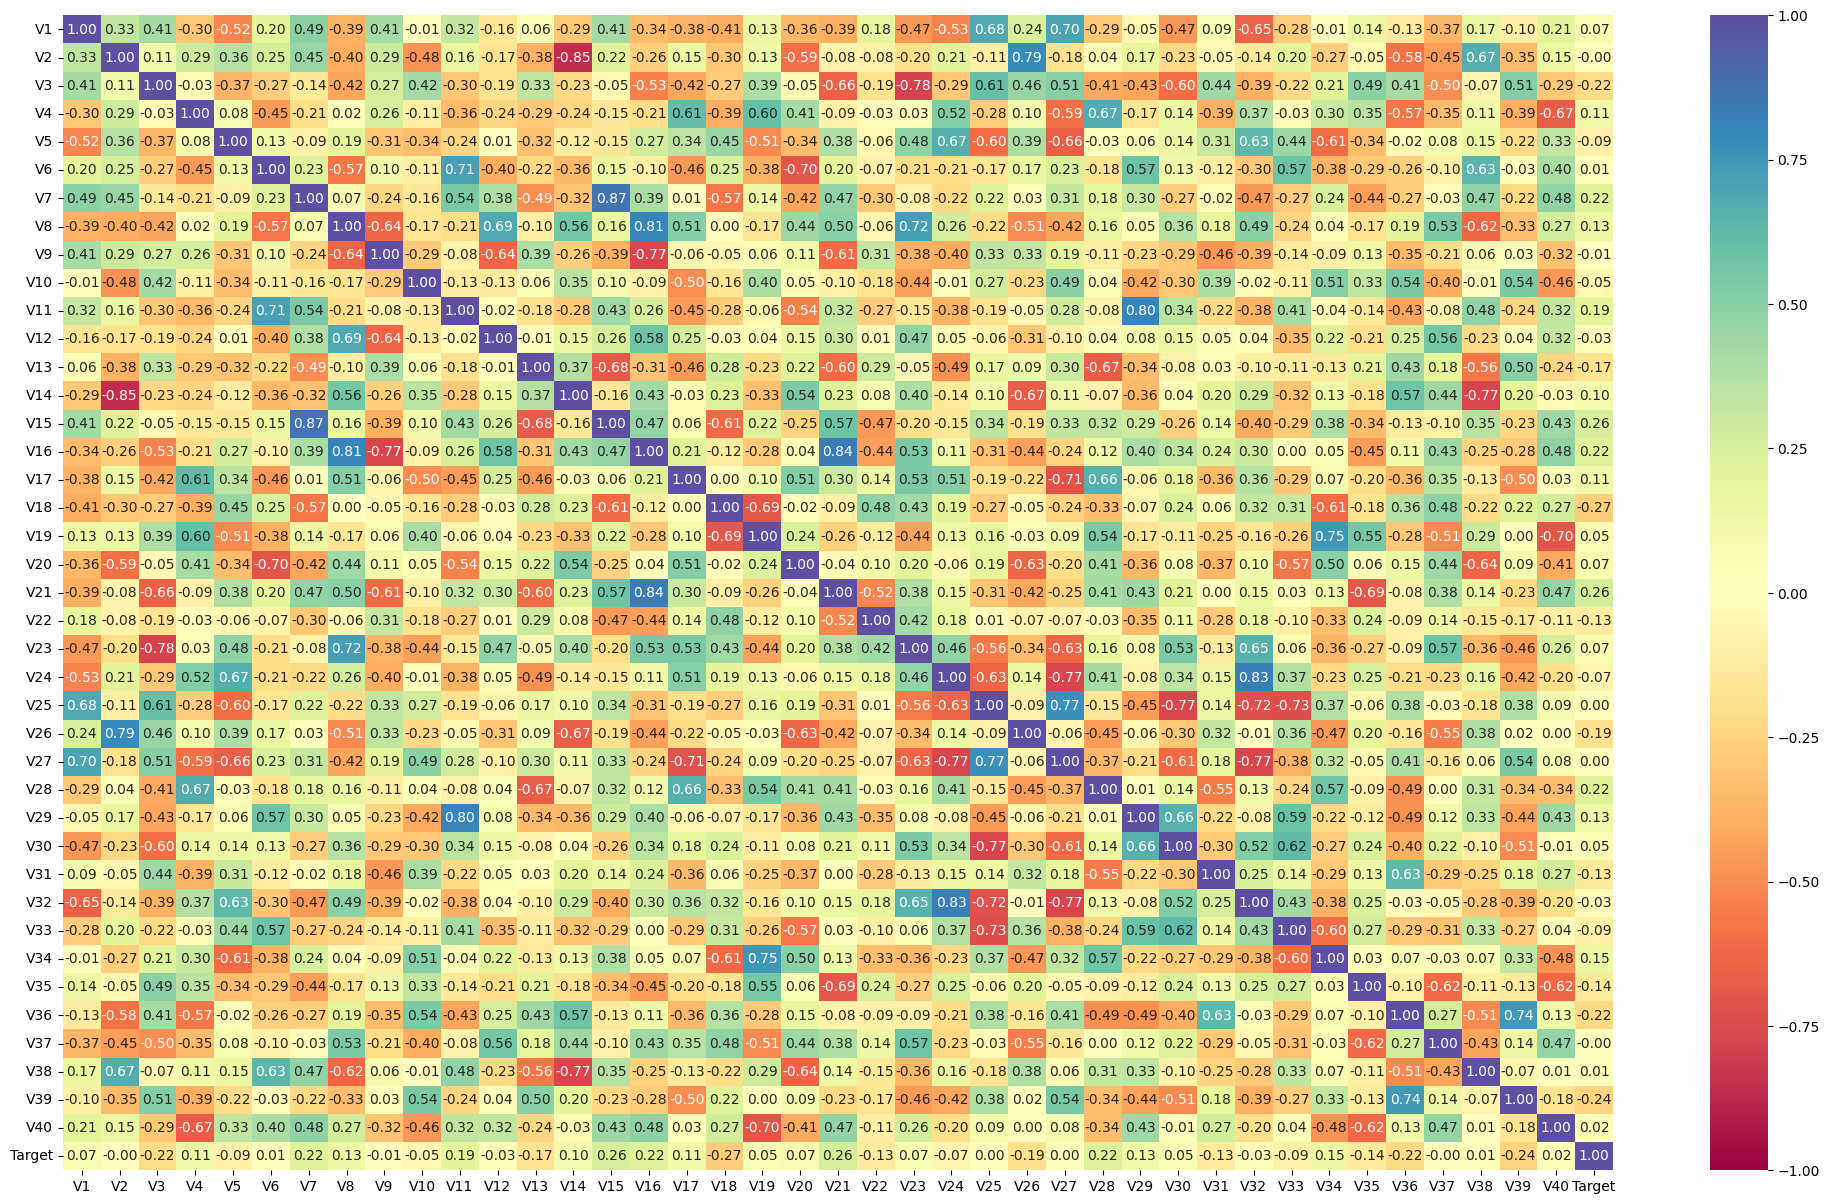

In [ ]:
plt.figure(figsize=(25, 15))
sns.heatmap(TestD.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

### Ploting the Features of the Train Data

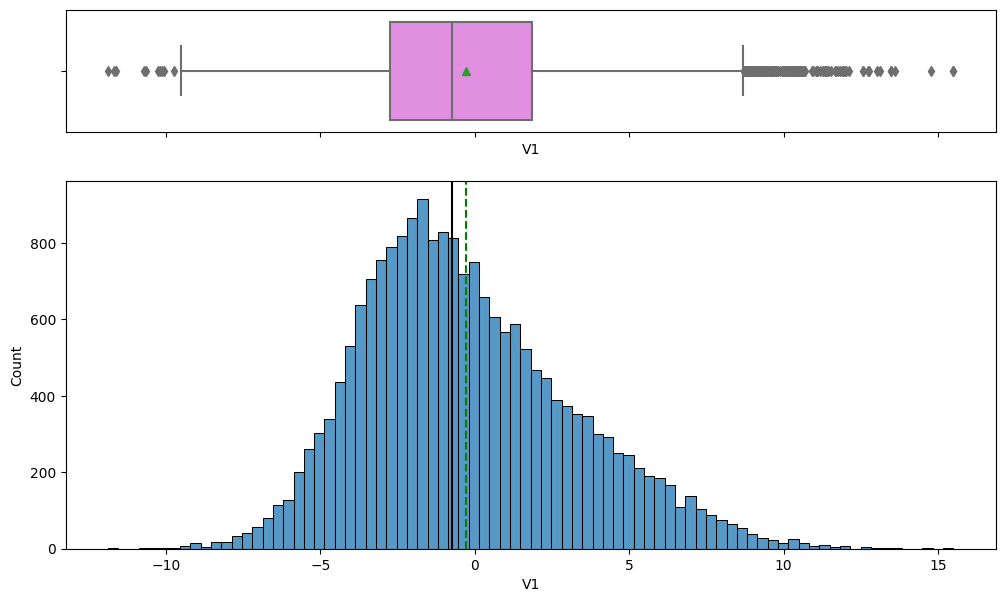

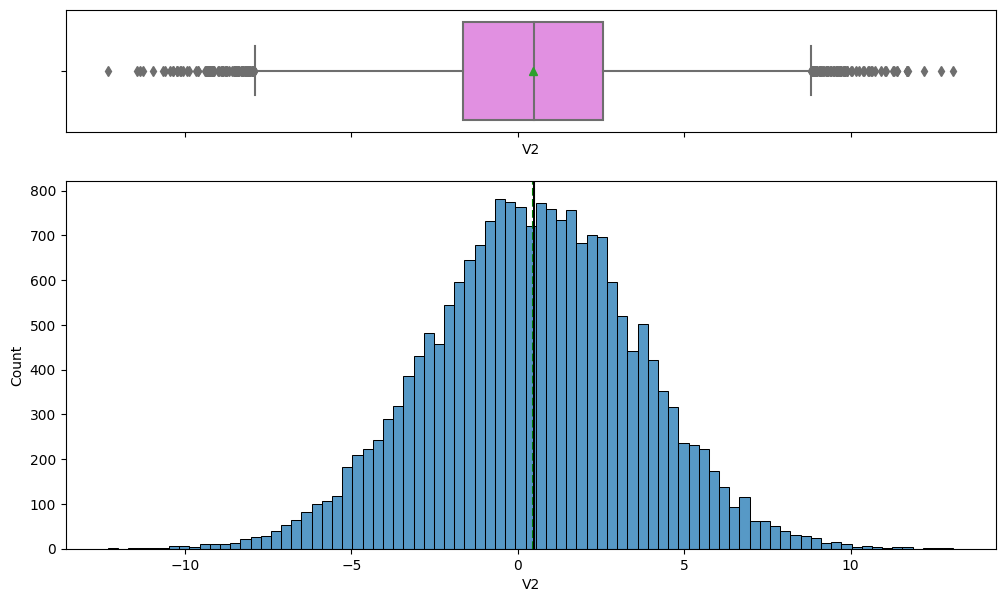

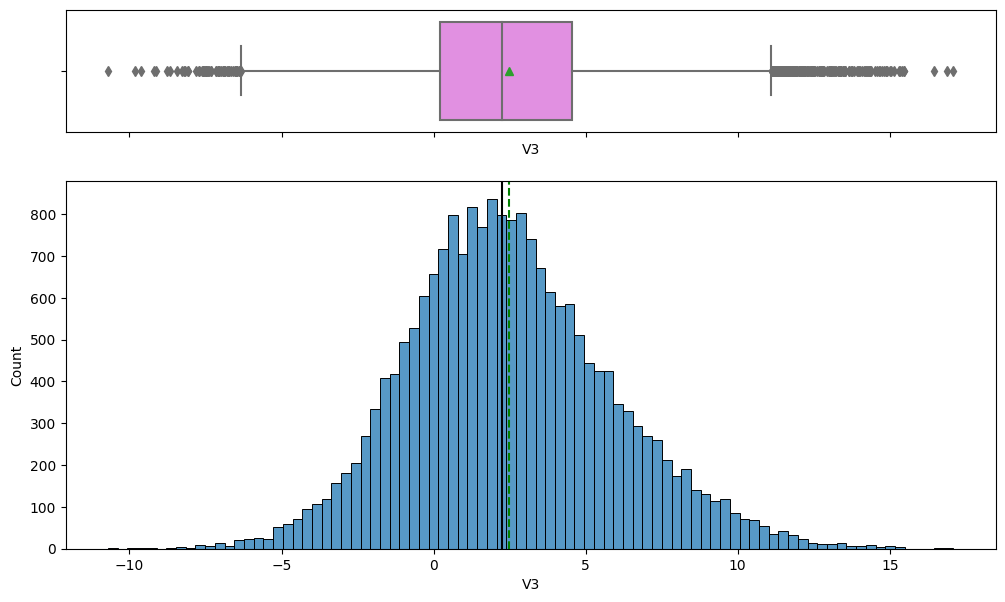

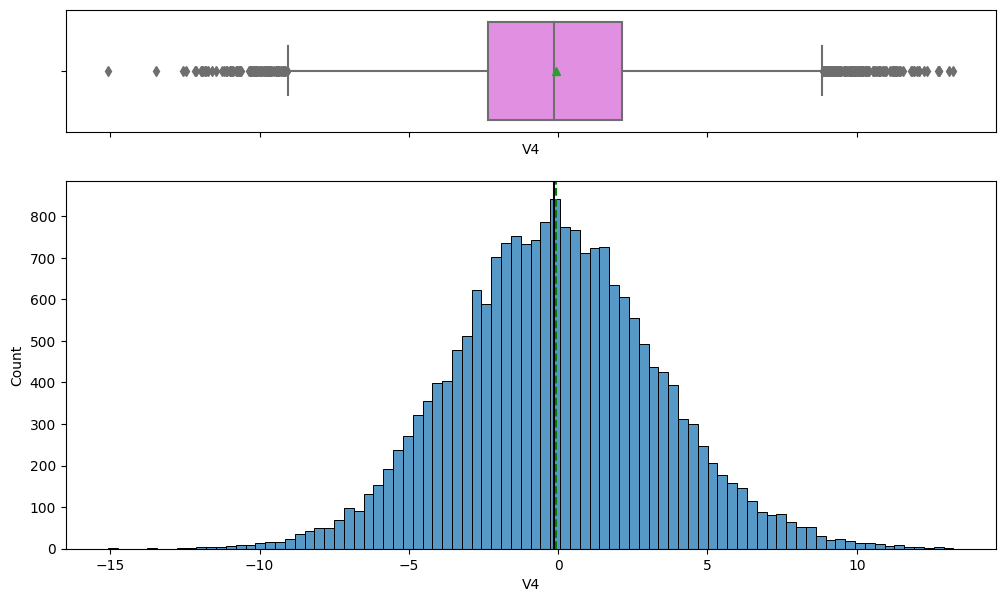

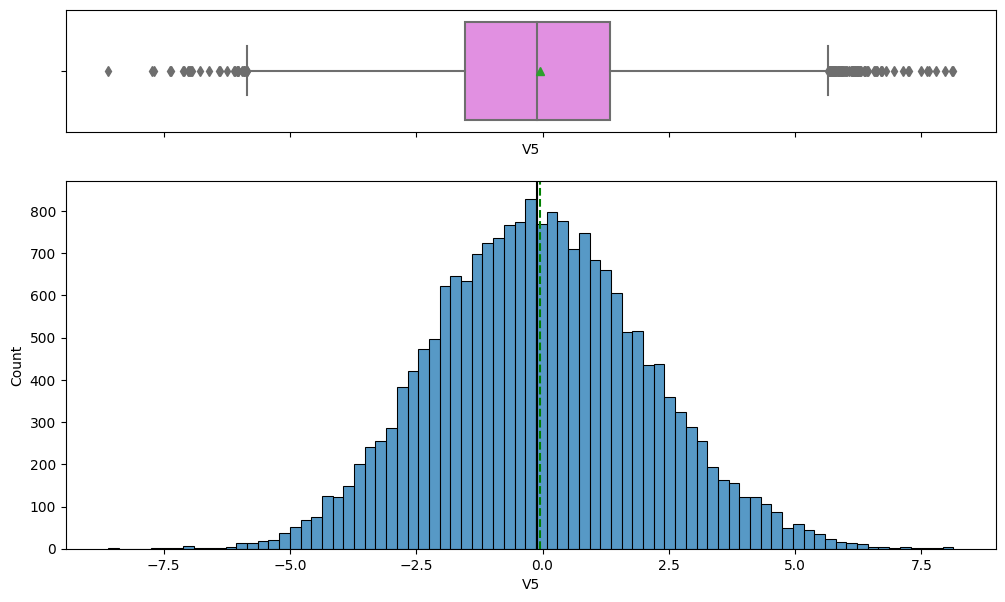

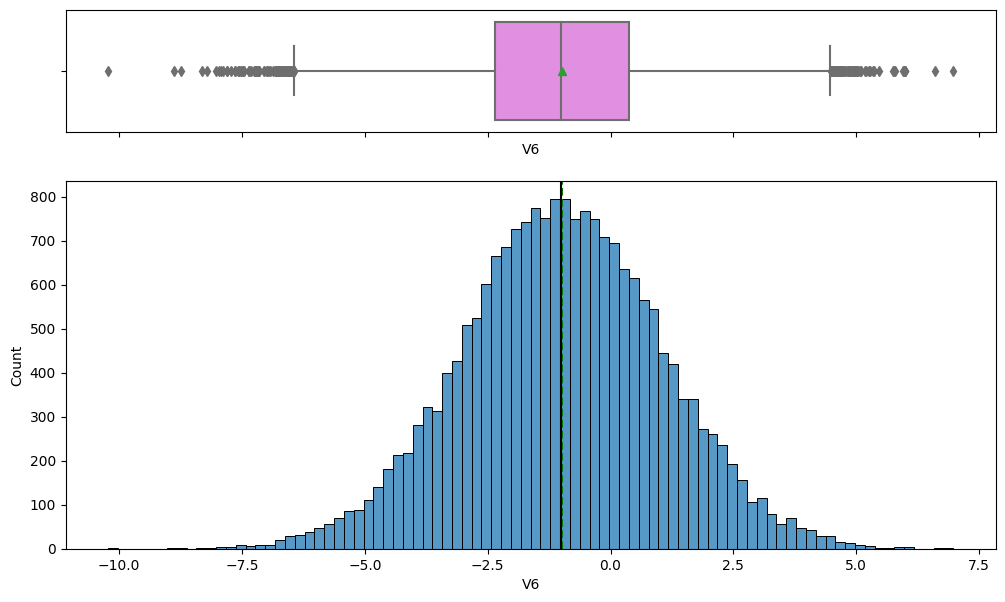

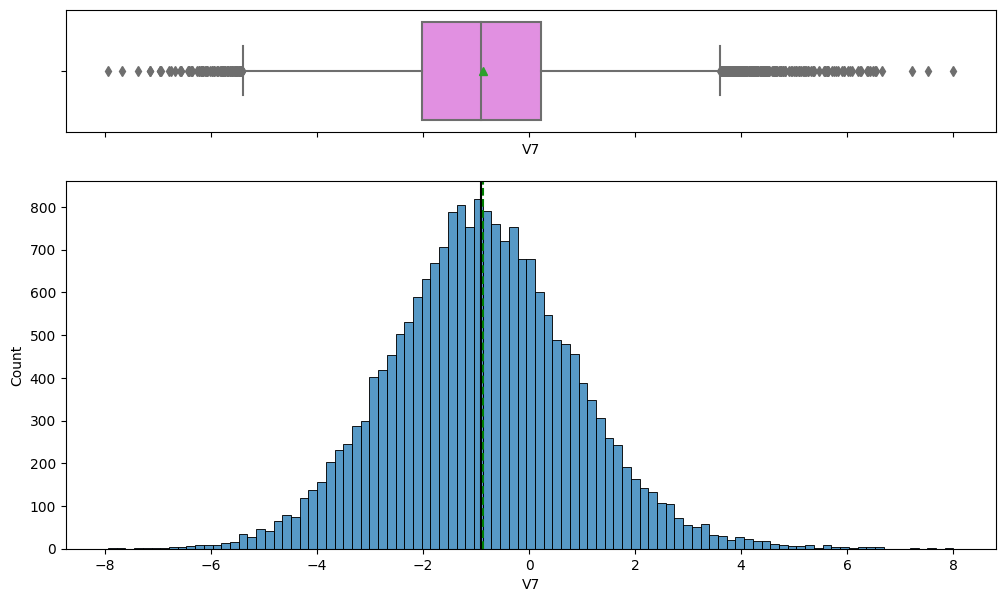

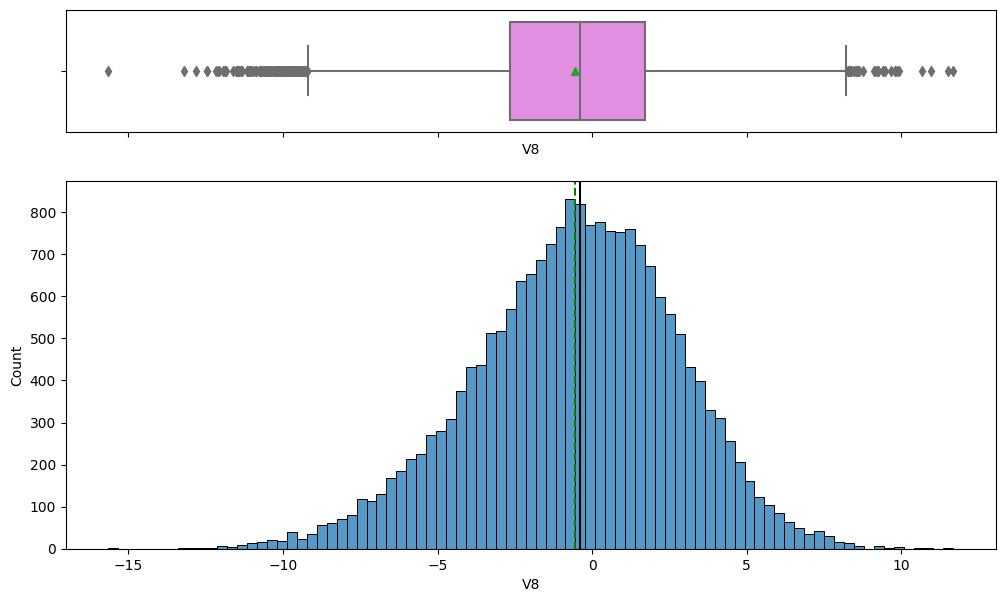

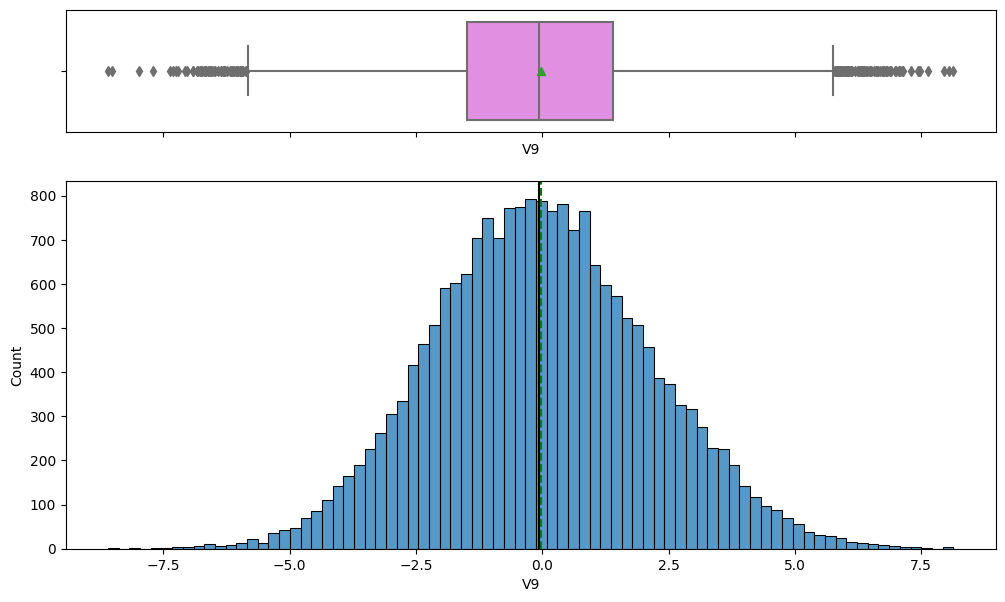

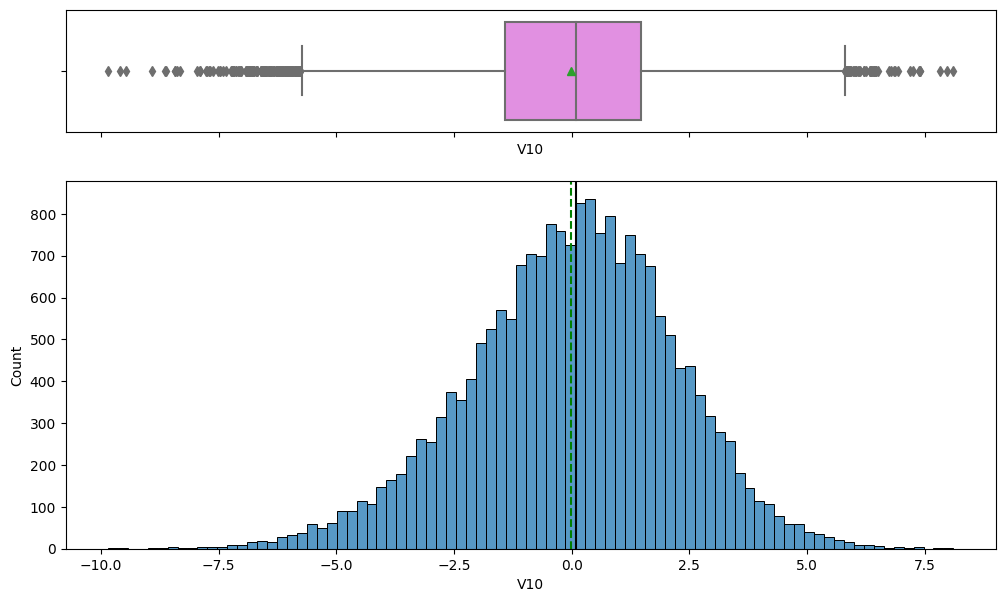

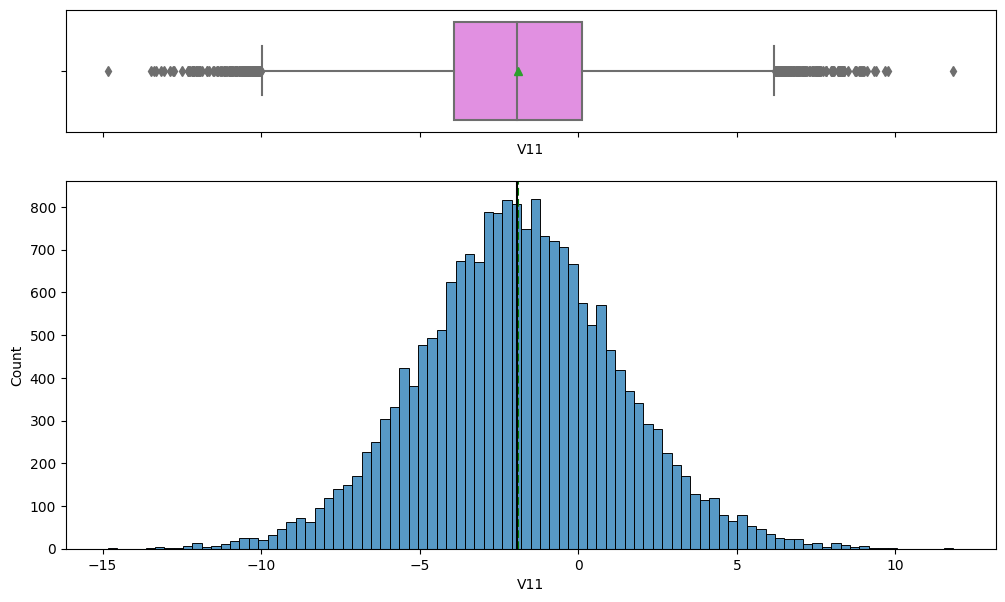

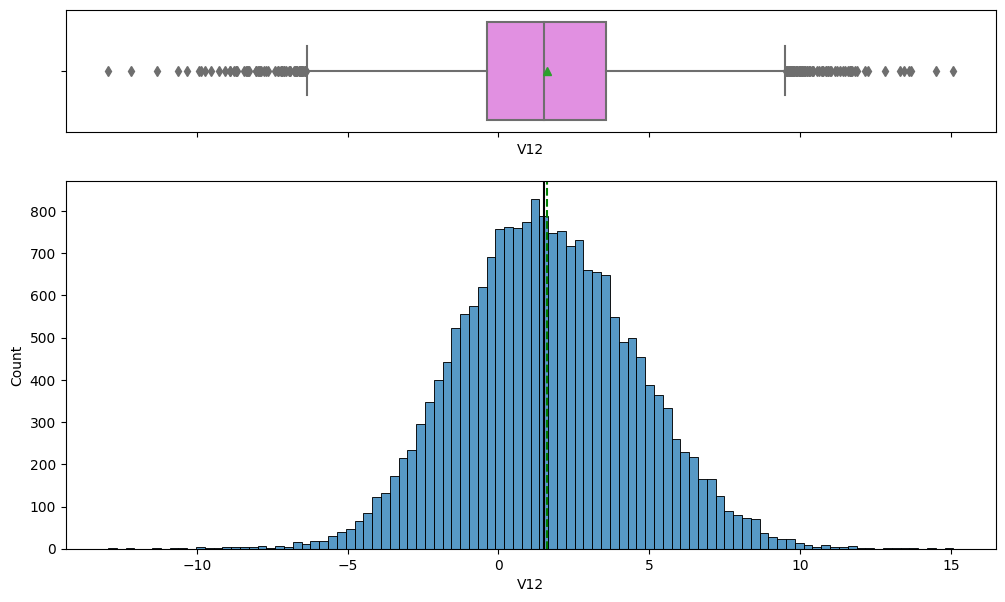

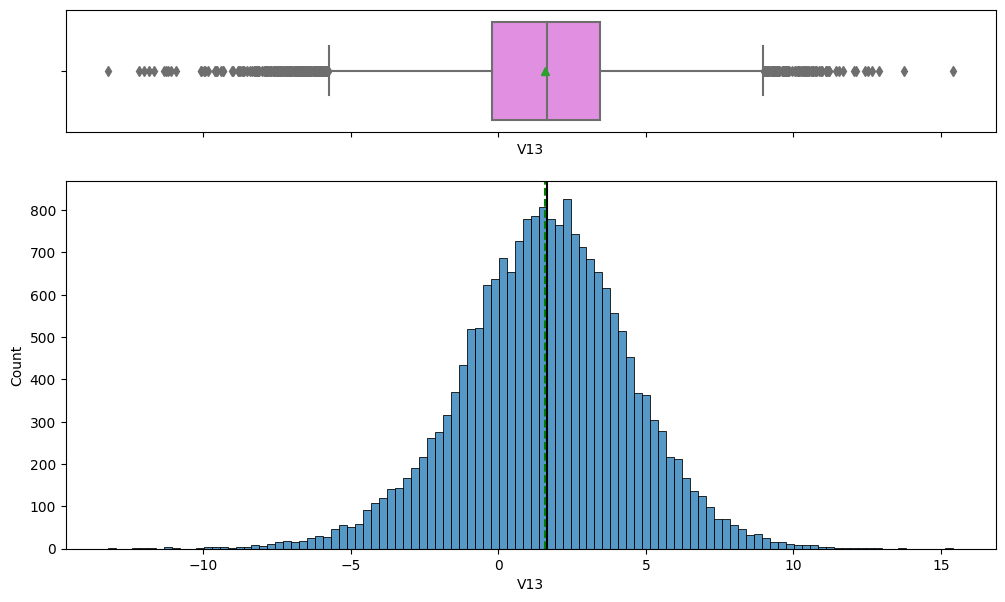

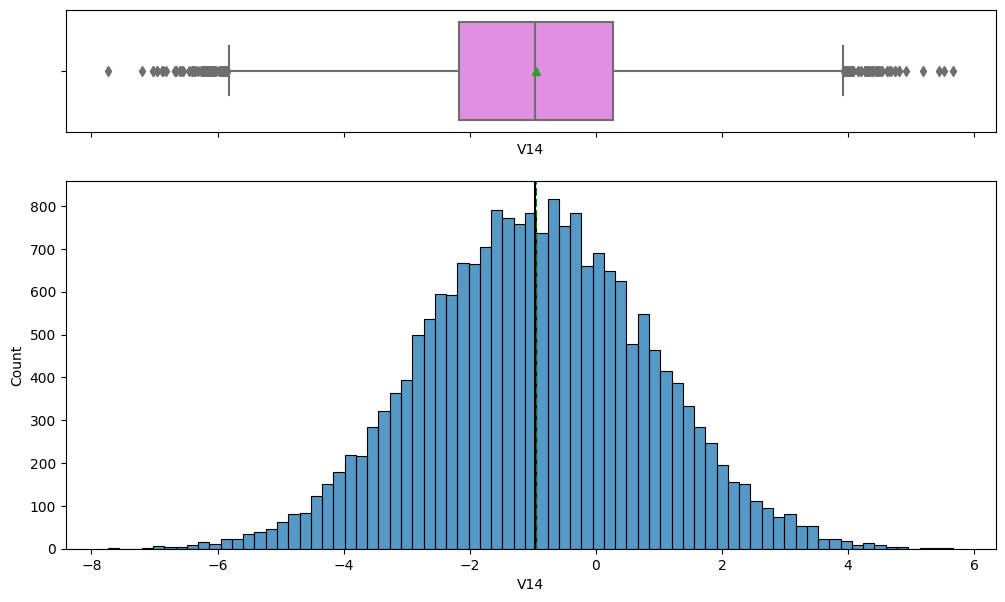

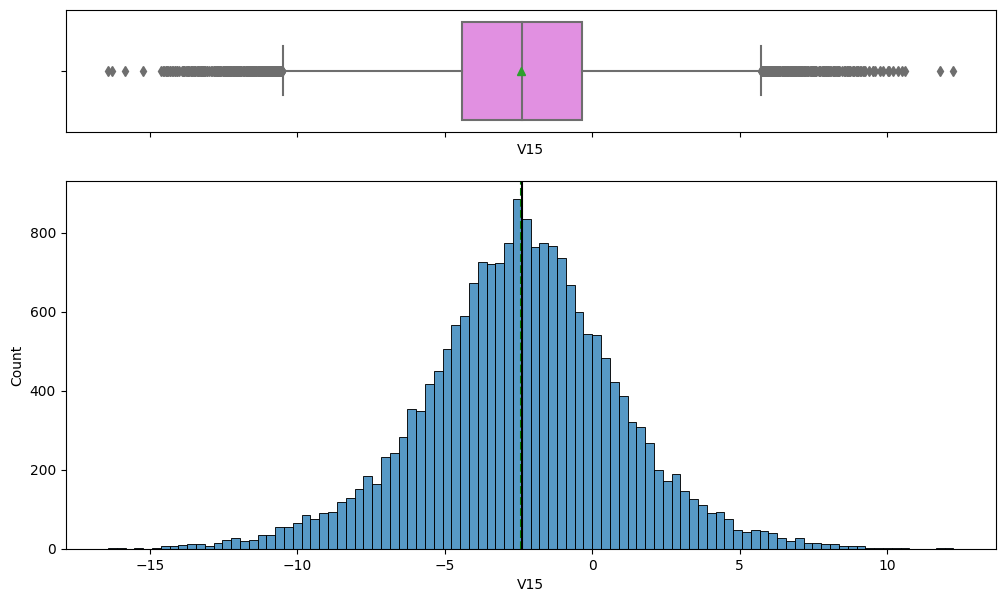

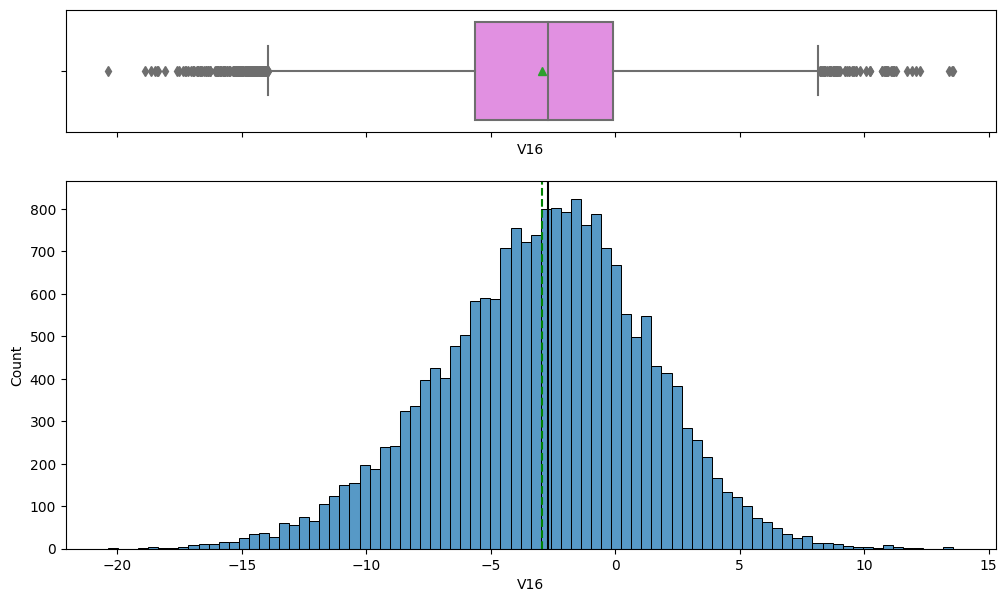

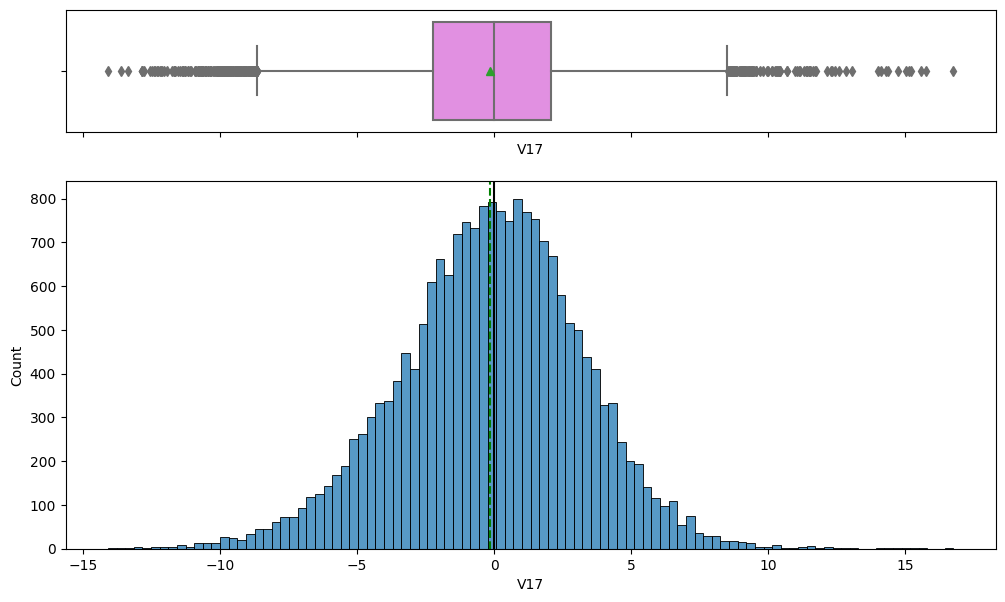

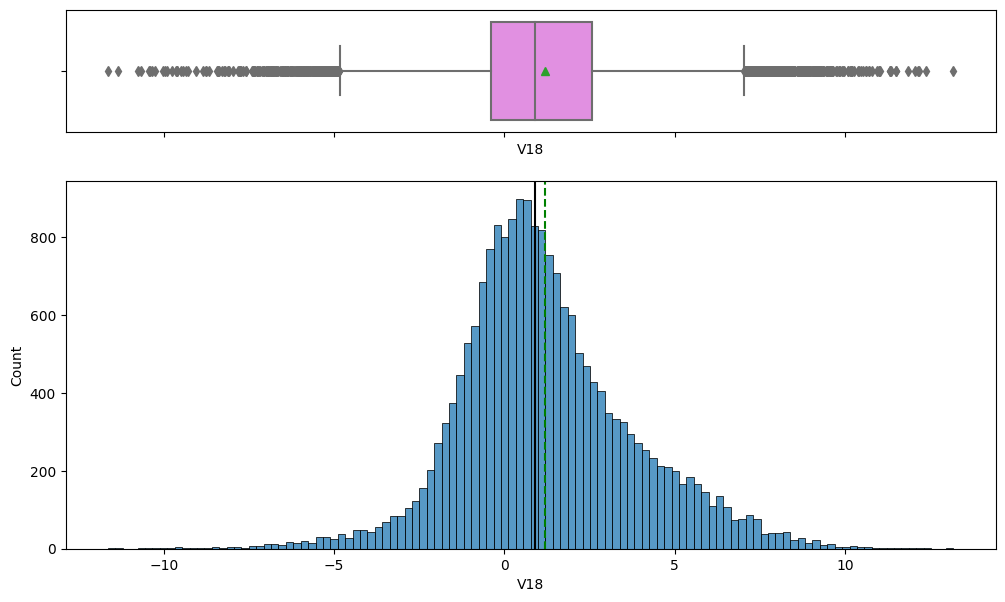

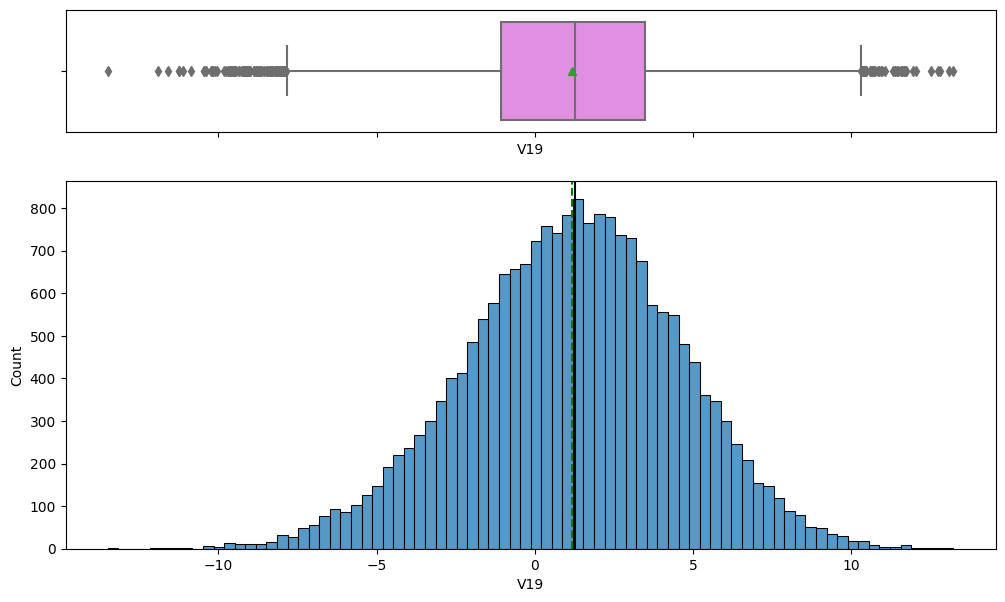

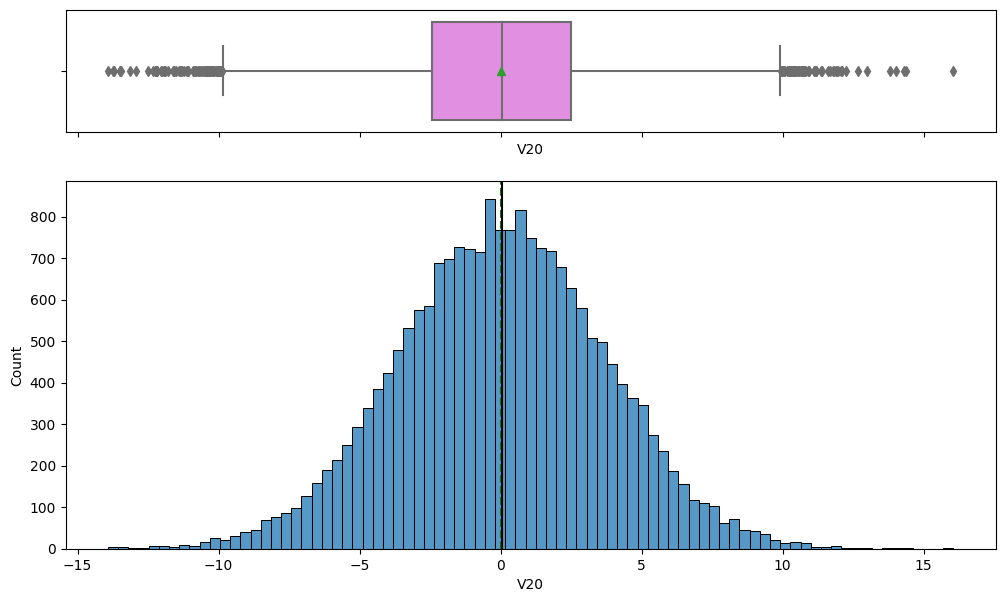

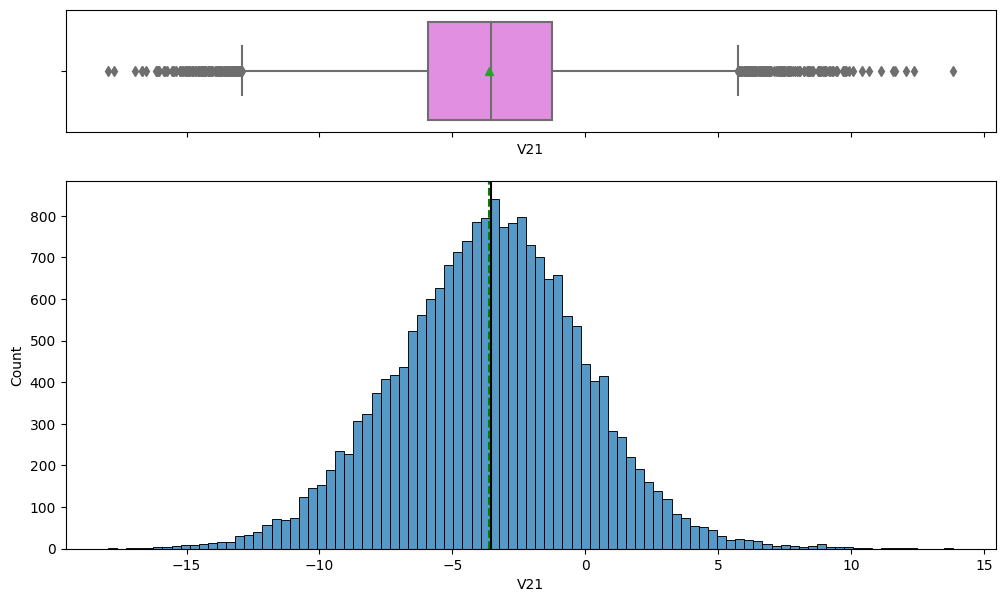

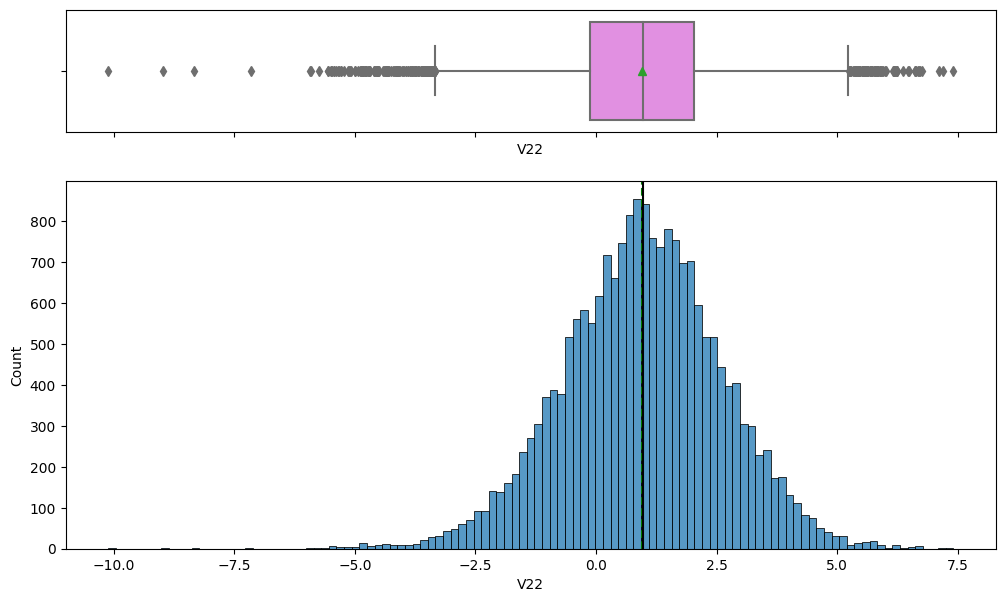

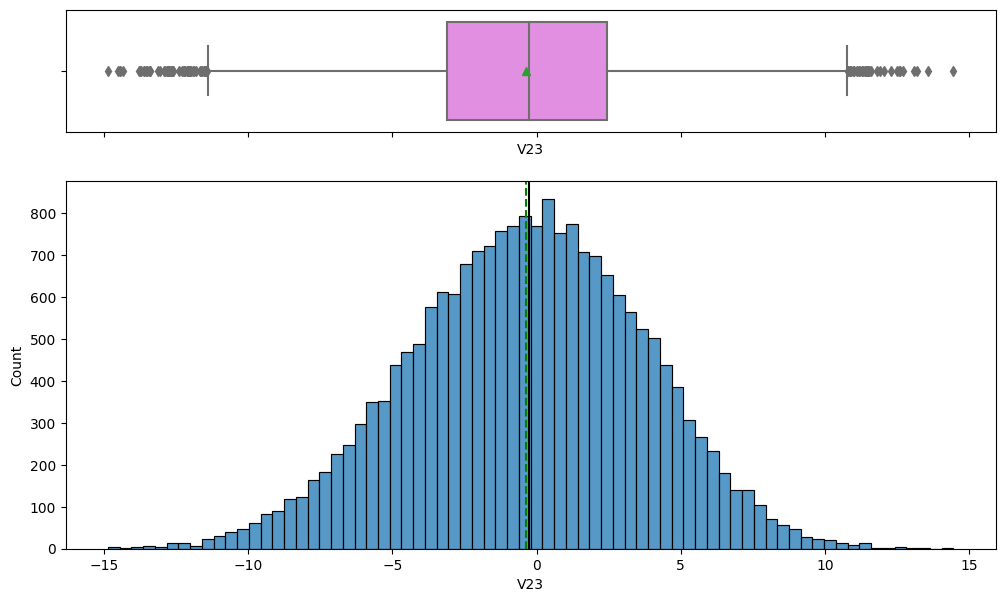

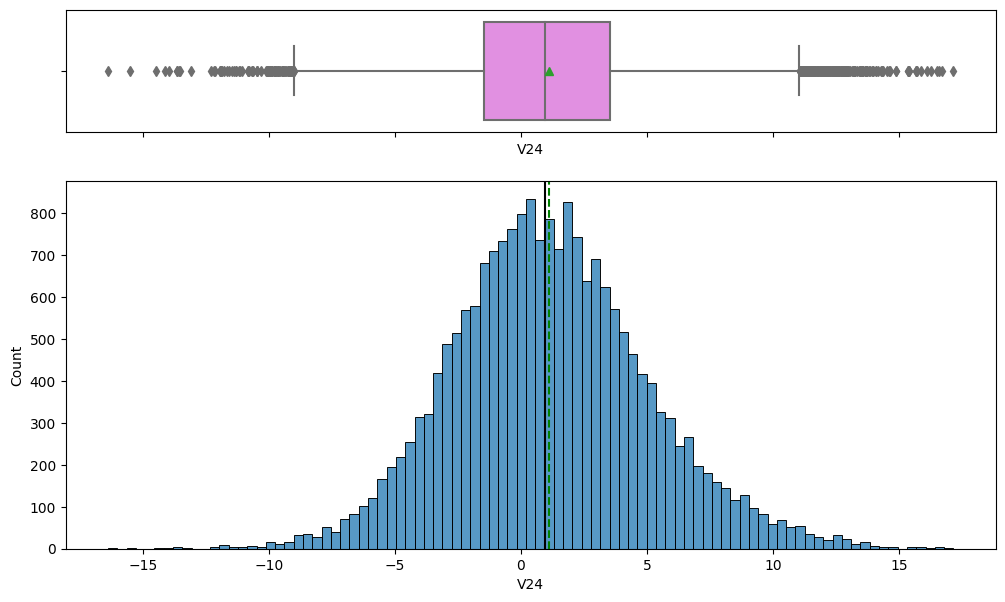

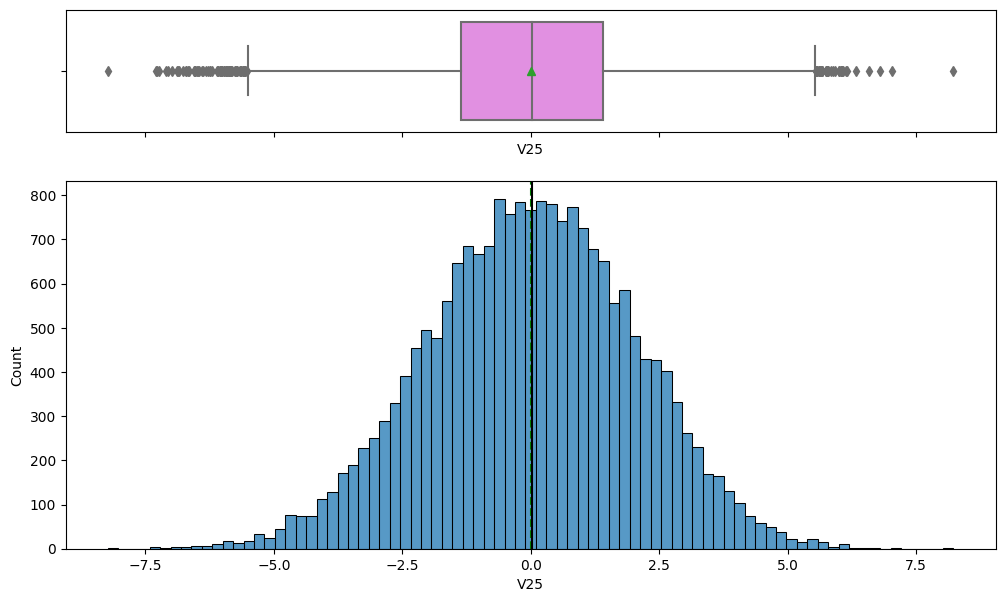

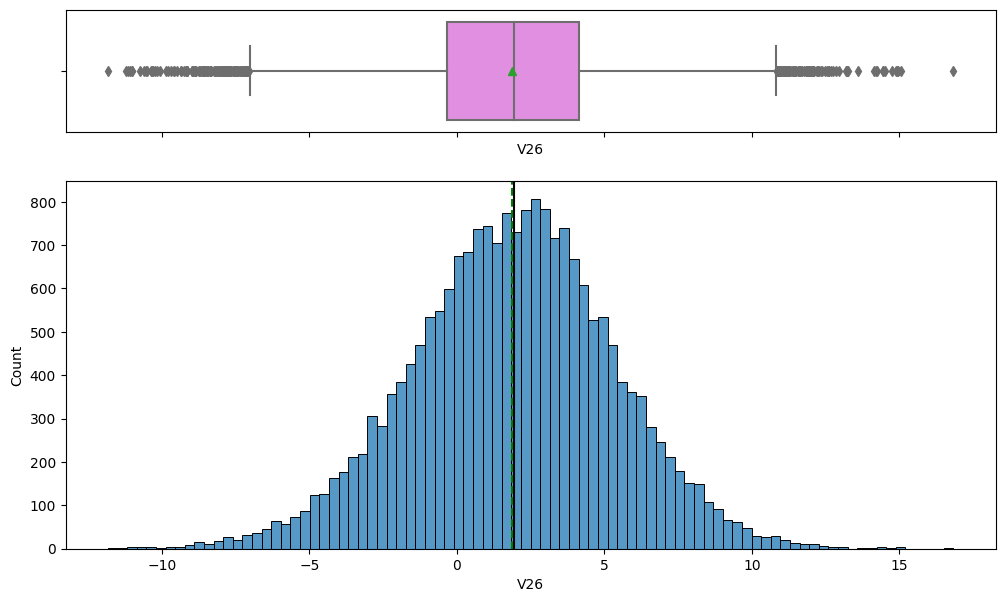

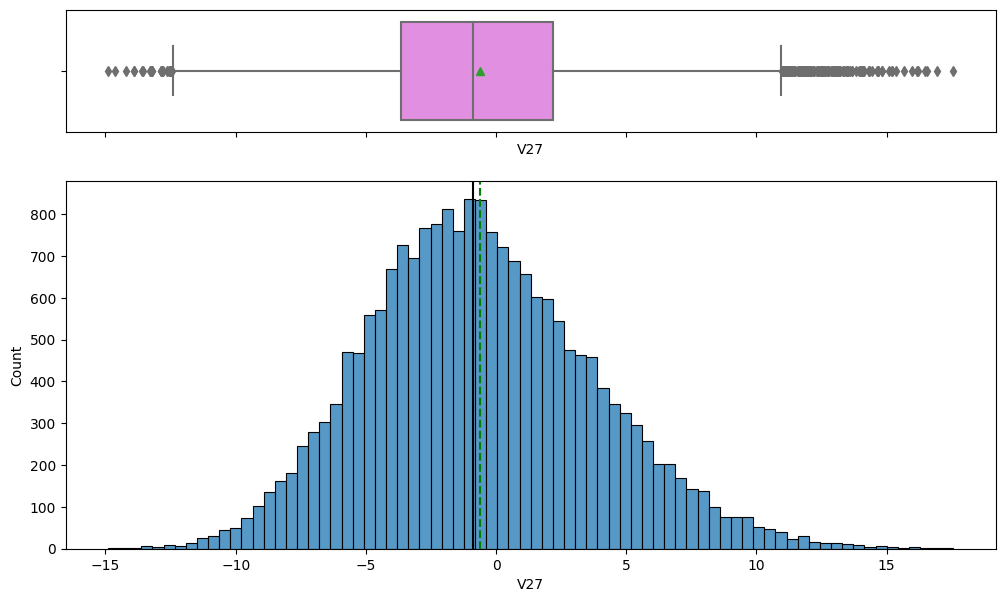

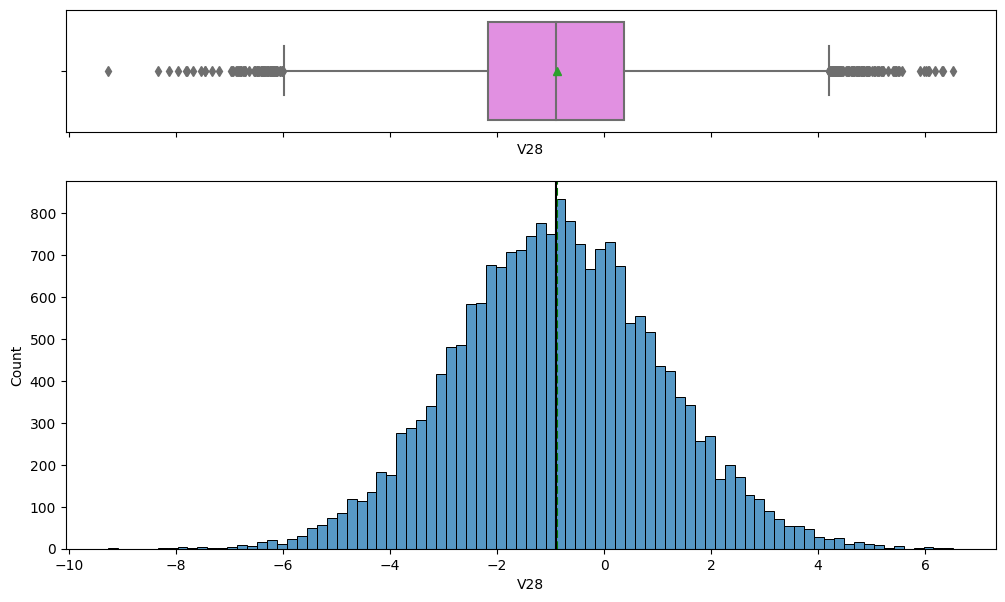

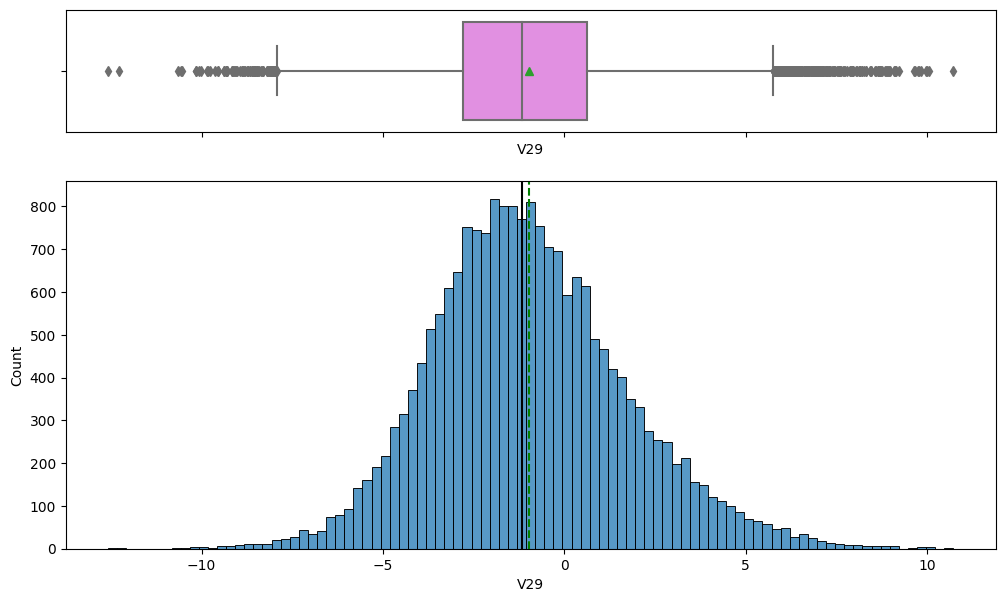

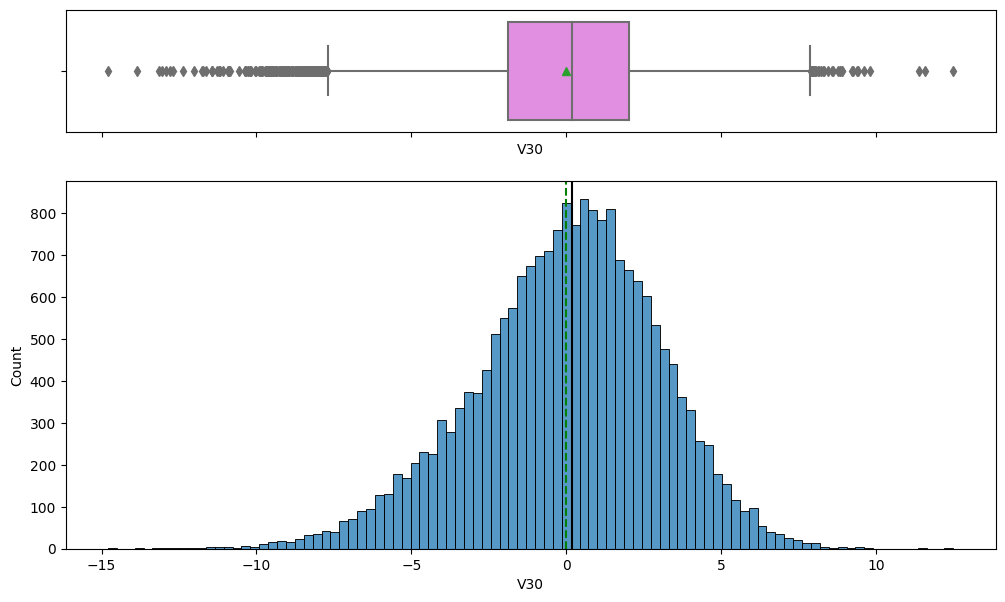

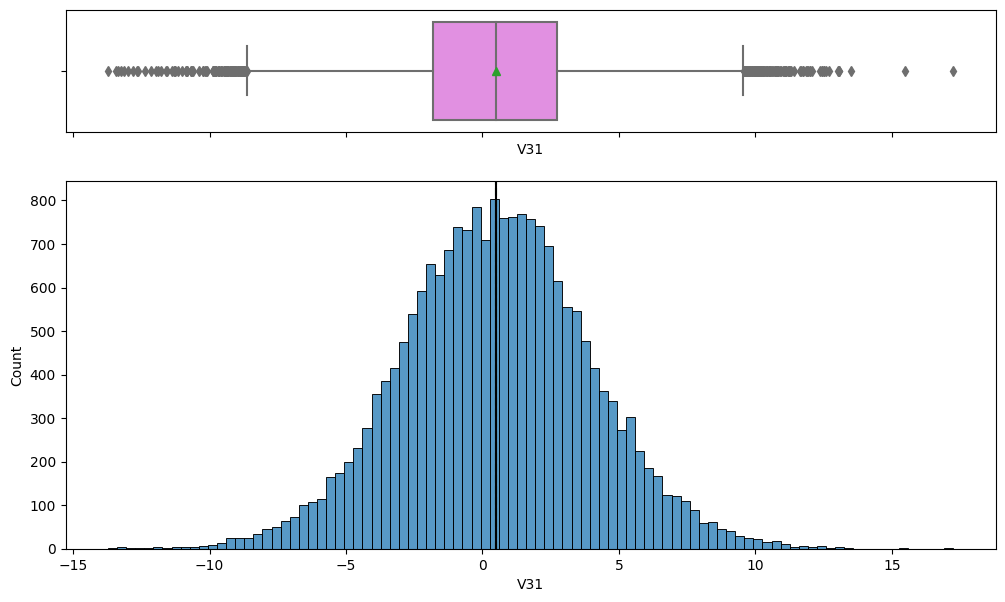

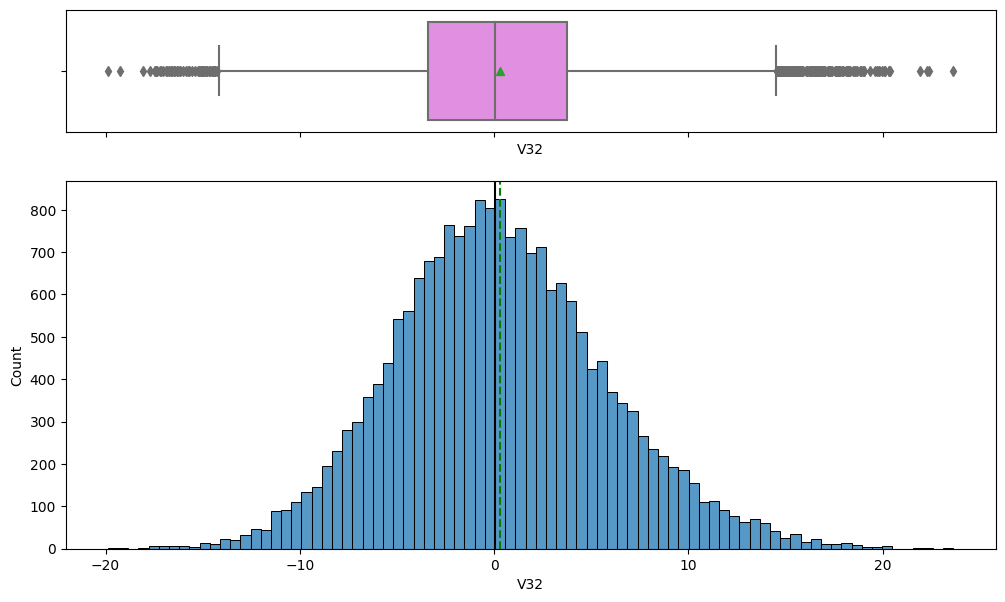

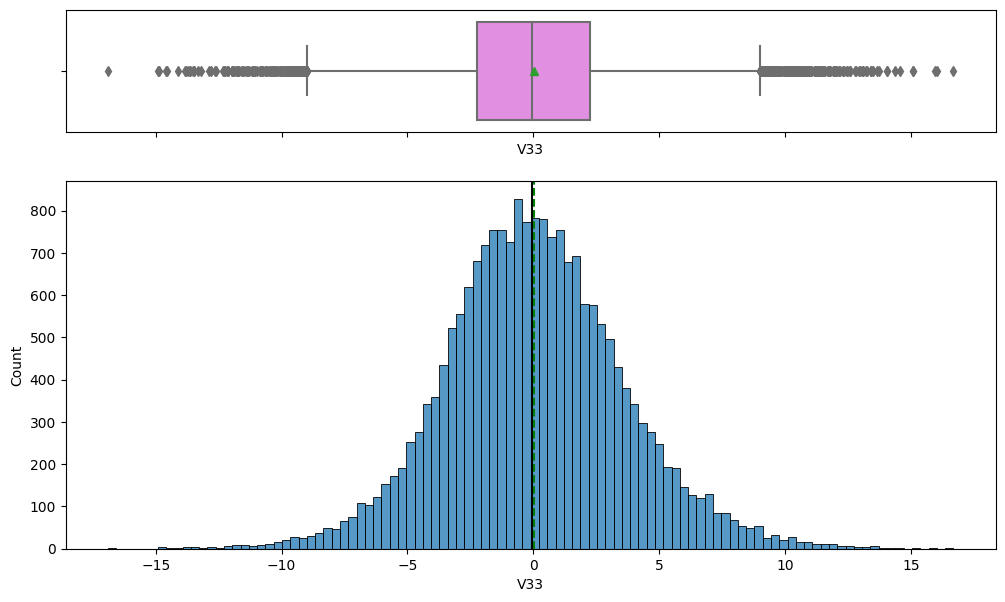

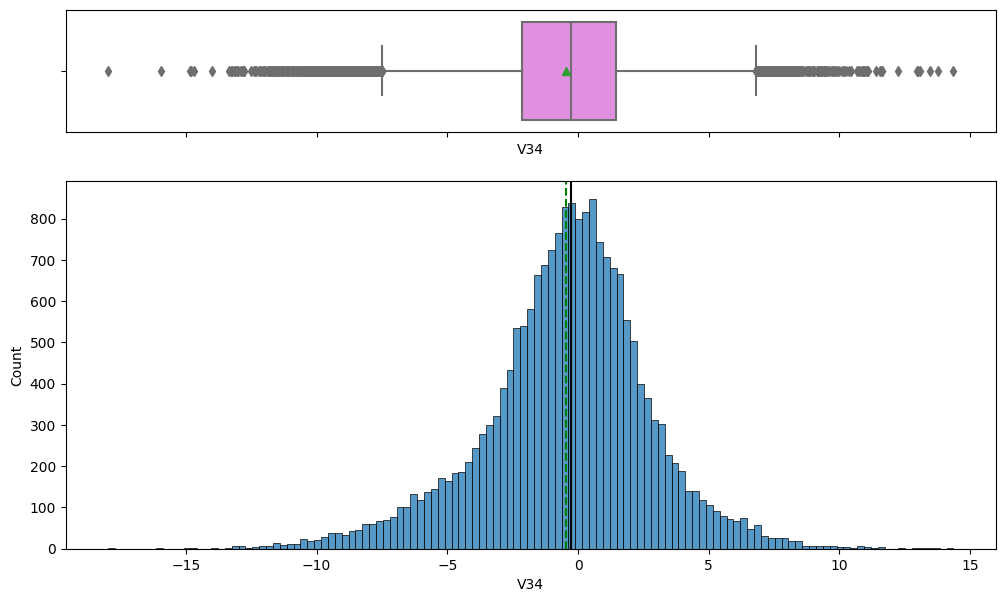

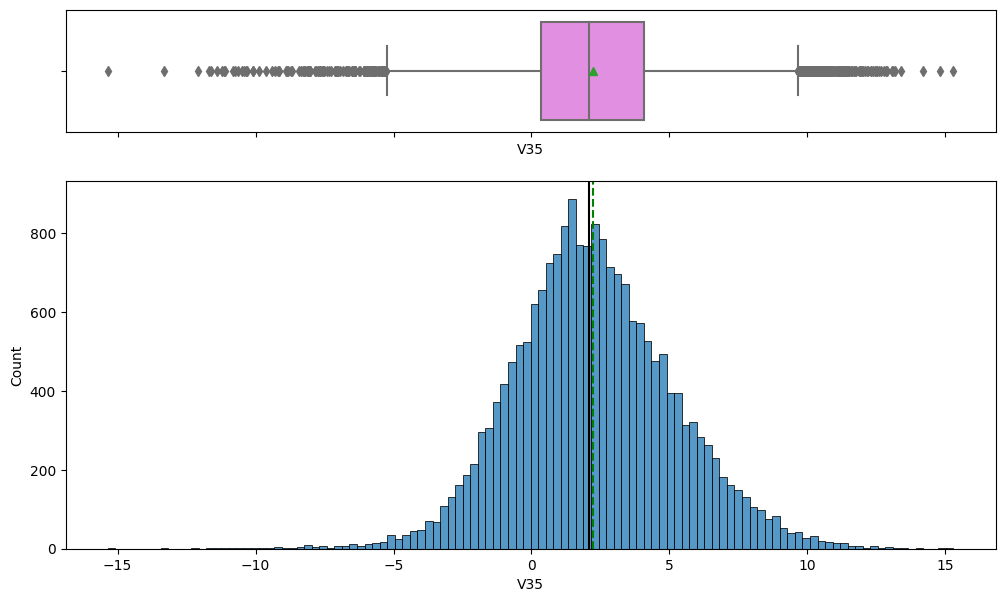

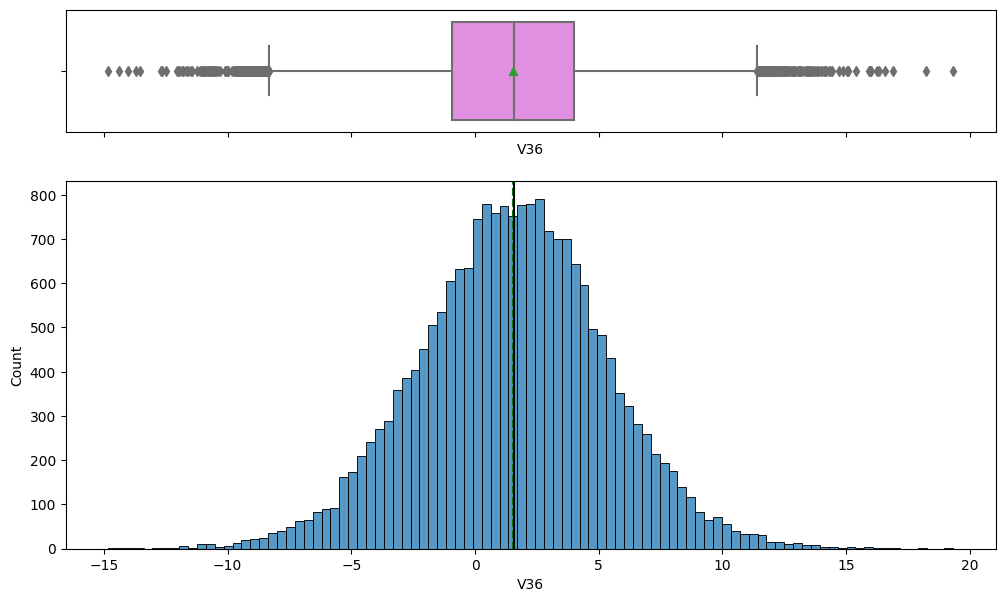

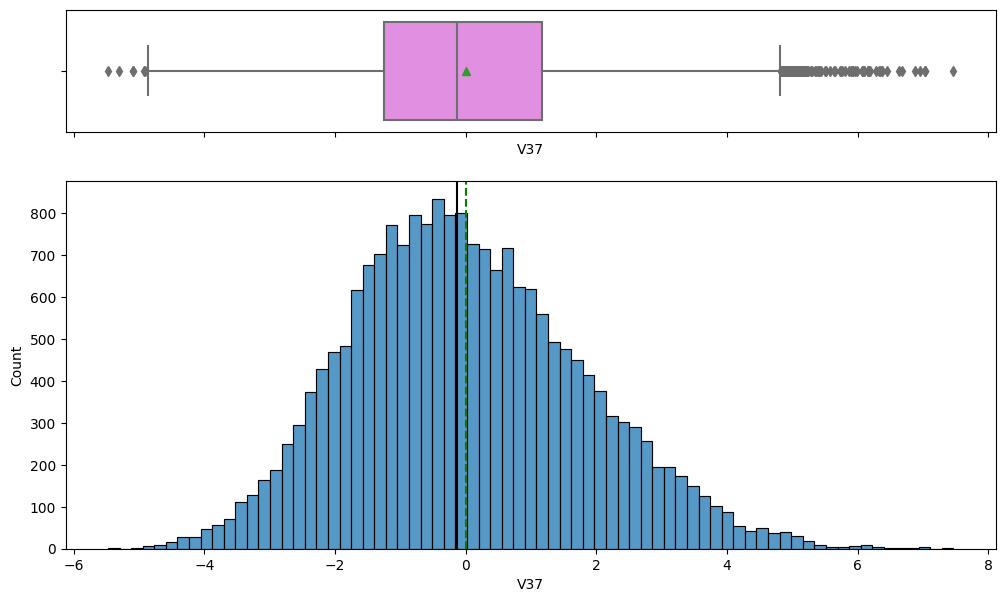

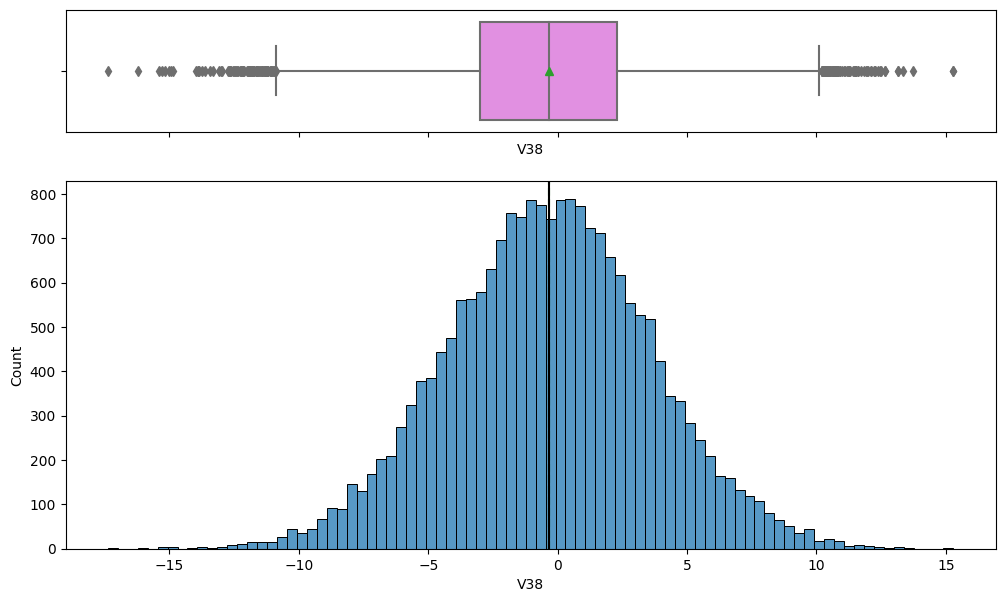

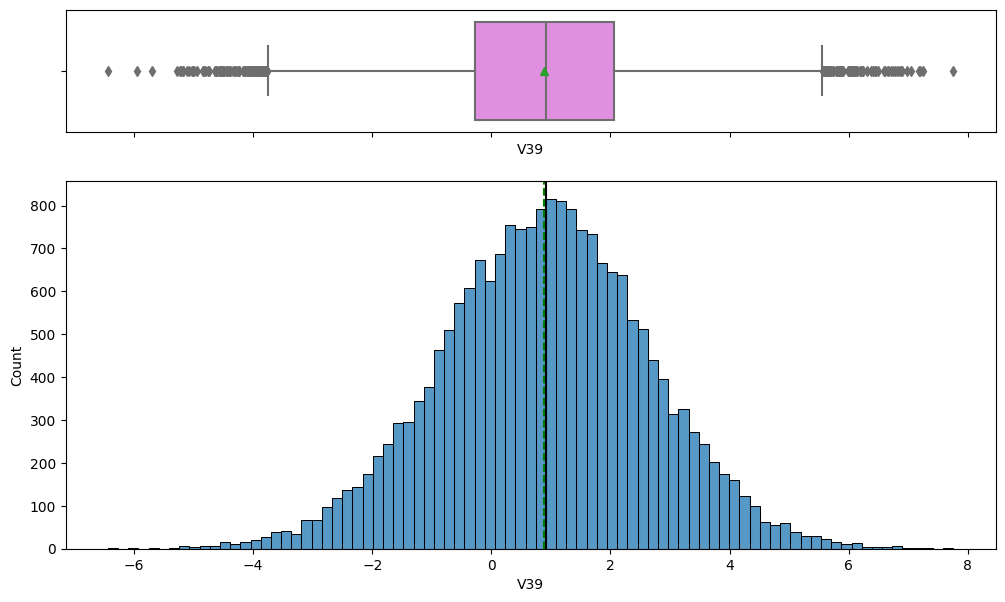

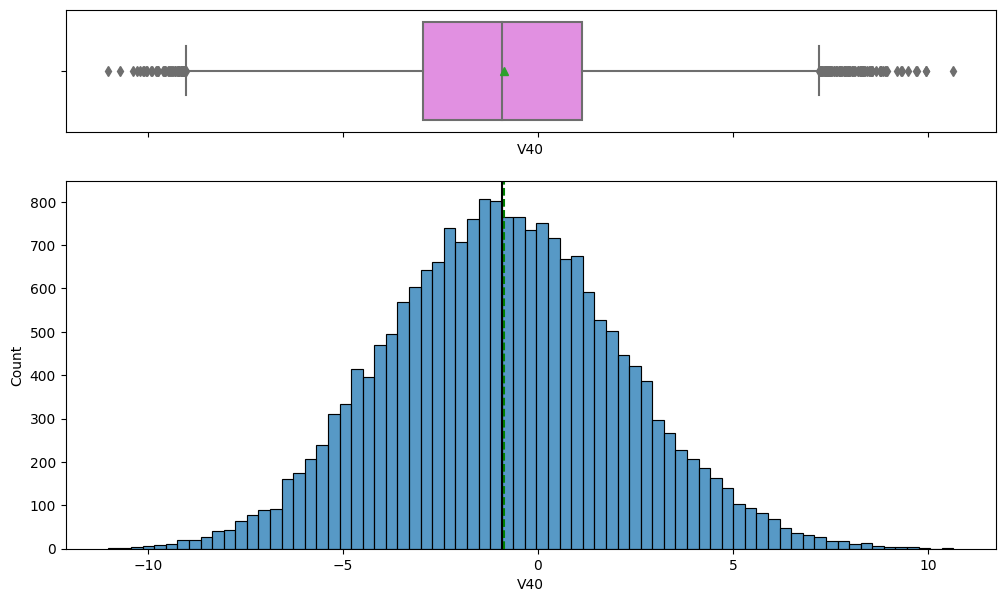

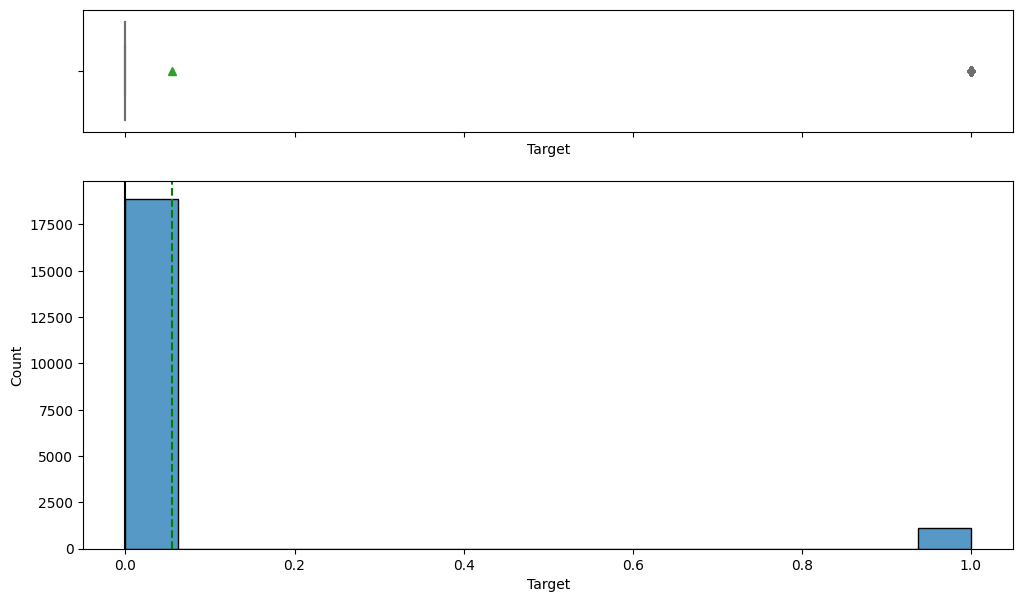

In [ ]:
for feature in TrainD.columns:
    histogram_boxplot(TrainD, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data

### Bivariate Analysis os Train Data

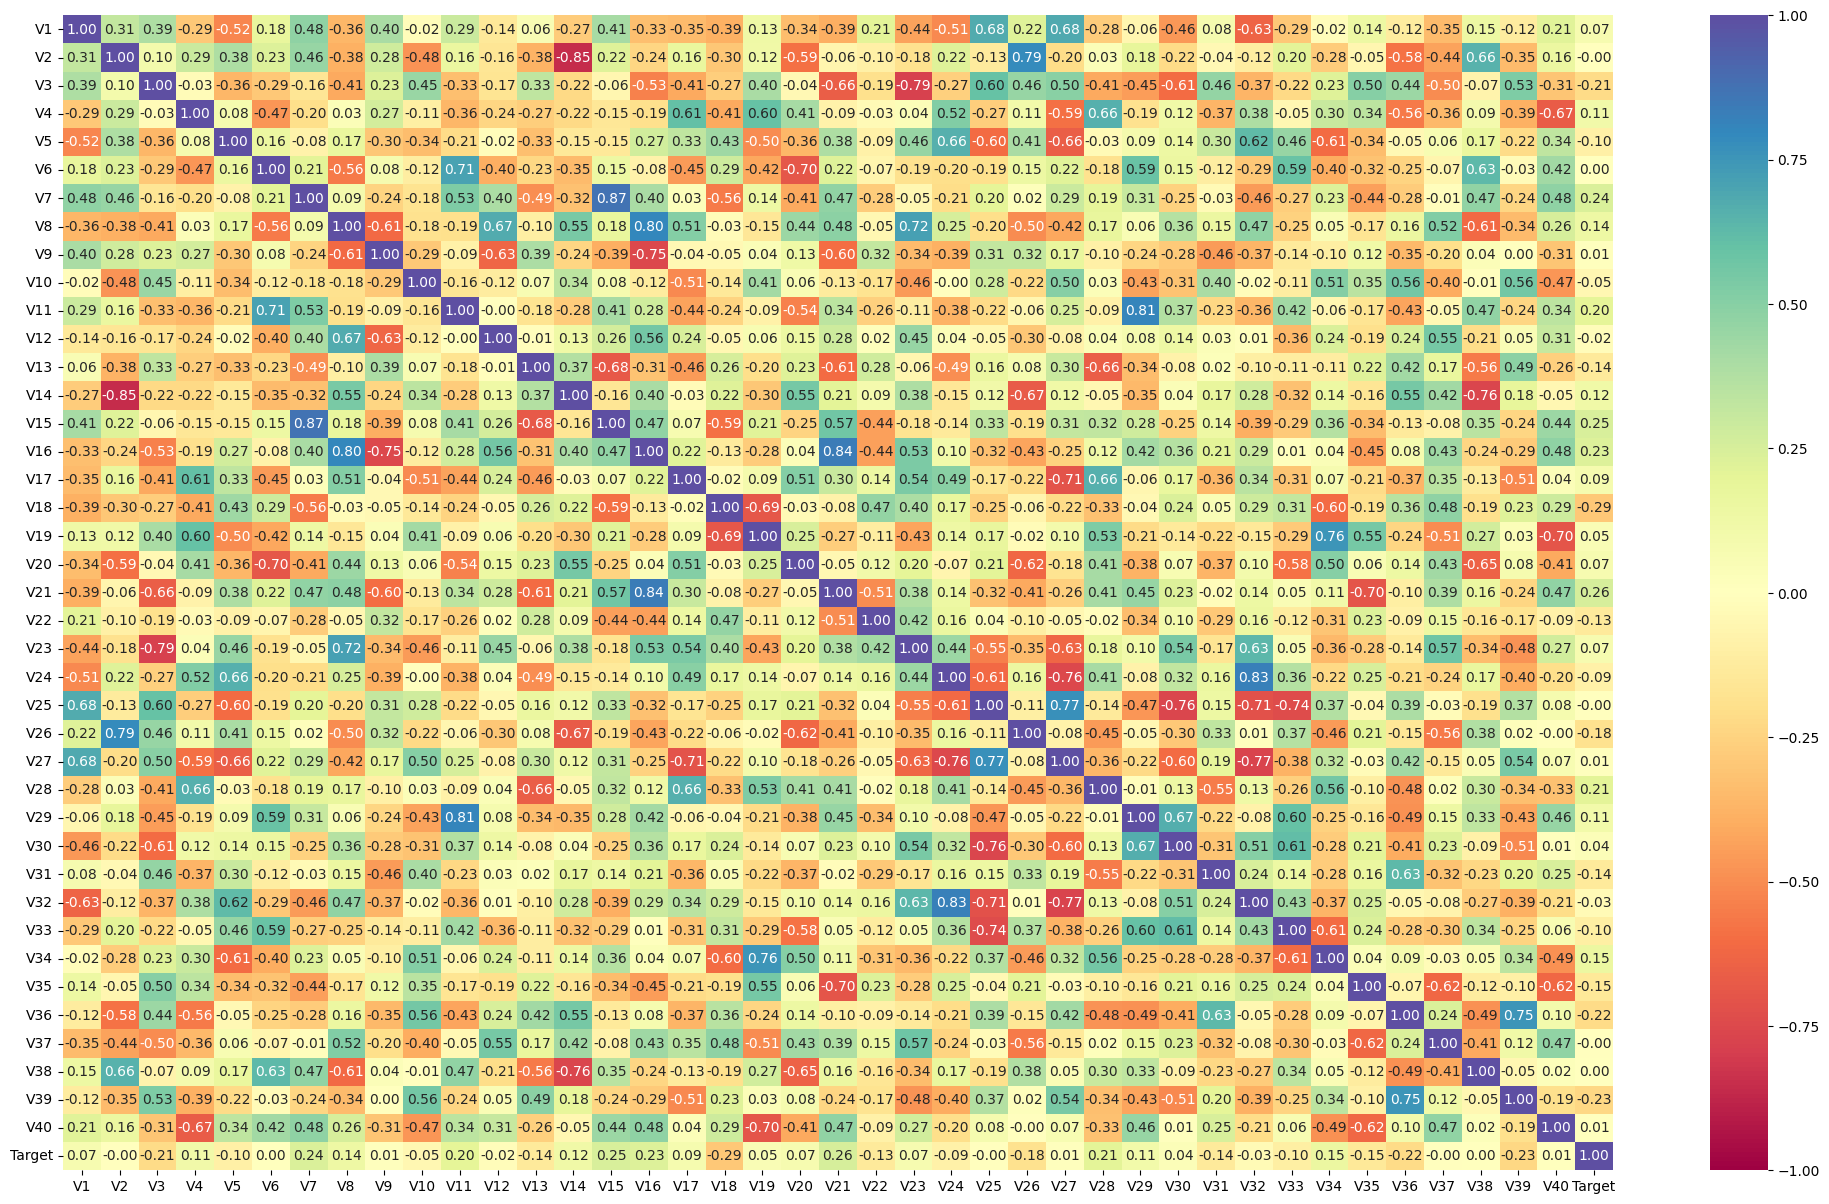

In [ ]:
plt.figure(figsize=(25, 15))
sns.heatmap(TrainD.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

## Data Pre-processing

  - The Test Data will be split into X_test and y_test
  
  - The Train Data will be processed for for modeling, will be split into training and validation
  
  - Since all features have numerical data types, no need for creating dummies

#### Separating target variable and other variables in the Test Data

In [ ]:

X_test = TestD.drop(columns='Target')


y_test = TestD['Target']


print(X_test.shape, y_test.shape)

(5000, 40) (5000,)


#### Separating target variable and other variables in the Train Data and Splitting into Training and validation

In [ ]:

X= TrainD.drop(columns='Target')

y= TrainD['Target']

In [ ]:
# Splitting data into training and validation set:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)

print(X_train.shape, X_val.shape)

(14000, 40) (6000, 40)


## Missing value imputation




In [ ]:
imputer = SimpleImputer(strategy="median")

In [ ]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [ ]:
# Checking that no column has missing values in train, val or test sets
print(X_train.isnull().values.any())
print("-" * 10)
print(X_val.isnull().values.any())
print("-" * 10)
print(X_test.isnull().values.any())

False
----------
False
----------
False


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [ ]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Sample Decision Tree model building with original data

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.7078246484698097
Bagging: 0.707808105872622
Random forest: 0.7194127377998345
GBM: 0.7220016542597187
Adaboost: 0.6434656741108354
Xgboost: 0.7979487179487179

Validation Performance:

dtree: 0.7057057057057057
Bagging: 0.7267267267267268
Random forest: 0.7357357357357357
GBM: 0.7357357357357357
Adaboost: 0.6516516516516516
Xgboost: 0.8198198198198198


#### Observation

  - The decision tree model is given the minimum variance of 0.0021 between the training and validation sets

### Model Building with Oversampled data


In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 777
Before OverSampling, counts of label '0': 13223 

After OverSampling, counts of label '1': 13223
After OverSampling, counts of label '0': 13223 

After OverSampling, the shape of train_X: (26446, 40)
After OverSampling, the shape of train_y: (26446,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree_over", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging_over", BaggingClassifier(random_state=1)))
models.append(("Random forest_over", RandomForestClassifier(random_state=1)))
models.append(("GBM_over", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost_over", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost_over", XGBClassifier(random_state=1, eval_metric="logloss")))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree_over: 0.970128321355339
Bagging_over: 0.975119441528989
Random forest_over: 0.9829090368319754
GBM_over: 0.9329201902370526
Adaboost_over: 0.904787470436327
Xgboost_over: 0.9895639018614746

Validation Performance:

dtree_over: 0.7837837837837838
Bagging_over: 0.8258258258258259
Random forest_over: 0.8558558558558559
GBM_over: 0.8768768768768769
Adaboost_over: 0.8618618618618619
Xgboost_over: 0.8558558558558559


#### Observation

  - The Adaboost model is given the minimum variance of 0.04 between the training and validation sets

### Model Building with Undersampled data

In [ ]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 777
Before UnderSampling, counts of label '0': 13223 

After UnderSampling, counts of label '1': 777
After UnderSampling, counts of label '0': 777 

After UnderSampling, the shape of train_X: (1554, 40)
After UnderSampling, the shape of train_y: (1554,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree_un", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging_un", BaggingClassifier(random_state=1)))
models.append(("Random forest_un", RandomForestClassifier(random_state=1)))
models.append(("GBM_un", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost_un", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost_un", XGBClassifier(random_state=1, eval_metric="logloss")))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree_un: 0.8622167080231596
Bagging_un: 0.880339123242349
Random forest_un: 0.9034822167080232
GBM_un: 0.8932009925558313
Adaboost_un: 0.8725971877584782
Xgboost_un: 0.897055417700579

Validation Performance:

dtree_un: 0.8408408408408409
Bagging_un: 0.8708708708708709
Random forest_un: 0.8828828828828829
GBM_un: 0.8828828828828829
Adaboost_un: 0.8588588588588588
Xgboost_un: 0.8918918918918919


#### Observation

  - The Xgboost model is given the minimum variance of 0.0052 between the training and validation sets

## HyperparameterTuning

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Sample tuning method for Decision tree with original data

In [ ]:
# defining model
dTree_tuned = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=dTree_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.550752688172043:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
dTree_tuned = DecisionTreeClassifier(
    min_samples_leaf=7,
    max_leaf_nodes=15,
    max_depth=5,
    random_state=1,
    min_impurity_decrease=0.0001,
)

# Fit the best algorithm to the data.
dTree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001, min_samples_leaf=7,
                       random_state=1)

#### Checking model performance on training set

In [ ]:
dTree_tuned_train=model_performance_classification_sklearn(dTree_tuned, X_train, y_train)
dTree_tuned_train

Accuracy  Recall  Precision    F1
0     0.976   0.631      0.911 0.745

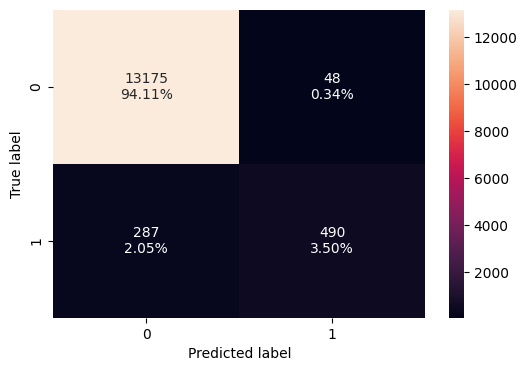

In [ ]:
confusion_matrix_sklearn(dTree_tuned, X_train, y_train)

#### Checking model performance on validation set

In [ ]:
dTree_tuned_val=model_performance_classification_sklearn(dTree_tuned, X_val, y_val)
dTree_tuned_val

Accuracy  Recall  Precision    F1
0     0.972   0.631      0.814 0.711

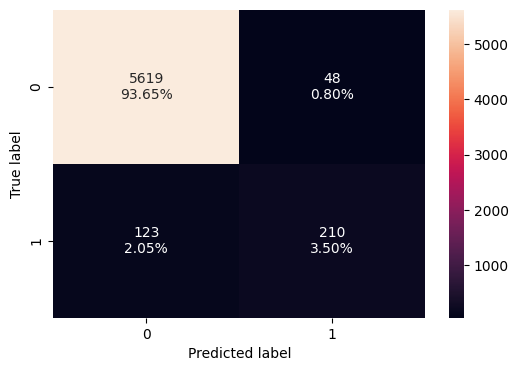

In [ ]:
confusion_matrix_sklearn(dTree_tuned, X_val, y_val)

#### Insight

 - The decision tree model tuned with the best parameters is doing perfect on the recall score, recording 0.631 training set and 0.631 validation sets  
 _ Recording  a variance F1 score of 0.034 between traning and validation sets

### Sample tuning method for Decision tree with oversampled data

In [ ]:
# defining model
dTree_tuned_over = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,6),
              'min_samples_leaf': [1, 4, 7],
              'max_leaf_nodes' : [10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=dTree_tuned_over, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 7, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 3} with CV score=0.9240715362242579:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
dTree_tuned_over = DecisionTreeClassifier(
    min_samples_leaf=7,
    max_leaf_nodes=15,
    max_depth=3,
    random_state=1,
    min_impurity_decrease=0.001,
)

# Fit the best algorithm to the data.
dTree_tuned_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15,
                       min_impurity_decrease=0.001, min_samples_leaf=7,
                       random_state=1)

#### Checking model performance on training set

In [ ]:
dTree_tuned_over_train=model_performance_classification_sklearn(dTree_tuned_over, X_train_over, y_train_over)
dTree_tuned_over_train

Accuracy  Recall  Precision    F1
0     0.843   0.925      0.794 0.855

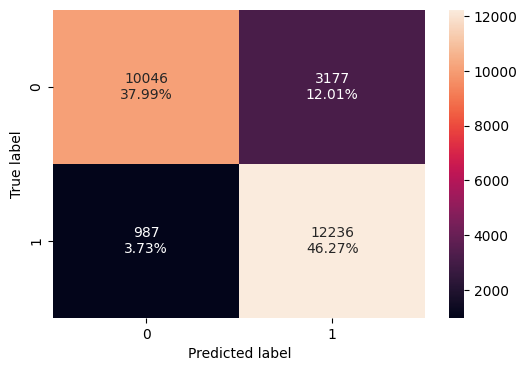

In [ ]:
confusion_matrix_sklearn(dTree_tuned_over, X_train_over, y_train_over)

#### Checking model performance on validation set

In [ ]:
dTree_tuned_over_val=model_performance_classification_sklearn(dTree_tuned_over, X_val, y_val)
dTree_tuned_over_val

Accuracy  Recall  Precision    F1
0     0.754   0.877      0.169 0.284

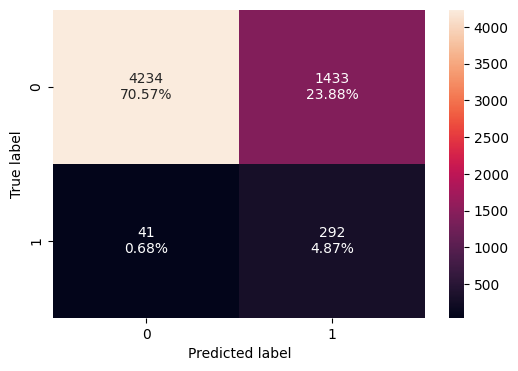

In [ ]:
confusion_matrix_sklearn(dTree_tuned_over, X_val, y_val)

#### Insight

 - The over sampled decision tree model tuned with the best parameters is overfitting the F1 and precision scores, but doing well on recall score, recording recall score variance of 0.048 between training and validation

### Sample tuning method for Decision tree with undersampled data

In [ ]:
# defining model
dTree_tuned_un = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {'max_depth': np.arange(2,20),
              'min_samples_leaf': [1, 2, 5, 7],
              'max_leaf_nodes' : [5, 10,15],
              'min_impurity_decrease': [0.0001,0.001] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=dTree_tuned_un, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 11} with CV score=0.83520264681555:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
dTree_tuned_un = DecisionTreeClassifier(
    min_samples_leaf= 1, min_impurity_decrease= 0.001, max_leaf_nodes= 15, max_depth= 11
)

# Fit the best algorithm to the data.
dTree_tuned_un.fit(X_train_un,y_train_un)

DecisionTreeClassifier(max_depth=11, max_leaf_nodes=15,
                       min_impurity_decrease=0.001)

#### Checking model performance on training set

In [ ]:
dTree_tuned_un_train=model_performance_classification_sklearn(dTree_tuned_un, X_train_un, y_train_un)
dTree_tuned_un_train

Accuracy  Recall  Precision    F1
0     0.912   0.880      0.940 0.909

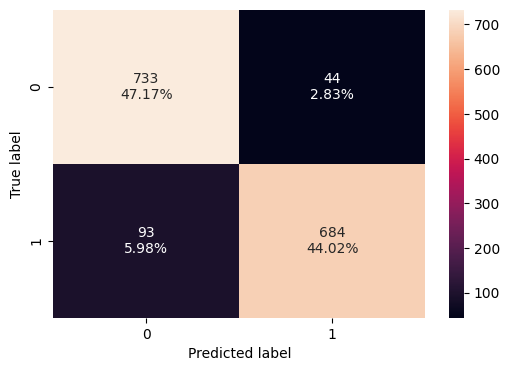

In [ ]:
confusion_matrix_sklearn(dTree_tuned_un, X_train_un, y_train_un)

#### Checking model performance on validation set

In [ ]:
dTree_tuned_un_val=model_performance_classification_sklearn(dTree_tuned_un, X_val, y_val)
dTree_tuned_un_val

Accuracy  Recall  Precision    F1
0     0.909   0.844      0.363 0.507

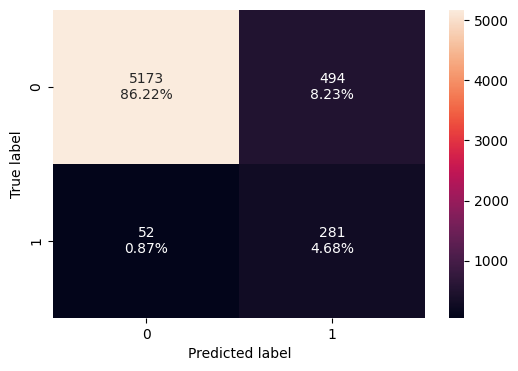

In [ ]:
confusion_matrix_sklearn(dTree_tuned_un, X_val, y_val)

#### Insight

 - The under sampled decision tree model tuned with the best parameters is overfitting the F1 and precision scores, but doing well on recall score, recording recall score variance of 0.036 between training and validation

### Tuning method for Random Forest with original data

In [ ]:
# defining model
RF_tuned = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=RF_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6950620347394542:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
RF_tuned = RandomForestClassifier(random_state=1, n_estimators= 250,min_samples_leaf=1, max_samples= 0.6, max_features= 'sqrt')

# Fit the best algorithm to the data.
RF_tuned.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

#### Checking model performance on training set

In [ ]:
RF_tuned_train=model_performance_classification_sklearn(RF_tuned, X_train, y_train)
RF_tuned_train

Accuracy  Recall  Precision    F1
0     0.995   0.910      1.000 0.953

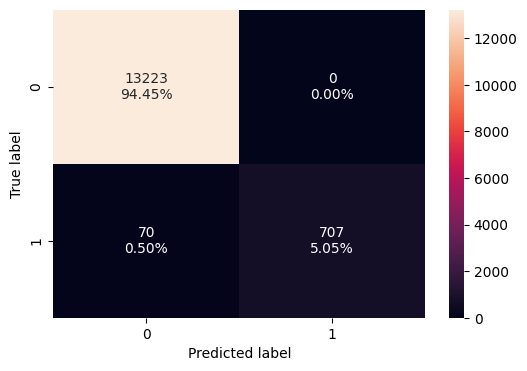

In [ ]:
confusion_matrix_sklearn(RF_tuned, X_train, y_train)

#### Checking model performance on validation set

In [ ]:
RF_tuned_val=model_performance_classification_sklearn(RF_tuned, X_val, y_val)
RF_tuned_val

Accuracy  Recall  Precision    F1
0     0.984   0.721      0.988 0.833

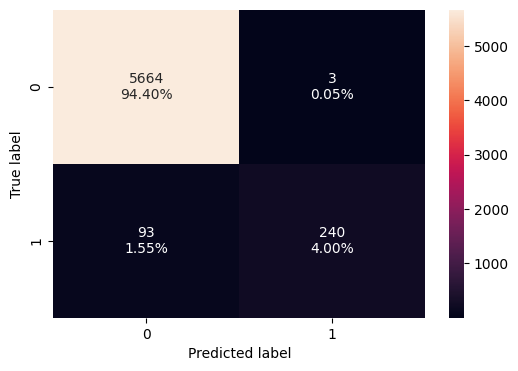

In [ ]:
confusion_matrix_sklearn(RF_tuned, X_val, y_val)

#### Insight

 - The random forest model tuned with the best parameters is overfitting

### Tuning method for Random Forest with oversampled data

In [ ]:
# defining model
RF_over_tuned = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=RF_over_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9815469200872826:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
RF_over_tuned = RandomForestClassifier(random_state=1, n_estimators= 250, min_samples_leaf=1, max_samples= 0.6, max_features= 'sqrt')

# Fit the best algorithm to the data.
RF_over_tuned.fit(X_train_over,y_train_over)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

#### Checking model performance on training set

In [ ]:
RF_over_tuned_train=model_performance_classification_sklearn(RF_over_tuned, X_train_over, y_train_over)
RF_over_tuned_train

Accuracy  Recall  Precision    F1
0     1.000   0.999      1.000 1.000

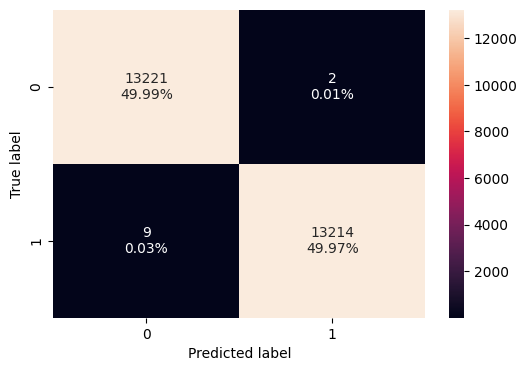

In [ ]:
confusion_matrix_sklearn(RF_over_tuned, X_train_over, y_train_over)

#### Checking model performance on validation set

In [ ]:
RF_over_tuned_val=model_performance_classification_sklearn(RF_over_tuned, X_val, y_val)
RF_over_tuned_val

Accuracy  Recall  Precision    F1
0     0.987   0.865      0.897 0.881

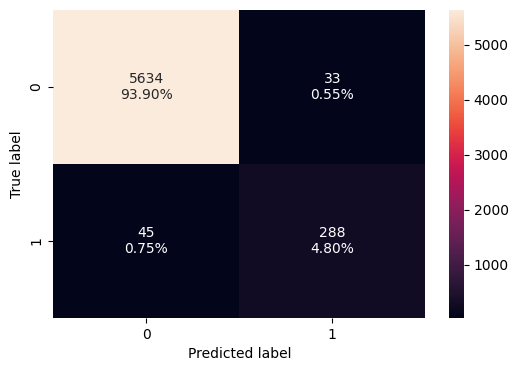

In [ ]:
confusion_matrix_sklearn(RF_over_tuned, X_val, y_val)

#### Insight

 - The oversampled random forest model tuned with the best parameters is overfitting

### Tuning method for Random Forest with undersampled data

In [ ]:
# defining model
RF_un_tuned = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=RF_un_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9047477253928868:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
RF_un_tuned = RandomForestClassifier(random_state=1, n_estimators= 300,min_samples_leaf=1, max_samples= 0.6, max_features= 'sqrt')

# Fit the best algorithm to the data.
RF_un_tuned.fit(X_train_un,y_train_un)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

#### Checking model performance on training set

In [ ]:
RF_un_tuned_train=model_performance_classification_sklearn(RF_un_tuned, X_train_un, y_train_un)
RF_un_tuned_train

Accuracy  Recall  Precision    F1
0     0.988   0.978      0.999 0.988

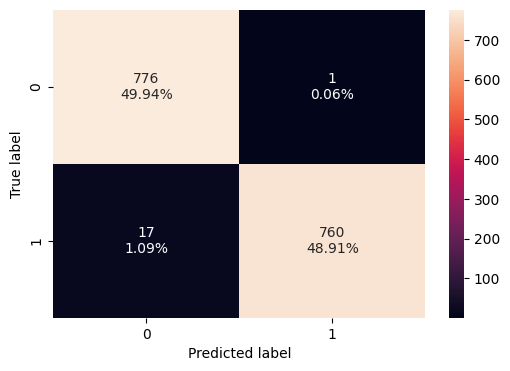

In [ ]:
confusion_matrix_sklearn(RF_un_tuned, X_train_un, y_train_un)

#### Checking model performance on validation set

In [ ]:
RF_un_tuned_val=model_performance_classification_sklearn(RF_un_tuned, X_val, y_val)
RF_un_tuned_val

Accuracy  Recall  Precision    F1
0     0.934   0.880      0.451 0.597

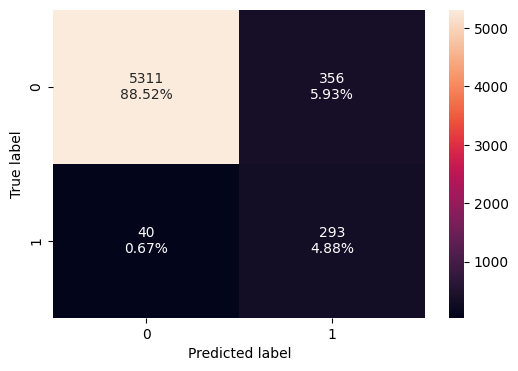

In [ ]:
confusion_matrix_sklearn(RF_un_tuned, X_val, y_val)

#### Insight

 - The under sampled random forest model tuned with the best parameters is overfitting

### Tuning method for Bagging Classifier with original data

In [ ]:
# defining model
bag_tuned= BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1], 'max_features': [0.7,0.8,0.9], 'n_estimators' : [30,50,70] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=bag_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 50, 'max_samples': 0.8, 'max_features': 0.8} with CV score=0.7220099255583127:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
bag_tuned= BaggingClassifier(random_state=1, n_estimators=50, max_samples= 0.8, max_features= 0.8)

# Fit the best algorithm to the data.
bag_tuned.fit(X_train,y_train)

BaggingClassifier(max_features=0.8, max_samples=0.8, n_estimators=50,
                  random_state=1)

#### Checking model performance on training set

In [ ]:
bag_tuned_train=model_performance_classification_sklearn(bag_tuned, X_train, y_train)
bag_tuned_train

Accuracy  Recall  Precision    F1
0     0.999   0.981      1.000 0.990

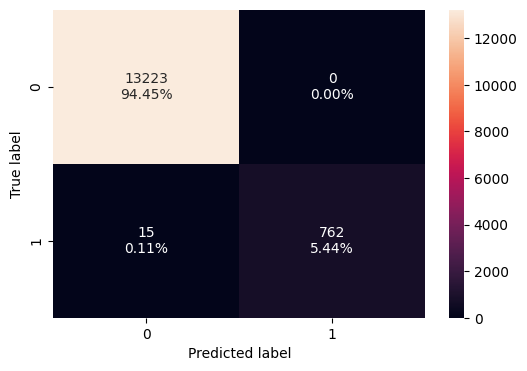

In [ ]:
confusion_matrix_sklearn(bag_tuned, X_train, y_train)

#### Checking model performance on validation set

In [ ]:
bag_tuned_val=model_performance_classification_sklearn(bag_tuned, X_val, y_val)
bag_tuned_val

Accuracy  Recall  Precision    F1
0     0.985   0.751      0.969 0.846

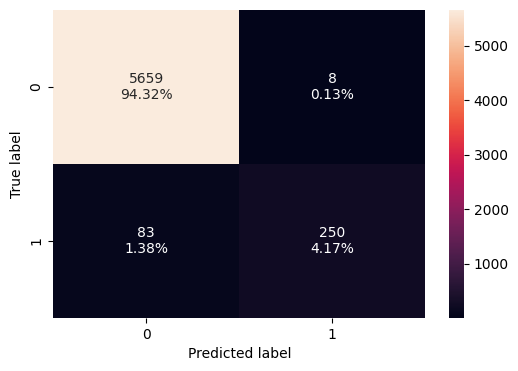

In [ ]:
confusion_matrix_sklearn(bag_tuned, X_val, y_val)

#### Insight

 - The Bagging Classifier model tuned with the best parameters is overfitting

### Tuning method for Bagging Classifier with oversampled data

In [ ]:
# defining model
bag_over_tuned= BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1], 'max_features': [0.7,0.8,0.9], 'n_estimators' : [30,50,70] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=bag_over_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.9834374222478974:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
bag_over_tuned= BaggingClassifier(random_state=1, n_estimators=70, max_samples=0.9, max_features=0.8)

# Fit the best algorithm to the data.
bag_over_tuned.fit(X_train_over,y_train_over)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=70,
                  random_state=1)

#### Checking model performance on training set

In [ ]:
bag_over_tuned_train=model_performance_classification_sklearn(bag_over_tuned, X_train_over,y_train_over)
bag_over_tuned_train

Accuracy  Recall  Precision    F1
0     1.000   1.000      1.000 1.000

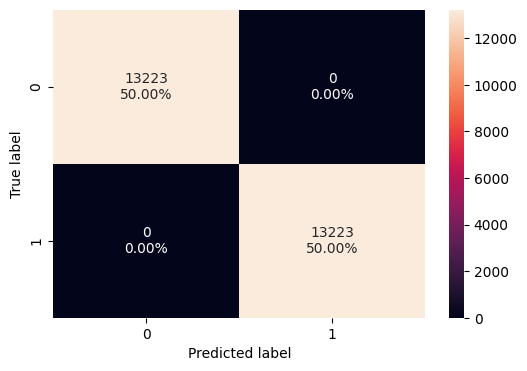

In [ ]:
confusion_matrix_sklearn(bag_over_tuned, X_train_over,y_train_over)

#### Checking model performance on validation set

In [ ]:
bag_over_tuned_val=model_performance_classification_sklearn(bag_over_tuned, X_val, y_val)
bag_over_tuned_val

Accuracy  Recall  Precision    F1
0     0.984   0.853      0.858 0.855

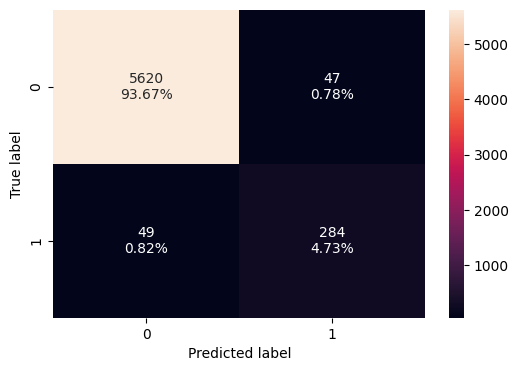

In [ ]:
confusion_matrix_sklearn(bag_over_tuned, X_val, y_val)

#### Insight

 - The over sampled Bagging Classifier model tuned with the best parameters is overfitting

### Tuning method for Bagging Classifier with undersampled data

In [ ]:
# defining model
bag_un_tuned= BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { 'max_samples': [0.8,0.9,1], 'max_features': [0.7,0.8,0.9], 'n_estimators' : [30,50,70] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=bag_un_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.8, 'max_features': 0.7} with CV score=0.9008684863523573:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
bag_un_tuned= BaggingClassifier(random_state=1, n_estimators=70, max_samples=0.8, max_features=0.7)

# Fit the best algorithm to the data.
bag_un_tuned.fit(X_train_un,y_train_un)

BaggingClassifier(max_features=0.7, max_samples=0.8, n_estimators=70,
                  random_state=1)

#### Checking model performance on training set

In [ ]:
bag_un_tuned_train=model_performance_classification_sklearn(bag_un_tuned, X_train_un,y_train_un)
bag_un_tuned_train

Accuracy  Recall  Precision    F1
0     0.999   0.997      1.000 0.999

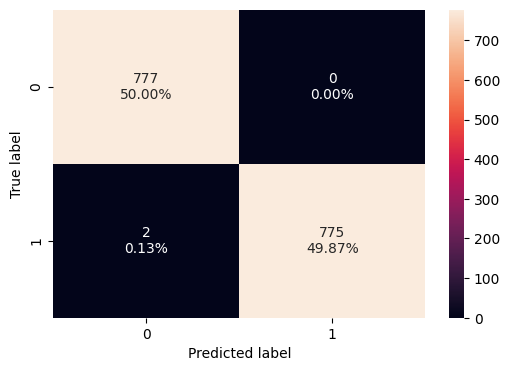

In [ ]:
confusion_matrix_sklearn(bag_un_tuned, X_train_un,y_train_un)

#### Checking model performance on validation set

In [ ]:
bag_un_tuned_val=model_performance_classification_sklearn(bag_un_tuned, X_val, y_val)
bag_un_tuned_val

Accuracy  Recall  Precision    F1
0     0.937   0.874      0.463 0.605

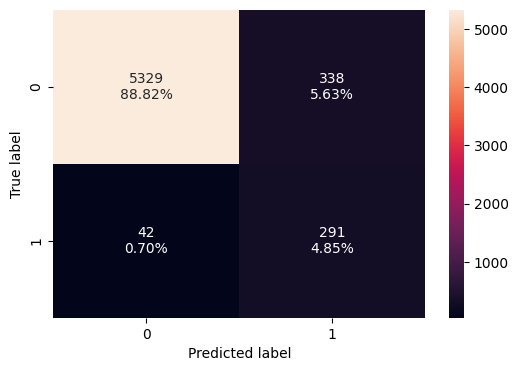

In [ ]:
confusion_matrix_sklearn(bag_un_tuned, X_val, y_val)

####Insight

   - The under sampled Bagging Classifier model tuned with the best parameters is overfitting

### Tuning method for Adaboost Classifier with original data

In [ ]:
# defining model
adb_tuned= AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05],
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                 DecisionTreeClassifier(max_depth=2, random_state=1),
                                 DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=adb_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.7696443341604631:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
adb_tuned= AdaBoostClassifier(random_state=1, n_estimators=200, learning_rate=0.2, base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1))


# Fit the best algorithm to the data.
adb_tuned.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

#### Checking model performance on training set

In [ ]:
adb_tuned_train=model_performance_classification_sklearn(adb_tuned, X_train,y_train)
adb_tuned_train

Accuracy  Recall  Precision    F1
0     1.000   0.991      1.000 0.995

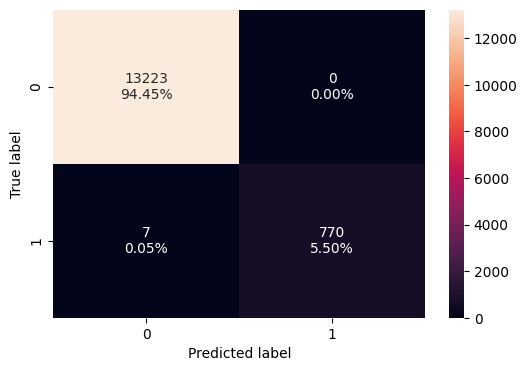

In [ ]:
confusion_matrix_sklearn(adb_tuned, X_train,y_train)

#### Checking model performance on validation set

In [ ]:
adb_tuned_val=model_performance_classification_sklearn(adb_tuned, X_val,y_val)
adb_tuned_val

Accuracy  Recall  Precision    F1
0     0.986   0.778      0.970 0.863

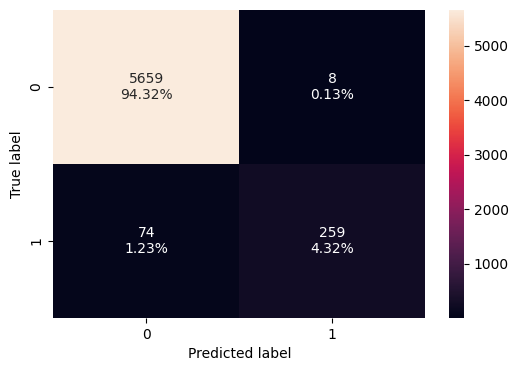

In [ ]:
confusion_matrix_sklearn(adb_tuned, X_val,y_val)

####Insight

   - The AdaBoost Classifier model tuned with the best parameters is overfitting

### Tuning method for AdaBoost Classifier with oversampled data

In [ ]:
# defining model
adb_over_tuned= AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05],
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                 DecisionTreeClassifier(max_depth=2, random_state=1),
                                 DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=adb_over_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9764048857633935:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
adb_over_tuned= AdaBoostClassifier(random_state=1, )


# Fit the best algorithm to the data.
adb_over_tuned.fit(X_train_over,y_train_over)

AdaBoostClassifier(random_state=1)

#### Checking model performance on training set

In [ ]:
adb_over_tuned_train=model_performance_classification_sklearn(adb_over_tuned, X_train_over,y_train_over)
adb_over_tuned_train

Accuracy  Recall  Precision    F1
0     0.914   0.904      0.923 0.913

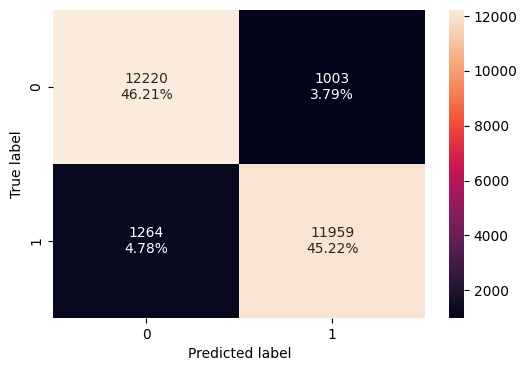

In [ ]:
confusion_matrix_sklearn(adb_over_tuned, X_train_over,y_train_over)

#### Checking model performance on validation set

In [ ]:
adb_over_tuned_val=model_performance_classification_sklearn(adb_over_tuned, X_val,y_val)
adb_over_tuned_val

Accuracy  Recall  Precision    F1
0     0.913   0.862      0.376 0.523

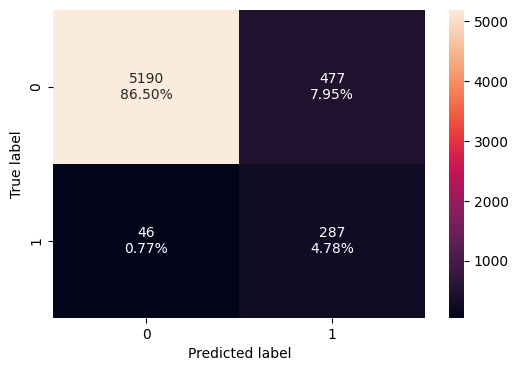

In [ ]:
confusion_matrix_sklearn(adb_over_tuned, X_val,y_val)

####Insight

   - The oversampled AdaBoost Classifier model tuned with the best parameters is overfitting on the F1 and precission scores but doing well on recall score

### Tuning method for AdaBoost Classifier with undersampled data

In [ ]:
# defining model
adb_un_tuned= AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [100, 150, 200], "learning_rate": [0.2, 0.05],
              "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1),
                                 DecisionTreeClassifier(max_depth=2, random_state=1),
                                 DecisionTreeClassifier(max_depth=3, random_state=1), ] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=adb_un_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 150, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9047559966914805:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
adb_un_tuned= AdaBoostClassifier(random_state=1, n_estimators= 150, learning_rate= 0.2, base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1))



# Fit the best algorithm to the data.
adb_un_tuned.fit(X_train_un,y_train_un)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=150, random_state=1)

#### Checking model performance on training set

In [ ]:
adb_un_tuned_train=model_performance_classification_sklearn(adb_un_tuned, X_train_over,y_train_over)
adb_un_tuned_train

Accuracy  Recall  Precision    F1
0     0.948   0.962      0.936 0.949

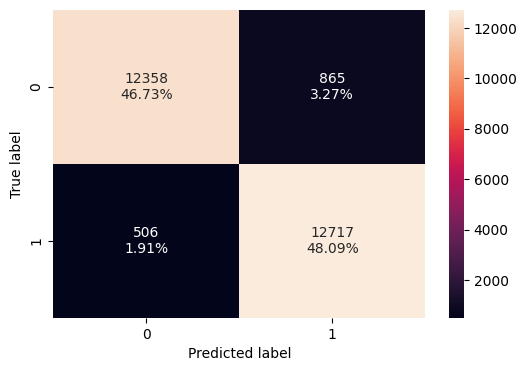

In [ ]:
confusion_matrix_sklearn(adb_un_tuned, X_train_over,y_train_over)

#### Checking model performance on validation set

In [ ]:
adb_un_tuned_val=model_performance_classification_sklearn(adb_un_tuned, X_val,y_val)
adb_un_tuned_val

Accuracy  Recall  Precision    F1
0     0.923   0.874      0.409 0.557

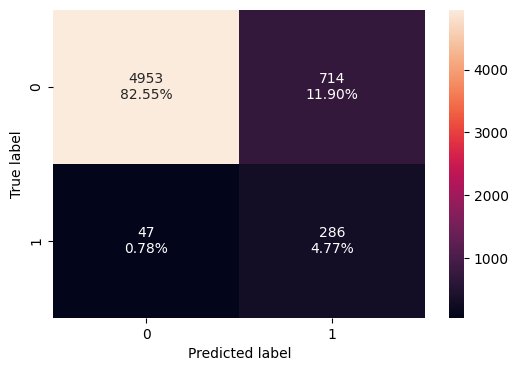

In [ ]:
confusion_matrix_sklearn(adb_un_tuned, X_val,y_val)

####Insight

   - The undersampled AdaBoost Classifier model tuned with the best parameters is overfitting on the F1 and precission scores but doing well on recall score

### Tuning method for Gredient Boosting Classifier with original data

In [ ]:
# defining model
GBC_tuned= GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=GBC_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7361703887510339:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
GBC_tuned= GradientBoostingClassifier(random_state=1, subsample= 0.5, n_estimators= 125, max_features= 0.5, learning_rate= 0.2)


# Fit the best algorithm to the data.
GBC_tuned.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.5)

#### Checking model performance on training set

In [ ]:
GBC_tuned_train=model_performance_classification_sklearn(GBC_tuned, X_train,y_train)
GBC_tuned_train

Accuracy  Recall  Precision    F1
0     0.992   0.867      0.980 0.920

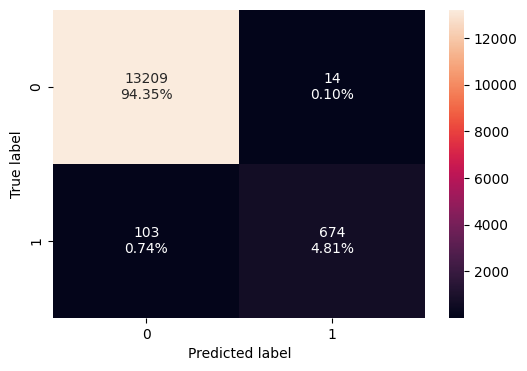

In [ ]:
confusion_matrix_sklearn(GBC_tuned, X_train,y_train)

#### Checking model performance on validation set

In [ ]:
GBC_tuned_val=model_performance_classification_sklearn(GBC_tuned, X_val,y_val)
GBC_tuned_val

Accuracy  Recall  Precision    F1
0     0.981   0.769      0.868 0.815

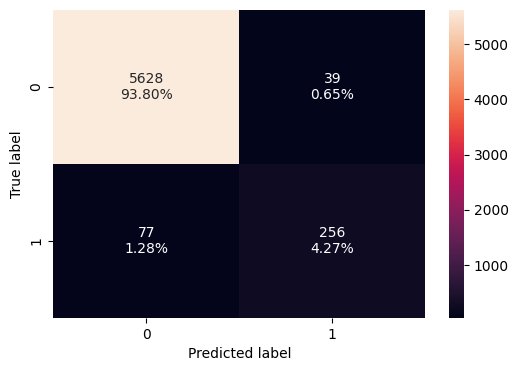

In [ ]:
confusion_matrix_sklearn(GBC_tuned, X_val,y_val)

####Insight

   - The Gredient Boosting Classifier model tuned with the best parameters is performing well on the recall score

### Tuning method for Gredient Boosting Classifier with oversampled data

In [ ]:
# defining model
GBC_over_tuned= GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {  "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=GBC_over_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9711863505200633:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
GBC_over_tuned= GradientBoostingClassifier(random_state=1, subsample=0.7, n_estimators= 125, max_features= 0.5, learning_rate= 1)


# Fit the best algorithm to the data.
GBC_over_tuned.fit(X_train_over,y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

#### Checking model performance on training set

In [ ]:
GBC_over_tuned_train=model_performance_classification_sklearn(GBC_over_tuned, X_train_over,y_train_over)
GBC_over_tuned_train

Accuracy  Recall  Precision    F1
0     0.988   0.988      0.989 0.988

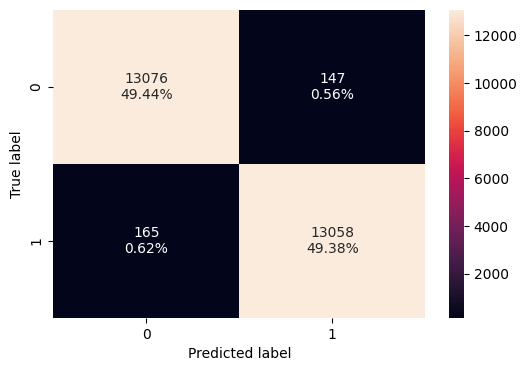

In [ ]:
confusion_matrix_sklearn(GBC_over_tuned, X_train_over,y_train_over)

#### Checking model performance on validation set

In [ ]:
GBC_over_tuned_val=model_performance_classification_sklearn(GBC_over_tuned, X_val,y_val)
GBC_over_tuned_val

Accuracy  Recall  Precision    F1
0     0.963   0.862      0.616 0.718

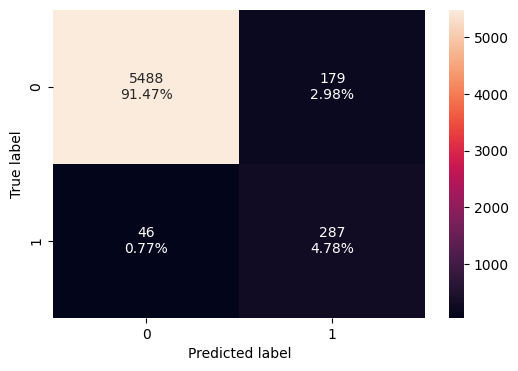

In [ ]:
confusion_matrix_sklearn(GBC_over_tuned, X_val,y_val)

####Insight

   - The oversampled Gredient Boosting Classifier model tuned with the best parameters is overfitting

### Tuning method for Gredient Boosting Classifier with undersampled data

In [ ]:
# defining model
GBC_un_tuned= GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {  "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]  }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=GBC_un_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.05} with CV score=0.9047394540942928:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
GBC_un_tuned= GradientBoostingClassifier(random_state=1, subsample=0.7, n_estimators=100, max_features=0.7, learning_rate=0.05)


# Fit the best algorithm to the data.
GBC_un_tuned.fit(X_train_un,y_train_un)

GradientBoostingClassifier(learning_rate=0.05, max_features=0.7, random_state=1,
                           subsample=0.7)

#### Checking model performance on training set

In [ ]:
GBC_un_tuned_train=model_performance_classification_sklearn(GBC_un_tuned, X_train_un,y_train_un)
GBC_un_tuned_train

Accuracy  Recall  Precision    F1
0     0.947   0.920      0.973 0.946

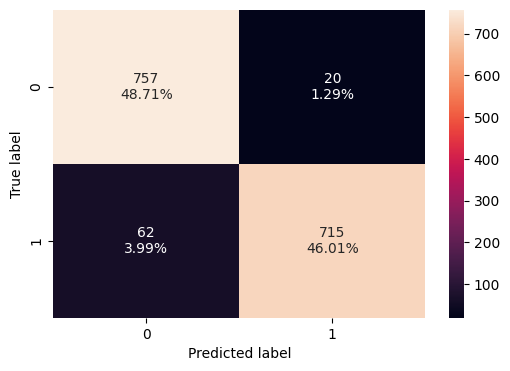

In [ ]:
confusion_matrix_sklearn(GBC_un_tuned, X_train_un,y_train_un)

#### Checking model performance on validation set

In [ ]:
GBC_un_tuned_val=model_performance_classification_sklearn(GBC_un_tuned, X_val,y_val)
GBC_un_tuned_val

Accuracy  Recall  Precision    F1
0     0.920   0.871      0.401 0.549

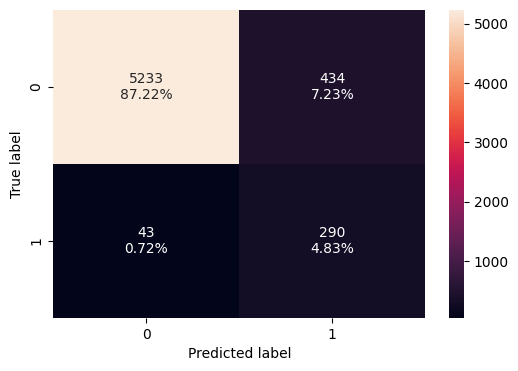

In [ ]:
confusion_matrix_sklearn(GBC_un_tuned, X_val,y_val)

####Insight

   - The undersampled Gradient Boosting Classifier model tuned with the best parameters is performing well on accuracy and recall scores, but overfitting on F1 and precision scores

### Tuning method for XGBoost Classifier with original data

In [ ]:
# defining model
XGB_tuned= XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid = {  'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=XGB_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.8559139784946236:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
XGB_tuned= XGBClassifier(random_state=1, eval_metric="logloss", subsample=0.9, scale_pos_weight=10, n_estimators=200, learning_rate=0.1, gamma=5)


# Fit the best algorithm to the data.
XGB_tuned.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

#### Checking model performance on training set

In [ ]:
XGB_tuned_train=model_performance_classification_sklearn(XGB_tuned, X_train,y_train)
XGB_tuned_train

Accuracy  Recall  Precision    F1
0     0.999   1.000      0.984 0.992

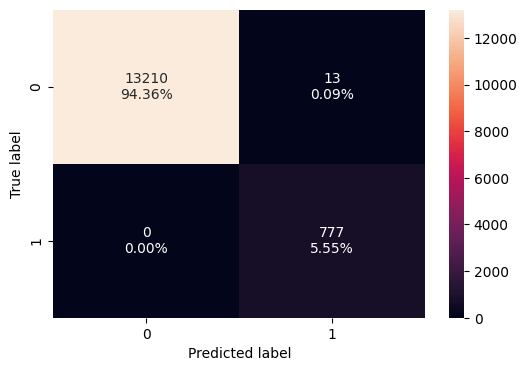

In [ ]:
confusion_matrix_sklearn(XGB_tuned, X_train,y_train)

#### Checking model performance on validation set

In [ ]:
XGB_tuned_val=model_performance_classification_sklearn(XGB_tuned, X_val,y_val)
XGB_tuned_val

Accuracy  Recall  Precision    F1
0     0.989   0.853      0.937 0.893

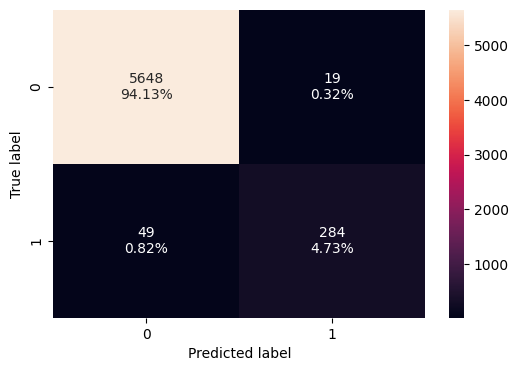

In [ ]:
confusion_matrix_sklearn(XGB_tuned, X_val,y_val)

####Insight

   - The XGBoost Classifier model tuned with the best parameters is overfitting the recall score

### Tuning method for XGBoost Classifier with oversampled data

In [ ]:
# defining model
XGB_over_tuned= XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid = {  'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=XGB_over_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9962183665123302:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
XGB_over_tuned= XGBClassifier(random_state=1, eval_metric="logloss", subsample= 0.8, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.1, gamma= 5)


# Fit the best algorithm to the data.
XGB_over_tuned.fit(X_train_over,y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

#### Checking model performance on training set

In [ ]:
XGB_over_tuned_train=model_performance_classification_sklearn(XGB_over_tuned, X_train_over,y_train_over)
XGB_over_tuned_train

Accuracy  Recall  Precision    F1
0     0.997   1.000      0.994 0.997

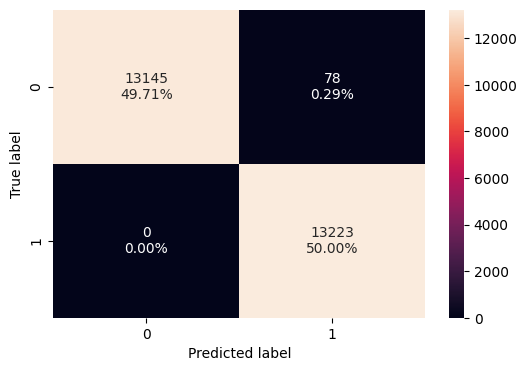

In [ ]:
confusion_matrix_sklearn(XGB_over_tuned, X_train_over,y_train_over)

#### Checking model performance on validation set

In [ ]:
XGB_over_tuned_val=model_performance_classification_sklearn(XGB_over_tuned, X_val,y_val)
XGB_over_tuned_val

Accuracy  Recall  Precision    F1
0     0.973   0.880      0.709 0.786

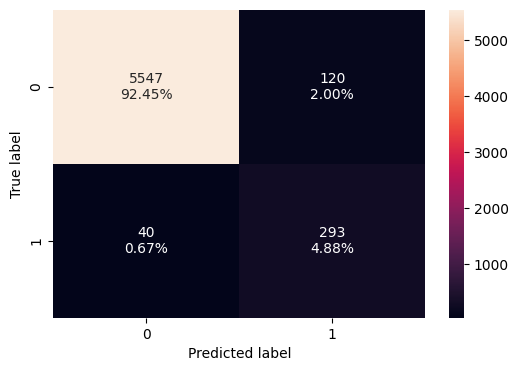

In [ ]:
confusion_matrix_sklearn(XGB_over_tuned, X_val,y_val)

####Insight

   - The oversampled XGBoost Classifier model tuned with the best parameters is overfitting

### Tuning method for XGBoost Classifier with undersampled data

In [ ]:
# defining model
XGB_un_tuned= XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid = {  'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=XGB_un_tuned, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9253349875930521:


#### Fitting with the best parameters

In [ ]:
# Set the clf to the best combination of parameters
XGB_un_tuned= XGBClassifier(random_state=1, eval_metric="logloss", subsample= 0.8, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.1, gamma= 5)


# Fit the best algorithm to the data.
XGB_un_tuned.fit(X_train_un,y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

#### Checking model performance on training set

In [ ]:
XGB_un_tuned_train=model_performance_classification_sklearn(XGB_un_tuned, X_train_un,y_train_un)
XGB_un_tuned_train

Accuracy  Recall  Precision    F1
0     0.992   1.000      0.985 0.992

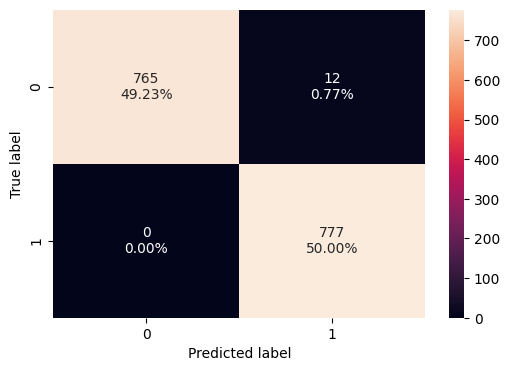

In [ ]:
confusion_matrix_sklearn(XGB_un_tuned, X_train_un,y_train_un)

#### Checking model performance on validation set

In [ ]:
XGB_un_tuned_val=model_performance_classification_sklearn(XGB_un_tuned, X_val,y_val)
XGB_un_tuned_val

Accuracy  Recall  Precision    F1
0     0.867   0.904      0.281 0.429

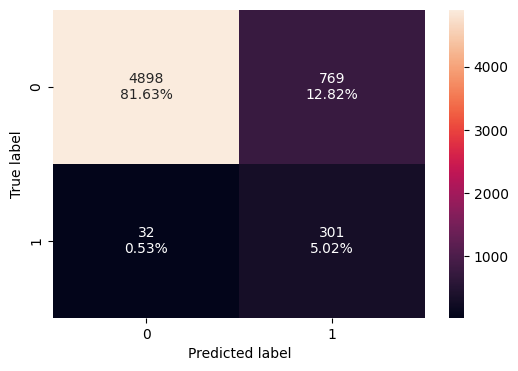

In [ ]:
confusion_matrix_sklearn(XGB_un_tuned, X_val,y_val)

####Insight

   - The undersampled XGBoost Classifier model tuned with the best parameters is overfitting

## Model performance comparison and choosing the final model

In [ ]:
# training and testing performance comparison

models_train_val_comp_df = pd.concat(
    [
        XGB_un_tuned_train.T,
        XGB_un_tuned_val.T,
        XGB_over_tuned_train.T,
        XGB_over_tuned_val.T,
        XGB_tuned_train.T,
        XGB_tuned_val.T,
        GBC_un_tuned_train.T,
        GBC_un_tuned_val.T,
        GBC_over_tuned_train.T,
        GBC_over_tuned_val.T,
        GBC_tuned_train.T,
        GBC_tuned_val.T,

    ],
    axis=1,
)
models_train_val_comp_df.columns = [
    "undersampled XGBoost Classifier train",
    "undersampled XGBoost Classifier val",
    "Oversampled XGBoost Classifier train",
    "Oversampled XGBoost Classifier val",
    "Original Data XGBoost Classifier train",
    "Original Data XGBoost Classifier val",
    "undersampled Gradient Boosting Classifier train",
    "undersampled Gradient Boosting Classifier val",
    "Oversampled Gradient Boosting Classifier train",
    "Oversampled Gradient Boosting Classifier val",
    "Original Data Gradient Boosting Classifier train",
    "Original Data Gradient Boosting Classifier val",

]

models_train_val_comp_df1 = pd.concat(
    [
        adb_un_tuned_train.T,
        adb_un_tuned_val.T,
        adb_over_tuned_train.T,
        adb_over_tuned_val.T,
        adb_tuned_train.T,
        adb_tuned_val.T,
        bag_un_tuned_train.T,
        bag_un_tuned_val.T,
        bag_over_tuned_train.T,
        bag_over_tuned_val.T,
        bag_tuned_train.T,
        bag_tuned_val.T,

    ],
    axis=1,
)
models_train_val_comp_df1.columns = [
    "undersampled Adaboost Classifier train",
    "undersampled Adaboost Classifier val",
    "Oversampled Adaboost Classifier train",
    "Oversampled Adaboost Classifier val",
    "Original Data Adaboost Classifier train",
    "Original Data Adaboost Classifier val",
    "undersampled Bagging Classifier train",
    "undersampled Bagging Classifier val",
    "Oversampled Bagging Classifier train",
    "Oversampled Bagging Classifier val",
    "Original Data Bagging Classifier train",
    "Original Data Bagging Classifier val",

]



models_train_val_comp_df2 = pd.concat(
    [
        RF_un_tuned_train.T,
        RF_un_tuned_val.T,
        RF_over_tuned_train.T,
        RF_over_tuned_val.T,
        RF_tuned_train.T,
        RF_tuned_val.T,
        dTree_tuned_un_train.T,
        dTree_tuned_un_val.T,
        dTree_tuned_over_train.T,
        dTree_tuned_over_val.T,
        dTree_tuned_train.T,
        dTree_tuned_val.T,

    ],
    axis=1,
)
models_train_val_comp_df2.columns = [
    "undersampled Random Forest Classifier train",
    "undersampled Random Forest Classifier val",
    "Oversampled Random Forest Classifier train",
    "Oversampled Random Forest Classifier val",
    "Original Data Random Forest Classifier train",
    "Original Data Random Forest Classifier val",
    "undersampled Decision Tree Classifier train",
    "undersampled Decision Tree Classifier val",
    "Oversampled Decision Tree Classifier train",
    "Oversampled Decision Tree Classifier val",
    "Original Data Decision Tree Classifier train",
    "Original Data Decision Tree Classifier val",
]


In [ ]:
print("Training & validation performance comparison:")
models_train_val_comp_df

Training & validation performance comparison:


undersampled XGBoost Classifier train  \
Accuracy                                   0.992   
Recall                                     1.000   
Precision                                  0.985   
F1                                         0.992   

           undersampled XGBoost Classifier val  \
Accuracy                                 0.867   
Recall                                   0.904   
Precision                                0.281   
F1                                       0.429   

           Oversampled XGBoost Classifier train  \
Accuracy                                  0.997   
Recall                                    1.000   
Precision                                 0.994   
F1                                        0.997   

           Oversampled XGBoost Classifier val  \
Accuracy                                0.973   
Recall                                  0.880   
Precision                               0.709   
F1                                      0.786   

           Original Data XGBoost Classifier train  \
Accuracy                                    0.999   
Recall                                      1.000   
Precision                                   0.984   
F1                                          0.992   

           Original Data XGBoost Classifier val  \
Accuracy                                  0.989   
Recall                                    0.853   
Precision                                 0.937   
F1                                        0.893   

           undersampled Gradient Boosting Classifier train  \
Accuracy                                             0.947   
Recall                                               0.920   
Precision                                            0.973   
F1                                                   0.946   

           undersampled Gradient Boosting Classifier val  \
Accuracy                                           0.920   
Recall                                             0.871   
Precision                                          0.401   
F1                                                 0.549   

           Oversampled Gradient Boosting Classifier train  \
Accuracy                                            0.988   
Recall                                              0.988   
Precision                                           0.989   
F1                                                  0.988   

           Oversampled Gradient Boosting Classifier val  \
Accuracy                                          0.963   
Recall                                            0.862   
Precision                                         0.616   
F1                                                0.718   

           Original Data Gradient Boosting Classifier train  \
Accuracy                                              0.992   
Recall                                                0.867   
Precision                                             0.980   
F1                                                    0.920   

           Original Data Gradient Boosting Classifier val  
Accuracy                                            0.981  
Recall                                              0.769  
Precision                                           0.868  
F1                                                  0.815

In [ ]:
print("Training & validation performance comparison:")
models_train_val_comp_df1

Training & validation performance comparison:


undersampled Adaboost Classifier train  \
Accuracy                                    0.948   
Recall                                      0.962   
Precision                                   0.936   
F1                                          0.949   

           undersampled Adaboost Classifier val  \
Accuracy                                  0.923   
Recall                                    0.874   
Precision                                 0.409   
F1                                        0.557   

           Oversampled Adaboost Classifier train  \
Accuracy                                   0.914   
Recall                                     0.904   
Precision                                  0.923   
F1                                         0.913   

           Oversampled Adaboost Classifier val  \
Accuracy                                 0.913   
Recall                                   0.862   
Precision                                0.376   
F1                                       0.523   

           Original Data Adaboost Classifier train  \
Accuracy                                     1.000   
Recall                                       0.991   
Precision                                    1.000   
F1                                           0.995   

           Original Data Adaboost Classifier val  \
Accuracy                                   0.986   
Recall                                     0.778   
Precision                                  0.970   
F1                                         0.863   

           undersampled Bagging Classifier train  \
Accuracy                                   0.999   
Recall                                     0.997   
Precision                                  1.000   
F1                                         0.999   

           undersampled Bagging Classifier val  \
Accuracy                                 0.937   
Recall                                   0.874   
Precision                                0.463   
F1                                       0.605   

           Oversampled Bagging Classifier train  \
Accuracy                                  1.000   
Recall                                    1.000   
Precision                                 1.000   
F1                                        1.000   

           Oversampled Bagging Classifier val  \
Accuracy                                0.984   
Recall                                  0.853   
Precision                               0.858   
F1                                      0.855   

           Original Data Bagging Classifier train  \
Accuracy                                    0.999   
Recall                                      0.981   
Precision                                   1.000   
F1                                          0.990   

           Original Data Bagging Classifier val  
Accuracy                                  0.985  
Recall                                    0.751  
Precision                                 0.969  
F1                                        0.846

In [ ]:
print("Training & validation performance comparison:")
models_train_val_comp_df2

Training & validation performance comparison:


undersampled Random Forest Classifier train  \
Accuracy                                         0.988   
Recall                                           0.978   
Precision                                        0.999   
F1                                               0.988   

           undersampled Random Forest Classifier val  \
Accuracy                                       0.934   
Recall                                         0.880   
Precision                                      0.451   
F1                                             0.597   

           Oversampled Random Forest Classifier train  \
Accuracy                                        1.000   
Recall                                          0.999   
Precision                                       1.000   
F1                                              1.000   

           Oversampled Random Forest Classifier val  \
Accuracy                                      0.987   
Recall                                        0.865   
Precision                                     0.897   
F1                                            0.881   

           Original Data Random Forest Classifier train  \
Accuracy                                          0.995   
Recall                                            0.910   
Precision                                         1.000   
F1                                                0.953   

           Original Data Random Forest Classifier val  \
Accuracy                                        0.984   
Recall                                          0.721   
Precision                                       0.988   
F1                                              0.833   

           undersampled Decision Tree Classifier train  \
Accuracy                                         0.912   
Recall                                           0.880   
Precision                                        0.940   
F1                                               0.909   

           undersampled Decision Tree Classifier val  \
Accuracy                                       0.909   
Recall                                         0.844   
Precision                                      0.363   
F1                                             0.507   

           Oversampled Decision Tree Classifier train  \
Accuracy                                        0.843   
Recall                                          0.925   
Precision                                       0.794   
F1                                              0.855   

           Oversampled Decision Tree Classifier val  \
Accuracy                                      0.754   
Recall                                        0.877   
Precision                                     0.169   
F1                                            0.284   

           Original Data Decision Tree Classifier train  \
Accuracy                                          0.976   
Recall                                            0.631   
Precision                                         0.911   
F1                                                0.745   

           Original Data Decision Tree Classifier val  
Accuracy                                        0.972  
Recall                                          0.631  
Precision                                       0.814  
F1                                              0.711

#### Observation
  - Decision Tree Classifier with original data tends out to be the best model
  - The recall score of the training data is equal to the recall score of the validation data
  - Decision Tree Classifier with original data also recorded the lowest varriance between training and validation data

### Test set final performance

In [ ]:
dTree_tuned_test=model_performance_classification_sklearn(dTree_tuned, X_test, y_test)
dTree_tuned_test

Accuracy  Recall  Precision    F1
0     0.966   0.553      0.784 0.649

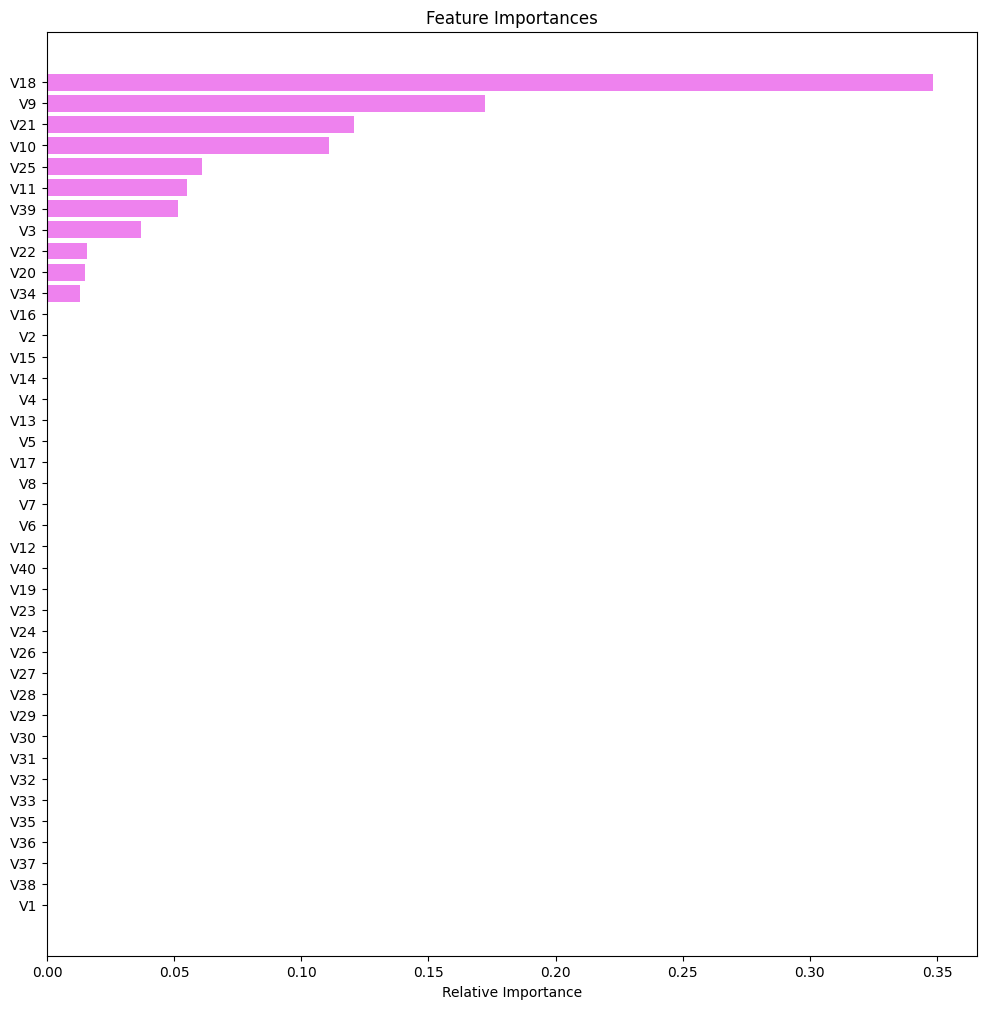

In [ ]:
feature_names = X.columns
importances = dTree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Pipelines to build the final model


In [ ]:
# Separating target variable and other variables
X_train1 = TrData.drop(columns="Target")
y_train1 = TrData["Target"]

In [ ]:
X_test1=TeData.drop(columns="Target")
y_test1=TeData["Target"]

In [ ]:
imputer = SimpleImputer(strategy="median")
X_train1 = imputer.fit_transform(X_train1)

In [ ]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

In [ ]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("num", numeric_transformer),
         (
          "Dtree", DecisionTreeClassifier(
            min_samples_leaf=7,
            max_leaf_nodes=15,
            max_depth=5,
            random_state=1,
            min_impurity_decrease=0.0001,
            )

        ),
    ]
)
# Fit the model on training data
model.fit(X_train1, y_train1)

Pipeline(steps=[('num',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='median'))])),
                ('Dtree',
                 DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                                        min_impurity_decrease=0.0001,
                                        min_samples_leaf=7, random_state=1))])

In [ ]:
Model_train = model_performance_classification_sklearn(model, X_train1, y_train1)
Model_train

Accuracy  Recall  Precision    F1
0     0.973   0.614      0.856 0.715

In [ ]:
Model_test = model_performance_classification_sklearn(model, X_test1, y_test1)
Model_test

Accuracy  Recall  Precision    F1
0     0.965   0.553      0.761 0.641

# Business Insights and Conclusions

- Since the recall score is very low for the test set, ReneWind must perform inspections regularly, due to the lower cost of inspection compared to reparing and replacement

- The most important features as observed in the feature importance, must be prioritize when doing inspections

***